<center>
    <img src="images/personal_logo.png"/>
</center>

# Deep Unsupervised Learning - Final Project
### Juan Carlos Garzon Pico
### Viviane Alves

---

<br>

<div align="center">
  
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/Juank0621)
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?logo=linkedin)](https://www.linkedin.com/in/juancarlosgarzon)
![Python](https://badges.aleen42.com/src/python.svg)

</div>

### CIFAR10 AI System

We are developing an AI system using deep learning techniques like Convolutional Autoencoders (CAE), Variational Autoencoders (VAE), and Generative Adversarial Networks (GANs) with the CIFAR10 dataset. These models will help in facial feature extraction, attribute classification, and image generation. By leveraging these approaches, we aim to enhance face recognition, noise reduction, and synthetic face generation for improved image analysis.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from PIL import Image
from tqdm import tqdm   
#from tqdm.rich import tqdm  # Import tqdm.rich for progress bars

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision.utils import save_image
from torchsummary import summary

torch.set_float32_matmul_precision('medium')

## PyTorch and GPU Information

This code snippet displays the PyTorch version, CUDA version, cuDNN version, and the number of GPUs available for PyTorch.

The first line prints the PyTorch version being used.
The second and third lines retrieve and display the CUDA and cuDNN versions used by PyTorch.
The final line shows the number of GPUs available for PyTorch, helping to confirm whether your system is utilizing the GPU for processing.
This is useful for ensuring that your environment is correctly set up to use GPU acceleration.

In [2]:
print("PyTorch Version:", torch.__version__)

PyTorch Version: 2.6.0+cu124


In [3]:
# Get the CUDA version used by PyTorch
cuda_version = torch.version.cuda
print("CUDA Version:", cuda_version)

# Get the cuDNN version used by PyTorch
cudnn_version = torch.backends.cudnn.version()
print("cuDNN Version:", cudnn_version)

CUDA Version: 12.4
cuDNN Version: 90100


In [4]:
# Get the number of GPUs available
num_gpus = torch.cuda.device_count()
print("Num GPUs Available:", num_gpus)

Num GPUs Available: 1


Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that.

In [5]:
!nvidia-smi

Fri Apr  4 07:58:54 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4080        Off | 00000000:01:00.0  On |                  N/A |
| 30%   27C    P8              10W / 320W |    470MiB / 16376MiB |     20%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Dataset Directory

Here we define the transformations to be applied to the images in the CIFAR10 dataset.

In [6]:
# Define transformations for the CIFAR10 dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
kwargs = {'num_workers': 8, 'pin_memory': True} # Adjusted for DataLoader

In [8]:
dummy_dataset = CIFAR10(root='./data', train=True, download=True)
print(dummy_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
# Custom Dataset class for loading CIFAR10 images of a specific class
class OneClassDatasetCIFAR10(CIFAR10):
    def __init__(self, root_dir, real_class=1, transform=None, train=True, download=True):
        super().__init__(root=root_dir, transform=transform, train=train, download=download)
        self.real_class = real_class
        self.samples = []
        for i in range(len(self.data)):
            if self.targets[i] == self.real_class:
                self.samples.append((self.data[i], self.targets[i]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        data = self.samples[idx]
        image = Image.fromarray(data[0])  # Convertir a objeto PIL

        # Aplicar transformaciones si están definidas
        if self.transform:
            image = self.transform(image)

        label = 0  # Dummy label as autoencoder does not need labels

        return image, label

## Variational autoencoder (VAE)

In [10]:
class VAEEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAEEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU()
        )
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.log_var = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.encoder(x)
        mean = self.mean(h)
        log_var = self.log_var(h)
        return mean, log_var

In [11]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(VAEDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.decoder(z)

In [12]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = VAEDecoder(latent_dim, hidden_dim, input_dim)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        std = torch.clamp(std, min=1e-6, max=1e6)
        epsilon = torch.randn_like(std)
        return mean + epsilon * std

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterize(mean, log_var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
def vae_loss_function(x, x_hat, mean, log_var, beta=0.1):
    reconstruction_loss = nn.functional.mse_loss(x_hat, x, reduction='mean')  # Changed to 'mean'
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    kl_divergence = torch.clamp(kl_divergence, min=-1e6, max=1e6)
    return reconstruction_loss + beta * kl_divergence / x.size(0)  # Normalize KL by batch size

# Function to train the VAE for one epoch with tqdm
def train_vae_epoch(vae, train_loader, optimizer):
    vae.train()
    total_loss = 0
    # Use standard tqdm to display progress
    for inputs, _ in tqdm(train_loader, desc="Training VAE Epoch", leave=False):  # Updated tqdm usage
        inputs = inputs.view(inputs.size(0), -1).to(device)
        inputs = torch.clamp(inputs, 0., 1.)  # Normalize inputs to range [0, 1]
        optimizer.zero_grad()
        x_hat, mean, log_var = vae(inputs)
        loss = vae_loss_function(inputs, x_hat, mean, log_var, beta=0.1)
        if torch.isnan(loss):
            print("NaN detected in loss! Skipping batch.")
            continue
        loss.backward()
        
        # Log gradients for debugging
        for name, param in vae.named_parameters():
            if param.grad is not None:
                print(f"Gradient for {name}: {param.grad.norm().item()}")

        torch.nn.utils.clip_grad_norm_(vae.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


def evaluate_vae(vae, val_loader):
    vae.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)
            x_hat, mean, log_var = vae(inputs)
            loss = vae_loss_function(inputs, x_hat, mean, log_var)
            total_loss += loss.item()
    return total_loss / len(val_loader)


def calculate_mahalanobis_distance(mean, covariance, x):
    diff = x - mean
    inv_covariance = torch.linalg.inv(covariance)
    distance = torch.sqrt(torch.mm(torch.mm(diff.unsqueeze(0), inv_covariance), diff.unsqueeze(1)))
    return distance.item()


def test_vae(vae, test_loader, threshold):
    vae.eval()
    anomalies = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.view(inputs.size(0), -1).to(device)
            x_hat, mean, log_var = vae(inputs)
            z = vae.reparameterize(mean, log_var)
            distances = [calculate_mahalanobis_distance(mean[i], torch.eye(mean.size(1)).to(device), z[i]) for i in range(z.size(0))]
            anomalies.extend([d > threshold for d in distances])
    return anomalies


In [17]:
def main_vae():
    input_dim = 128 * 128 * 3
    hidden_dim = 512
    latent_dim = 128
    num_epochs = 3
    learning_rate = 1e-4

    vae = VAE(input_dim, hidden_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)

    all_train_losses = []
    all_val_losses = []

    for real_class in range(10):
        print(f"Training VAE for class {real_class}...")

        train_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=True, download=True)
        val_dataset = OneClassDatasetCIFAR10(root_dir='data', real_class=real_class, transform=transform, train=False, download=True)

        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, **kwargs)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, **kwargs)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            train_loss = train_vae_epoch(vae, train_loader, optimizer)
            val_loss = evaluate_vae(vae, val_loader)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)

        # Save the trained model
        torch.save(vae.state_dict(), f'models/vae/vae_class_{real_class}_weights.pth')

    return all_train_losses, all_val_losses

In [18]:
# Call the main function for VAE
all_train_losses, all_val_losses = main_vae()

Training VAE for class 0...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:03, 20.57it/s]

Gradient for encoder.encoder.0.weight: 69.01309967041016
Gradient for encoder.encoder.0.bias: 6.857793977133042e-08
Gradient for encoder.encoder.1.weight: 0.38031458854675293
Gradient for encoder.encoder.1.bias: 0.23685623705387115
Gradient for encoder.encoder.3.weight: 7.928630828857422
Gradient for encoder.encoder.3.bias: 9.961159008753384e-08
Gradient for encoder.encoder.4.weight: 1.0521678924560547
Gradient for encoder.encoder.4.bias: 0.8537461161613464
Gradient for encoder.mean.weight: 6.057049751281738
Gradient for encoder.mean.bias: 0.5718256831169128
Gradient for encoder.log_var.weight: 8.026944160461426
Gradient for encoder.log_var.bias: 0.6032436490058899
Gradient for decoder.decoder.0.weight: 0.00027033156948164105
Gradient for decoder.decoder.0.bias: 1.6926044984003075e-12
Gradient for decoder.decoder.1.weight: 1.3455878615786787e-05
Gradient for decoder.decoder.1.bias: 1.0267544894304592e-05
Gradient for decoder.decoder.3.weight: 0.00030052129295654595
Gradient for decoder

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:01, 46.95it/s]

Gradient for encoder.encoder.0.weight: 2.044830560684204
Gradient for encoder.encoder.0.bias: 3.4615439403751225e-09
Gradient for encoder.encoder.1.weight: 0.10282322764396667
Gradient for encoder.encoder.1.bias: 0.07091552019119263
Gradient for encoder.encoder.3.weight: 2.191467761993408
Gradient for encoder.encoder.3.bias: 3.451970087553491e-08
Gradient for encoder.encoder.4.weight: 0.3204665184020996
Gradient for encoder.encoder.4.bias: 0.3491657078266144
Gradient for encoder.mean.weight: 3.76589035987854
Gradient for encoder.mean.bias: 0.3546150028705597
Gradient for encoder.log_var.weight: 2.3035528659820557
Gradient for encoder.log_var.bias: 0.22208508849143982
Gradient for decoder.decoder.0.weight: 0.005136181600391865
Gradient for decoder.decoder.0.bias: 3.843075510601146e-11
Gradient for decoder.decoder.1.weight: 0.0002825072733685374
Gradient for decoder.decoder.1.bias: 0.0001806214131647721
Gradient for decoder.decoder.3.weight: 0.00457135122269392
Gradient for decoder.decod

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 61.71it/s]

Gradient for encoder.encoder.0.weight: 0.7488377094268799
Gradient for encoder.encoder.0.bias: 1.10202313940988e-09
Gradient for encoder.encoder.1.weight: 0.05389483645558357
Gradient for encoder.encoder.1.bias: 0.03775711730122566
Gradient for encoder.encoder.3.weight: 1.229591965675354
Gradient for encoder.encoder.3.bias: 1.1002565969420175e-08
Gradient for encoder.encoder.4.weight: 0.11439676582813263
Gradient for encoder.encoder.4.bias: 0.12488323450088501
Gradient for encoder.mean.weight: 1.4633296728134155
Gradient for encoder.mean.bias: 0.13206690549850464
Gradient for encoder.log_var.weight: 0.9171082973480225
Gradient for encoder.log_var.bias: 0.0789145827293396
Gradient for decoder.decoder.0.weight: 0.011190352961421013
Gradient for decoder.decoder.0.bias: 9.090199426520229e-11
Gradient for decoder.decoder.1.weight: 0.0006588204414583743
Gradient for decoder.decoder.1.bias: 0.0004019183397758752
Gradient for decoder.decoder.3.weight: 0.009400146082043648
Gradient for decoder.

Training VAE Epoch:  72%|███████▏  | 57/79 [00:01<00:00, 69.63it/s]

Gradient for encoder.encoder.0.weight: 0.37584951519966125
Gradient for encoder.encoder.0.bias: 6.205775338052888e-10
Gradient for encoder.encoder.1.weight: 0.03454049676656723
Gradient for encoder.encoder.1.bias: 0.029367147013545036
Gradient for encoder.encoder.3.weight: 0.7568774223327637
Gradient for encoder.encoder.3.bias: 4.819927124088963e-09
Gradient for encoder.encoder.4.weight: 0.05196542665362358
Gradient for encoder.encoder.4.bias: 0.05039549246430397
Gradient for encoder.mean.weight: 0.5983079075813293
Gradient for encoder.mean.bias: 0.04185786098241806
Gradient for encoder.log_var.weight: 0.3926016688346863
Gradient for encoder.log_var.bias: 0.02614610828459263
Gradient for decoder.decoder.0.weight: 0.01694711670279503
Gradient for decoder.decoder.0.bias: 1.338879701551221e-10
Gradient for decoder.decoder.1.weight: 0.0009266980341635644
Gradient for decoder.decoder.1.bias: 0.0006100567406974733
Gradient for decoder.decoder.3.weight: 0.013456116430461407
Gradient for decod

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 74.00it/s]

Gradient for encoder.encoder.0.weight: 0.21138714253902435
Gradient for encoder.encoder.0.bias: 3.3982228142548365e-10
Gradient for encoder.encoder.1.weight: 0.021551696583628654
Gradient for encoder.encoder.1.bias: 0.016074124723672867
Gradient for encoder.encoder.3.weight: 0.4748550355434418
Gradient for encoder.encoder.3.bias: 2.669149345990718e-09
Gradient for encoder.encoder.4.weight: 0.026683740317821503
Gradient for encoder.encoder.4.bias: 0.025525689125061035
Gradient for encoder.mean.weight: 0.34650105237960815
Gradient for encoder.mean.bias: 0.021359464153647423
Gradient for encoder.log_var.weight: 0.20149143040180206
Gradient for encoder.log_var.bias: 0.012724008411169052
Gradient for decoder.decoder.0.weight: 0.01637527160346508
Gradient for decoder.decoder.0.bias: 1.3903342366283766e-10
Gradient for decoder.decoder.1.weight: 0.0008685918874107301
Gradient for decoder.decoder.1.bias: 0.0005686196964234114
Gradient for decoder.decoder.3.weight: 0.012663489207625389
Gradient 

Gradient for encoder.encoder.0.weight: 0.15813226997852325
Gradient for encoder.encoder.0.bias: 2.727038872496479e-10
Gradient for encoder.encoder.1.weight: 0.01659572683274746
Gradient for encoder.encoder.1.bias: 0.012513403780758381
Gradient for encoder.encoder.3.weight: 0.36134523153305054
Gradient for encoder.encoder.3.bias: 1.9623591640538507e-09
Gradient for encoder.encoder.4.weight: 0.02041625790297985
Gradient for encoder.encoder.4.bias: 0.02059277519583702
Gradient for encoder.mean.weight: 0.27661746740341187
Gradient for encoder.mean.bias: 0.01406900305300951
Gradient for encoder.log_var.weight: 0.15508835017681122
Gradient for encoder.log_var.bias: 0.00917771179229021
Gradient for decoder.decoder.0.weight: 0.01592557318508625
Gradient for decoder.decoder.0.bias: 1.3384576780239854e-10
Gradient for decoder.decoder.1.weight: 0.0008624983602203429
Gradient for decoder.decoder.1.bias: 0.0006312723853625357
Gradient for decoder.decoder.3.weight: 0.012905796058475971
Gradient for 

Epoch 1/3, Train Loss: 1.2971, Val Loss: 0.7051


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.52it/s]

Gradient for encoder.encoder.0.weight: 0.15590079128742218
Gradient for encoder.encoder.0.bias: 3.061032816109588e-10
Gradient for encoder.encoder.1.weight: 0.022775694727897644
Gradient for encoder.encoder.1.bias: 0.016120174899697304
Gradient for encoder.encoder.3.weight: 0.49209898710250854
Gradient for encoder.encoder.3.bias: 2.0818466950345282e-09
Gradient for encoder.encoder.4.weight: 0.029424428939819336
Gradient for encoder.encoder.4.bias: 0.02437019906938076
Gradient for encoder.mean.weight: 0.362394243478775
Gradient for encoder.mean.bias: 0.013744639232754707
Gradient for encoder.log_var.weight: 0.2013082653284073
Gradient for encoder.log_var.bias: 0.006968790199607611
Gradient for decoder.decoder.0.weight: 0.016278397291898727
Gradient for decoder.decoder.0.bias: 1.4473405807180484e-10
Gradient for decoder.decoder.1.weight: 0.0008301309426315129
Gradient for decoder.decoder.1.bias: 0.0005689835525117815
Gradient for decoder.decoder.3.weight: 0.012818553484976292
Gradient fo

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.82it/s]

Gradient for encoder.encoder.0.weight: 0.14564301073551178
Gradient for encoder.encoder.0.bias: 2.439158042211176e-10
Gradient for encoder.encoder.1.weight: 0.019187811762094498
Gradient for encoder.encoder.1.bias: 0.014695648103952408
Gradient for encoder.encoder.3.weight: 0.44416192173957825
Gradient for encoder.encoder.3.bias: 1.7607141300501894e-09
Gradient for encoder.encoder.4.weight: 0.024973317980766296
Gradient for encoder.encoder.4.bias: 0.020234405994415283
Gradient for encoder.mean.weight: 0.3051629960536957
Gradient for encoder.mean.bias: 0.010529283434152603
Gradient for encoder.log_var.weight: 0.14244885742664337
Gradient for encoder.log_var.bias: 0.006467439234256744
Gradient for decoder.decoder.0.weight: 0.01622268185019493
Gradient for decoder.decoder.0.bias: 1.3725499903305405e-10
Gradient for decoder.decoder.1.weight: 0.0008652126998640597
Gradient for decoder.decoder.1.bias: 0.0005780913634225726
Gradient for decoder.decoder.3.weight: 0.012606636621057987
Gradient 

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 53.46it/s]

Gradient for encoder.encoder.0.weight: 0.10870411247015
Gradient for encoder.encoder.0.bias: 2.052632785964903e-10
Gradient for encoder.encoder.1.weight: 0.01589171215891838
Gradient for encoder.encoder.1.bias: 0.011061129160225391
Gradient for encoder.encoder.3.weight: 0.33566826581954956
Gradient for encoder.encoder.3.bias: 1.668904681118022e-09
Gradient for encoder.encoder.4.weight: 0.021547850221395493
Gradient for encoder.encoder.4.bias: 0.019102754071354866
Gradient for encoder.mean.weight: 0.2688846290111542
Gradient for encoder.mean.bias: 0.011391502805054188
Gradient for encoder.log_var.weight: 0.1478140503168106
Gradient for encoder.log_var.bias: 0.006378838326781988
Gradient for decoder.decoder.0.weight: 0.0192886795848608
Gradient for decoder.decoder.0.bias: 1.44936090906711e-10
Gradient for decoder.decoder.1.weight: 0.0009972945554181933
Gradient for decoder.decoder.1.bias: 0.000688240397721529
Gradient for decoder.decoder.3.weight: 0.01558669749647379
Gradient for decoder

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.95it/s]

Gradient for encoder.encoder.0.weight: 0.1040998175740242
Gradient for encoder.encoder.0.bias: 1.9432269682262415e-10
Gradient for encoder.encoder.1.weight: 0.014590034261345863
Gradient for encoder.encoder.1.bias: 0.010088241659104824
Gradient for encoder.encoder.3.weight: 0.3341014087200165
Gradient for encoder.encoder.3.bias: 1.529836035629728e-09
Gradient for encoder.encoder.4.weight: 0.02170761302113533
Gradient for encoder.encoder.4.bias: 0.02158713899552822
Gradient for encoder.mean.weight: 0.2808654010295868
Gradient for encoder.mean.bias: 0.0161660797894001
Gradient for encoder.log_var.weight: 0.12114772945642471
Gradient for encoder.log_var.bias: 0.007980276830494404
Gradient for decoder.decoder.0.weight: 0.017080646008253098
Gradient for decoder.decoder.0.bias: 1.307758484836441e-10
Gradient for decoder.decoder.1.weight: 0.0009485921473242342
Gradient for decoder.decoder.1.bias: 0.0005882575642317533
Gradient for decoder.decoder.3.weight: 0.013670867308974266
Gradient for de

Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 67.28it/s]

Gradient for encoder.encoder.0.weight: 0.0748811811208725
Gradient for encoder.encoder.0.bias: 1.1841595759509715e-10
Gradient for encoder.encoder.1.weight: 0.009645717218518257
Gradient for encoder.encoder.1.bias: 0.0075540500693023205
Gradient for encoder.encoder.3.weight: 0.20890432596206665
Gradient for encoder.encoder.3.bias: 1.5202230585487087e-09
Gradient for encoder.encoder.4.weight: 0.016756663098931313
Gradient for encoder.encoder.4.bias: 0.01773836649954319
Gradient for encoder.mean.weight: 0.21033719182014465
Gradient for encoder.mean.bias: 0.012197946198284626
Gradient for encoder.log_var.weight: 0.12890049815177917
Gradient for encoder.log_var.bias: 0.007847693748772144
Gradient for decoder.decoder.0.weight: 0.020840350538492203
Gradient for decoder.decoder.0.bias: 1.9133546136362867e-10
Gradient for decoder.decoder.1.weight: 0.0010458523174747825
Gradient for decoder.decoder.1.bias: 0.0006689292495138943
Gradient for decoder.decoder.3.weight: 0.015935005620121956
Gradien

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 70.86it/s]

Gradient for encoder.encoder.0.weight: 0.09914630651473999
Gradient for encoder.encoder.0.bias: 1.8573229065843577e-10
Gradient for encoder.encoder.1.weight: 0.014408646151423454
Gradient for encoder.encoder.1.bias: 0.009348036721348763
Gradient for encoder.encoder.3.weight: 0.30359768867492676
Gradient for encoder.encoder.3.bias: 1.497857171628425e-09
Gradient for encoder.encoder.4.weight: 0.017085237428545952
Gradient for encoder.encoder.4.bias: 0.015218463726341724
Gradient for encoder.mean.weight: 0.2134106159210205
Gradient for encoder.mean.bias: 0.008836901746690273
Gradient for encoder.log_var.weight: 0.11121196299791336
Gradient for encoder.log_var.bias: 0.0047180745750665665
Gradient for decoder.decoder.0.weight: 0.01733282394707203
Gradient for decoder.decoder.0.bias: 1.5303874834060593e-10
Gradient for decoder.decoder.1.weight: 0.0009068885119631886
Gradient for decoder.decoder.1.bias: 0.0006026030168868601
Gradient for decoder.decoder.3.weight: 0.013771436177194118
Gradient

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 73.34it/s]

Gradient for encoder.encoder.0.weight: 0.08488816022872925
Gradient for encoder.encoder.0.bias: 1.2185819020515964e-10
Gradient for encoder.encoder.1.weight: 0.00862964615225792
Gradient for encoder.encoder.1.bias: 0.00667097233235836
Gradient for encoder.encoder.3.weight: 0.18298280239105225
Gradient for encoder.encoder.3.bias: 1.1752298023637309e-09
Gradient for encoder.encoder.4.weight: 0.01584380306303501
Gradient for encoder.encoder.4.bias: 0.014948619529604912
Gradient for encoder.mean.weight: 0.2028682380914688
Gradient for encoder.mean.bias: 0.010679074563086033
Gradient for encoder.log_var.weight: 0.12213964015245438
Gradient for encoder.log_var.bias: 0.005617094226181507
Gradient for decoder.decoder.0.weight: 0.018490321934223175
Gradient for decoder.decoder.0.bias: 1.7570307708769661e-10
Gradient for decoder.decoder.1.weight: 0.0010060425847768784
Gradient for decoder.decoder.1.bias: 0.0006646311958320439
Gradient for decoder.decoder.3.weight: 0.014377684332430363
Gradient f

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 75.01it/s]

Gradient for encoder.encoder.0.weight: 0.07839636504650116
Gradient for encoder.encoder.0.bias: 1.3148004907037603e-10
Gradient for encoder.encoder.1.weight: 0.01099494006484747
Gradient for encoder.encoder.1.bias: 0.007760764565318823
Gradient for encoder.encoder.3.weight: 0.2422853410243988
Gradient for encoder.encoder.3.bias: 1.0707236208773452e-09
Gradient for encoder.encoder.4.weight: 0.01656579039990902
Gradient for encoder.encoder.4.bias: 0.014539315365254879
Gradient for encoder.mean.weight: 0.21083545684814453
Gradient for encoder.mean.bias: 0.00890722218900919
Gradient for encoder.log_var.weight: 0.10767815262079239
Gradient for encoder.log_var.bias: 0.0052136327140033245
Gradient for decoder.decoder.0.weight: 0.015425564721226692
Gradient for decoder.decoder.0.bias: 1.2126544213231227e-10
Gradient for decoder.decoder.1.weight: 0.0008331909193657339
Gradient for decoder.decoder.1.bias: 0.0005491137853823602
Gradient for decoder.decoder.3.weight: 0.011562757194042206
Gradient 

Training VAE Epoch:  82%|████████▏ | 65/79 [00:01<00:00, 76.15it/s]

Gradient for encoder.encoder.0.weight: 0.07381445169448853
Gradient for encoder.encoder.0.bias: 1.2078835154305523e-10
Gradient for encoder.encoder.1.weight: 0.009907116182148457
Gradient for encoder.encoder.1.bias: 0.007799605373293161
Gradient for encoder.encoder.3.weight: 0.21739274263381958
Gradient for encoder.encoder.3.bias: 1.2588196041107835e-09
Gradient for encoder.encoder.4.weight: 0.01559187937527895
Gradient for encoder.encoder.4.bias: 0.01594145968556404
Gradient for encoder.mean.weight: 0.20473706722259521
Gradient for encoder.mean.bias: 0.011220837943255901
Gradient for encoder.log_var.weight: 0.10777853429317474
Gradient for encoder.log_var.bias: 0.006800324656069279
Gradient for decoder.decoder.0.weight: 0.017748622223734856
Gradient for decoder.decoder.0.bias: 1.471588129131618e-10
Gradient for decoder.decoder.1.weight: 0.0009279123041778803
Gradient for decoder.decoder.1.bias: 0.0006279379012994468
Gradient for decoder.decoder.3.weight: 0.014113426208496094
Gradient 

Training VAE Epoch:  94%|█████████▎| 74/79 [00:01<00:00, 77.48it/s]

Gradient for encoder.encoder.0.weight: 0.05625304952263832
Gradient for encoder.encoder.0.bias: 9.7928588849161e-11
Gradient for encoder.encoder.1.weight: 0.007032443303614855
Gradient for encoder.encoder.1.bias: 0.005764964502304792
Gradient for encoder.encoder.3.weight: 0.15420305728912354
Gradient for encoder.encoder.3.bias: 1.234089830326468e-09
Gradient for encoder.encoder.4.weight: 0.013536442071199417
Gradient for encoder.encoder.4.bias: 0.0122105423361063
Gradient for encoder.mean.weight: 0.16760623455047607
Gradient for encoder.mean.bias: 0.009135391563177109
Gradient for encoder.log_var.weight: 0.0837426409125328
Gradient for encoder.log_var.bias: 0.005513036623597145
Gradient for decoder.decoder.0.weight: 0.02046908065676689
Gradient for decoder.decoder.0.bias: 1.829992268831404e-10
Gradient for decoder.decoder.1.weight: 0.0011325892992317677
Gradient for decoder.decoder.1.bias: 0.0007364169578067958
Gradient for decoder.decoder.3.weight: 0.016000639647245407
Gradient for de

Epoch 2/3, Train Loss: 0.1295, Val Loss: 0.3636


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.47it/s]

Gradient for encoder.encoder.0.weight: 0.0757203996181488
Gradient for encoder.encoder.0.bias: 1.2394316128983007e-10
Gradient for encoder.encoder.1.weight: 0.012562472373247147
Gradient for encoder.encoder.1.bias: 0.008794283494353294
Gradient for encoder.encoder.3.weight: 0.27961575984954834
Gradient for encoder.encoder.3.bias: 1.12140108310399e-09
Gradient for encoder.encoder.4.weight: 0.0209676343947649
Gradient for encoder.encoder.4.bias: 0.016591720283031464
Gradient for encoder.mean.weight: 0.25919485092163086
Gradient for encoder.mean.bias: 0.008945452980697155
Gradient for encoder.log_var.weight: 0.13094571232795715
Gradient for encoder.log_var.bias: 0.005085061304271221
Gradient for decoder.decoder.0.weight: 0.01841452717781067
Gradient for decoder.decoder.0.bias: 1.527465515183124e-10
Gradient for decoder.decoder.1.weight: 0.000977777410298586
Gradient for decoder.decoder.1.bias: 0.000652370392344892
Gradient for decoder.decoder.3.weight: 0.01442198920994997
Gradient for dec

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.40it/s]

Gradient for encoder.encoder.0.weight: 0.07158888876438141
Gradient for encoder.encoder.0.bias: 1.1900080920668188e-10
Gradient for encoder.encoder.1.weight: 0.009730651043355465
Gradient for encoder.encoder.1.bias: 0.007421074900776148
Gradient for encoder.encoder.3.weight: 0.21244211494922638
Gradient for encoder.encoder.3.bias: 1.1867226090700456e-09
Gradient for encoder.encoder.4.weight: 0.017875075340270996
Gradient for encoder.encoder.4.bias: 0.01465730182826519
Gradient for encoder.mean.weight: 0.21921613812446594
Gradient for encoder.mean.bias: 0.009584298357367516
Gradient for encoder.log_var.weight: 0.11534126847982407
Gradient for encoder.log_var.bias: 0.00537350308150053
Gradient for decoder.decoder.0.weight: 0.01742398738861084
Gradient for decoder.decoder.0.bias: 1.4932120817601202e-10
Gradient for decoder.decoder.1.weight: 0.0009765741415321827
Gradient for decoder.decoder.1.bias: 0.0006091570248827338
Gradient for decoder.decoder.3.weight: 0.013628431595861912
Gradient 

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.97it/s]

Gradient for encoder.encoder.0.weight: 0.05590822920203209
Gradient for encoder.encoder.0.bias: 1.0370034692064323e-10
Gradient for encoder.encoder.1.weight: 0.009878991171717644
Gradient for encoder.encoder.1.bias: 0.00651601841673255
Gradient for encoder.encoder.3.weight: 0.21360209584236145
Gradient for encoder.encoder.3.bias: 1.0013240236972365e-09
Gradient for encoder.encoder.4.weight: 0.015773829072713852
Gradient for encoder.encoder.4.bias: 0.012695267796516418
Gradient for encoder.mean.weight: 0.20331555604934692
Gradient for encoder.mean.bias: 0.009281983599066734
Gradient for encoder.log_var.weight: 0.0934503823518753
Gradient for encoder.log_var.bias: 0.004635649733245373
Gradient for decoder.decoder.0.weight: 0.019889649003744125
Gradient for decoder.decoder.0.bias: 1.642949387647974e-10
Gradient for decoder.decoder.1.weight: 0.0010913300793617964
Gradient for decoder.decoder.1.bias: 0.0007270105998031795
Gradient for decoder.decoder.3.weight: 0.01547593716531992
Gradient f

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.82it/s]

Gradient for encoder.encoder.0.weight: 0.10141714662313461
Gradient for encoder.encoder.0.bias: 1.4121398494992832e-10
Gradient for encoder.encoder.1.weight: 0.013035841286182404
Gradient for encoder.encoder.1.bias: 0.0104542076587677
Gradient for encoder.encoder.3.weight: 0.2859468460083008
Gradient for encoder.encoder.3.bias: 1.3071527193986299e-09
Gradient for encoder.encoder.4.weight: 0.018485859036445618
Gradient for encoder.encoder.4.bias: 0.01761597767472267
Gradient for encoder.mean.weight: 0.24753229320049286
Gradient for encoder.mean.bias: 0.01200854778289795
Gradient for encoder.log_var.weight: 0.1315930038690567
Gradient for encoder.log_var.bias: 0.005880019161850214
Gradient for decoder.decoder.0.weight: 0.016983594745397568
Gradient for decoder.decoder.0.bias: 1.4727430386329843e-10
Gradient for decoder.decoder.1.weight: 0.0009702963288873434
Gradient for decoder.decoder.1.bias: 0.0006341652479022741
Gradient for decoder.decoder.3.weight: 0.013195851817727089
Gradient for

Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 67.31it/s]

Gradient for encoder.encoder.0.weight: 0.06184573471546173
Gradient for encoder.encoder.0.bias: 1.1075490524703469e-10
Gradient for encoder.encoder.1.weight: 0.009773415513336658
Gradient for encoder.encoder.1.bias: 0.007347471080720425
Gradient for encoder.encoder.3.weight: 0.20743347704410553
Gradient for encoder.encoder.3.bias: 9.908134313008077e-10
Gradient for encoder.encoder.4.weight: 0.01569332554936409
Gradient for encoder.encoder.4.bias: 0.016009531915187836
Gradient for encoder.mean.weight: 0.20636232197284698
Gradient for encoder.mean.bias: 0.010485383681952953
Gradient for encoder.log_var.weight: 0.10967493802309036
Gradient for encoder.log_var.bias: 0.004800124559551477
Gradient for decoder.decoder.0.weight: 0.018185056746006012
Gradient for decoder.decoder.0.bias: 1.6948571712749327e-10
Gradient for decoder.decoder.1.weight: 0.0009992739651352167
Gradient for decoder.decoder.1.bias: 0.0006914963014423847
Gradient for decoder.decoder.3.weight: 0.01414873730391264
Gradient 

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 70.69it/s]

Gradient for encoder.encoder.0.weight: 0.07200180739164352
Gradient for encoder.encoder.0.bias: 1.0438234998577656e-10
Gradient for encoder.encoder.1.weight: 0.010387425310909748
Gradient for encoder.encoder.1.bias: 0.0079212486743927
Gradient for encoder.encoder.3.weight: 0.22529318928718567
Gradient for encoder.encoder.3.bias: 1.1415528522462637e-09
Gradient for encoder.encoder.4.weight: 0.017457250505685806
Gradient for encoder.encoder.4.bias: 0.017740804702043533
Gradient for encoder.mean.weight: 0.22625845670700073
Gradient for encoder.mean.bias: 0.011028064414858818
Gradient for encoder.log_var.weight: 0.11427722871303558
Gradient for encoder.log_var.bias: 0.0055248793214559555
Gradient for decoder.decoder.0.weight: 0.020641328766942024
Gradient for decoder.decoder.0.bias: 1.8849538596654725e-10
Gradient for decoder.decoder.1.weight: 0.001066463883034885
Gradient for decoder.decoder.1.bias: 0.0006908695213496685
Gradient for decoder.decoder.3.weight: 0.015959888696670532
Gradient

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 73.14it/s]

Gradient for encoder.encoder.0.weight: 0.05303256958723068
Gradient for encoder.encoder.0.bias: 6.940337193839241e-11
Gradient for encoder.encoder.1.weight: 0.0082811014726758
Gradient for encoder.encoder.1.bias: 0.006085655651986599
Gradient for encoder.encoder.3.weight: 0.17660261690616608
Gradient for encoder.encoder.3.bias: 1.01407193753289e-09
Gradient for encoder.encoder.4.weight: 0.014808068983256817
Gradient for encoder.encoder.4.bias: 0.015052549540996552
Gradient for encoder.mean.weight: 0.19542676210403442
Gradient for encoder.mean.bias: 0.010747029446065426
Gradient for encoder.log_var.weight: 0.09783999621868134
Gradient for encoder.log_var.bias: 0.005112088285386562
Gradient for decoder.decoder.0.weight: 0.019757920876145363
Gradient for decoder.decoder.0.bias: 1.8183768379920195e-10
Gradient for decoder.decoder.1.weight: 0.0010883989743888378
Gradient for decoder.decoder.1.bias: 0.0007168398587964475
Gradient for decoder.decoder.3.weight: 0.01608164794743061
Gradient for

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.52it/s]

Gradient for encoder.encoder.0.weight: 0.05146123468875885
Gradient for encoder.encoder.0.bias: 7.14724598949168e-11
Gradient for encoder.encoder.1.weight: 0.007327503990381956
Gradient for encoder.encoder.1.bias: 0.0057121929712593555
Gradient for encoder.encoder.3.weight: 0.16267244517803192
Gradient for encoder.encoder.3.bias: 8.747793045493779e-10
Gradient for encoder.encoder.4.weight: 0.014819779433310032
Gradient for encoder.encoder.4.bias: 0.01427406631410122
Gradient for encoder.mean.weight: 0.1824268400669098
Gradient for encoder.mean.bias: 0.00986521877348423
Gradient for encoder.log_var.weight: 0.10705340653657913
Gradient for encoder.log_var.bias: 0.005257440730929375
Gradient for decoder.decoder.0.weight: 0.021781807765364647
Gradient for decoder.decoder.0.bias: 1.807795163566439e-10
Gradient for decoder.decoder.1.weight: 0.0011626625200733542
Gradient for decoder.decoder.1.bias: 0.0008251104736700654
Gradient for decoder.decoder.3.weight: 0.01662619039416313
Gradient for 

Training VAE Epoch:  82%|████████▏ | 65/79 [00:01<00:00, 74.90it/s]

Gradient for encoder.encoder.0.weight: 0.06636301428079605
Gradient for encoder.encoder.0.bias: 9.274844781081981e-11
Gradient for encoder.encoder.1.weight: 0.010757998563349247
Gradient for encoder.encoder.1.bias: 0.007888400927186012
Gradient for encoder.encoder.3.weight: 0.24433422088623047
Gradient for encoder.encoder.3.bias: 1.2607404009656875e-09
Gradient for encoder.encoder.4.weight: 0.02385788969695568
Gradient for encoder.encoder.4.bias: 0.020549556240439415
Gradient for encoder.mean.weight: 0.294200599193573
Gradient for encoder.mean.bias: 0.01134067215025425
Gradient for encoder.log_var.weight: 0.18382366001605988
Gradient for encoder.log_var.bias: 0.007126744370907545
Gradient for decoder.decoder.0.weight: 0.023022225126624107
Gradient for decoder.decoder.0.bias: 2.0466703332111535e-10
Gradient for decoder.decoder.1.weight: 0.0012171330163255334
Gradient for decoder.decoder.1.bias: 0.0007710627978667617
Gradient for decoder.decoder.3.weight: 0.018095023930072784
Gradient fo

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 76.40it/s]

Gradient for encoder.encoder.0.weight: 0.054002150893211365
Gradient for encoder.encoder.0.bias: 9.509108778171793e-11
Gradient for encoder.encoder.1.weight: 0.007364755496382713
Gradient for encoder.encoder.1.bias: 0.005359376780688763
Gradient for encoder.encoder.3.weight: 0.15257152915000916
Gradient for encoder.encoder.3.bias: 9.365125341886937e-10
Gradient for encoder.encoder.4.weight: 0.013494542799890041
Gradient for encoder.encoder.4.bias: 0.015019089914858341
Gradient for encoder.mean.weight: 0.16708984971046448
Gradient for encoder.mean.bias: 0.010513397864997387
Gradient for encoder.log_var.weight: 0.0988357812166214
Gradient for encoder.log_var.bias: 0.00647752033546567
Gradient for decoder.decoder.0.weight: 0.016500497236847878
Gradient for decoder.decoder.0.bias: 1.423352824492241e-10
Gradient for decoder.decoder.1.weight: 0.0008746756939217448
Gradient for decoder.decoder.1.bias: 0.000618292426224798
Gradient for decoder.decoder.3.weight: 0.01336434856057167
Gradient for

Epoch 3/3, Train Loss: 0.1149, Val Loss: 0.3248
Training VAE for class 1...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:02, 34.53it/s]

Gradient for encoder.encoder.0.weight: 0.10088410973548889
Gradient for encoder.encoder.0.bias: 1.6105457245618737e-10
Gradient for encoder.encoder.1.weight: 0.011488058604300022
Gradient for encoder.encoder.1.bias: 0.008228939957916737
Gradient for encoder.encoder.3.weight: 0.2680259644985199
Gradient for encoder.encoder.3.bias: 1.5299396194379256e-09
Gradient for encoder.encoder.4.weight: 0.02678694948554039
Gradient for encoder.encoder.4.bias: 0.02445749193429947
Gradient for encoder.mean.weight: 0.3118588924407959
Gradient for encoder.mean.bias: 0.016103805974125862
Gradient for encoder.log_var.weight: 0.17462532222270966
Gradient for encoder.log_var.bias: 0.010182676836848259
Gradient for decoder.decoder.0.weight: 0.013304413296282291
Gradient for decoder.decoder.0.bias: 1.0864970728663437e-10
Gradient for decoder.decoder.1.weight: 0.0006995925214141607
Gradient for decoder.decoder.1.bias: 0.00046216160990297794
Gradient for decoder.decoder.3.weight: 0.010418552905321121
Gradient 

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 58.82it/s]

Gradient for encoder.encoder.0.weight: 0.09242180734872818
Gradient for encoder.encoder.0.bias: 1.3426275369265994e-10
Gradient for encoder.encoder.1.weight: 0.00911672506481409
Gradient for encoder.encoder.1.bias: 0.006248159799724817
Gradient for encoder.encoder.3.weight: 0.20248208940029144
Gradient for encoder.encoder.3.bias: 1.1658803922287575e-09
Gradient for encoder.encoder.4.weight: 0.017133036628365517
Gradient for encoder.encoder.4.bias: 0.018559033051133156
Gradient for encoder.mean.weight: 0.2335774302482605
Gradient for encoder.mean.bias: 0.014159970916807652
Gradient for encoder.log_var.weight: 0.13679704070091248
Gradient for encoder.log_var.bias: 0.008835641667246819
Gradient for decoder.decoder.0.weight: 0.013279154896736145
Gradient for decoder.decoder.0.bias: 1.2386090764149316e-10
Gradient for decoder.decoder.1.weight: 0.0007020562770776451
Gradient for decoder.decoder.1.bias: 0.0004756560956593603
Gradient for decoder.decoder.3.weight: 0.010633622296154499
Gradient

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 68.36it/s]

Gradient for encoder.encoder.0.weight: 0.14753447473049164
Gradient for encoder.encoder.0.bias: 2.072368526784274e-10
Gradient for encoder.encoder.1.weight: 0.013062880374491215
Gradient for encoder.encoder.1.bias: 0.009608194231987
Gradient for encoder.encoder.3.weight: 0.30426108837127686
Gradient for encoder.encoder.3.bias: 1.3135280640952374e-09
Gradient for encoder.encoder.4.weight: 0.025460492819547653
Gradient for encoder.encoder.4.bias: 0.02023363672196865
Gradient for encoder.mean.weight: 0.35500484704971313
Gradient for encoder.mean.bias: 0.01175850722938776
Gradient for encoder.log_var.weight: 0.18914085626602173
Gradient for encoder.log_var.bias: 0.006417463067919016
Gradient for decoder.decoder.0.weight: 0.015295949764549732
Gradient for decoder.decoder.0.bias: 1.266649563014255e-10
Gradient for decoder.decoder.1.weight: 0.0008166806655935943
Gradient for decoder.decoder.1.bias: 0.0005531165516003966
Gradient for decoder.decoder.3.weight: 0.012344361282885075
Gradient for 

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.32it/s]

Gradient for encoder.encoder.0.weight: 0.07907920330762863
Gradient for encoder.encoder.0.bias: 1.2082557176995579e-10
Gradient for encoder.encoder.1.weight: 0.008041368797421455
Gradient for encoder.encoder.1.bias: 0.006314641796052456
Gradient for encoder.encoder.3.weight: 0.17749331891536713
Gradient for encoder.encoder.3.bias: 1.0421324914133834e-09
Gradient for encoder.encoder.4.weight: 0.018803300336003304
Gradient for encoder.encoder.4.bias: 0.01717705838382244
Gradient for encoder.mean.weight: 0.25453928112983704
Gradient for encoder.mean.bias: 0.01181249599903822
Gradient for encoder.log_var.weight: 0.1497652679681778
Gradient for encoder.log_var.bias: 0.00814986415207386
Gradient for decoder.decoder.0.weight: 0.01666703261435032
Gradient for decoder.decoder.0.bias: 1.351488365664011e-10
Gradient for decoder.decoder.1.weight: 0.0008978010155260563
Gradient for decoder.decoder.1.bias: 0.0005787831614725292
Gradient for decoder.decoder.3.weight: 0.014476174488663673
Gradient for

Training VAE Epoch:  94%|█████████▎| 74/79 [00:01<00:00, 76.36it/s]

Gradient for encoder.encoder.0.weight: 0.059525661170482635
Gradient for encoder.encoder.0.bias: 9.762019664849575e-11
Gradient for encoder.encoder.1.weight: 0.006445131730288267
Gradient for encoder.encoder.1.bias: 0.005559337325394154
Gradient for encoder.encoder.3.weight: 0.14386793971061707
Gradient for encoder.encoder.3.bias: 8.287547870189371e-10
Gradient for encoder.encoder.4.weight: 0.017607765272259712
Gradient for encoder.encoder.4.bias: 0.01520206592977047
Gradient for encoder.mean.weight: 0.2123628556728363
Gradient for encoder.mean.bias: 0.010255622677505016
Gradient for encoder.log_var.weight: 0.12132654339075089
Gradient for encoder.log_var.bias: 0.005216316320002079
Gradient for decoder.decoder.0.weight: 0.014261823147535324
Gradient for decoder.decoder.0.bias: 1.3006738741605517e-10
Gradient for decoder.decoder.1.weight: 0.0007815223652869463
Gradient for decoder.decoder.1.bias: 0.0005226118955761194
Gradient for decoder.decoder.3.weight: 0.011746210046112537
Gradient 

Epoch 1/3, Train Loss: 0.1039, Val Loss: 0.4705


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:15,  5.04it/s]

Gradient for encoder.encoder.0.weight: 0.054222382605075836
Gradient for encoder.encoder.0.bias: 7.284219755154808e-11
Gradient for encoder.encoder.1.weight: 0.005843219347298145
Gradient for encoder.encoder.1.bias: 0.004428391344845295
Gradient for encoder.encoder.3.weight: 0.13175304234027863
Gradient for encoder.encoder.3.bias: 7.003088664525592e-10
Gradient for encoder.encoder.4.weight: 0.015808241441845894
Gradient for encoder.encoder.4.bias: 0.01174034085124731
Gradient for encoder.mean.weight: 0.19400396943092346
Gradient for encoder.mean.bias: 0.005762014072388411
Gradient for encoder.log_var.weight: 0.1251036673784256
Gradient for encoder.log_var.bias: 0.0035776032600551844
Gradient for decoder.decoder.0.weight: 0.016311582177877426
Gradient for decoder.decoder.0.bias: 1.4451739804854924e-10
Gradient for decoder.decoder.1.weight: 0.000886029563844204
Gradient for decoder.decoder.1.bias: 0.0005880656535737216
Gradient for decoder.decoder.3.weight: 0.013676405884325504
Gradient 

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.84it/s]

Gradient for encoder.encoder.0.weight: 0.06705774366855621
Gradient for encoder.encoder.0.bias: 1.0117713611368373e-10
Gradient for encoder.encoder.1.weight: 0.009430114179849625
Gradient for encoder.encoder.1.bias: 0.008061908185482025
Gradient for encoder.encoder.3.weight: 0.20254312455654144
Gradient for encoder.encoder.3.bias: 9.60281854034406e-10
Gradient for encoder.encoder.4.weight: 0.01661490462720394
Gradient for encoder.encoder.4.bias: 0.016190283000469208
Gradient for encoder.mean.weight: 0.21680563688278198
Gradient for encoder.mean.bias: 0.010424942709505558
Gradient for encoder.log_var.weight: 0.1322574019432068
Gradient for encoder.log_var.bias: 0.007096549496054649
Gradient for decoder.decoder.0.weight: 0.016920989379286766
Gradient for decoder.decoder.0.bias: 1.3964557288304036e-10
Gradient for decoder.decoder.1.weight: 0.0009226197726093233
Gradient for decoder.decoder.1.bias: 0.0006013819947838783
Gradient for decoder.decoder.3.weight: 0.014035388827323914
Gradient f

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.56it/s]

Gradient for encoder.encoder.0.weight: 0.05056072026491165
Gradient for encoder.encoder.0.bias: 6.511360894911888e-11
Gradient for encoder.encoder.1.weight: 0.00560374278575182
Gradient for encoder.encoder.1.bias: 0.003983383998274803
Gradient for encoder.encoder.3.weight: 0.12065327912569046
Gradient for encoder.encoder.3.bias: 6.383784612040699e-10
Gradient for encoder.encoder.4.weight: 0.010559037327766418
Gradient for encoder.encoder.4.bias: 0.008449319750070572
Gradient for encoder.mean.weight: 0.13876661658287048
Gradient for encoder.mean.bias: 0.006273412611335516
Gradient for encoder.log_var.weight: 0.07053281366825104
Gradient for encoder.log_var.bias: 0.0037964857183396816
Gradient for decoder.decoder.0.weight: 0.013602115213871002
Gradient for decoder.decoder.0.bias: 1.1070856731354439e-10
Gradient for decoder.decoder.1.weight: 0.000766317592933774
Gradient for decoder.decoder.1.bias: 0.0005462230765260756
Gradient for decoder.decoder.3.weight: 0.011707983911037445
Gradient 

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.83it/s]

Gradient for encoder.encoder.0.weight: 0.04423598572611809
Gradient for encoder.encoder.0.bias: 6.460816603937047e-11
Gradient for encoder.encoder.1.weight: 0.004736579954624176
Gradient for encoder.encoder.1.bias: 0.0033247293904423714
Gradient for encoder.encoder.3.weight: 0.10318716615438461
Gradient for encoder.encoder.3.bias: 6.735008106772966e-10
Gradient for encoder.encoder.4.weight: 0.011705307289958
Gradient for encoder.encoder.4.bias: 0.009453610517084599
Gradient for encoder.mean.weight: 0.15845122933387756
Gradient for encoder.mean.bias: 0.0067598833702504635
Gradient for encoder.log_var.weight: 0.10288293659687042
Gradient for encoder.log_var.bias: 0.004102475941181183
Gradient for decoder.decoder.0.weight: 0.014890024438500404
Gradient for decoder.decoder.0.bias: 1.2679686467453877e-10
Gradient for decoder.decoder.1.weight: 0.0007831336697563529
Gradient for decoder.decoder.1.bias: 0.0005994825623929501
Gradient for decoder.decoder.3.weight: 0.01241757906973362
Gradient f

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.53it/s]

Gradient for encoder.encoder.0.weight: 0.05139670893549919
Gradient for encoder.encoder.0.bias: 9.823891700122545e-11
Gradient for encoder.encoder.1.weight: 0.008365546353161335
Gradient for encoder.encoder.1.bias: 0.006917701102793217
Gradient for encoder.encoder.3.weight: 0.17984916269779205
Gradient for encoder.encoder.3.bias: 1.0260056138022833e-09
Gradient for encoder.encoder.4.weight: 0.0186421200633049
Gradient for encoder.encoder.4.bias: 0.01798664778470993
Gradient for encoder.mean.weight: 0.23366789519786835
Gradient for encoder.mean.bias: 0.013684696517884731
Gradient for encoder.log_var.weight: 0.13572077453136444
Gradient for encoder.log_var.bias: 0.007941397838294506
Gradient for decoder.decoder.0.weight: 0.012602615170180798
Gradient for decoder.decoder.0.bias: 1.056671278254484e-10
Gradient for decoder.decoder.1.weight: 0.0007026555249467492
Gradient for decoder.decoder.1.bias: 0.0004406512889545411
Gradient for decoder.decoder.3.weight: 0.010902022942900658
Gradient fo

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.66it/s]

Gradient for encoder.encoder.0.weight: 0.06133655831217766
Gradient for encoder.encoder.0.bias: 7.872294482957898e-11
Gradient for encoder.encoder.1.weight: 0.006608010269701481
Gradient for encoder.encoder.1.bias: 0.004894749261438847
Gradient for encoder.encoder.3.weight: 0.15200747549533844
Gradient for encoder.encoder.3.bias: 6.813420383444679e-10
Gradient for encoder.encoder.4.weight: 0.0133559824898839
Gradient for encoder.encoder.4.bias: 0.010901063680648804
Gradient for encoder.mean.weight: 0.18765096366405487
Gradient for encoder.mean.bias: 0.007231172639876604
Gradient for encoder.log_var.weight: 0.09746089577674866
Gradient for encoder.log_var.bias: 0.004120273981243372
Gradient for decoder.decoder.0.weight: 0.015523798763751984
Gradient for decoder.decoder.0.bias: 1.3469933501930598e-10
Gradient for decoder.decoder.1.weight: 0.0007841902552172542
Gradient for decoder.decoder.1.bias: 0.0005756058963015676
Gradient for decoder.decoder.3.weight: 0.013211202807724476
Gradient f

Epoch 2/3, Train Loss: 0.0952, Val Loss: 0.4324


Training VAE Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

Gradient for encoder.encoder.0.weight: 0.046857260167598724
Gradient for encoder.encoder.0.bias: 7.377393140828303e-11
Gradient for encoder.encoder.1.weight: 0.005698286462575197
Gradient for encoder.encoder.1.bias: 0.0043030548840761185
Gradient for encoder.encoder.3.weight: 0.11992698162794113
Gradient for encoder.encoder.3.bias: 6.676357244828068e-10
Gradient for encoder.encoder.4.weight: 0.010874809697270393
Gradient for encoder.encoder.4.bias: 0.009728480130434036
Gradient for encoder.mean.weight: 0.1371963918209076
Gradient for encoder.mean.bias: 0.007269422523677349
Gradient for encoder.log_var.weight: 0.07801894098520279
Gradient for encoder.log_var.bias: 0.004342372063547373
Gradient for decoder.decoder.0.weight: 0.01238826010376215
Gradient for decoder.decoder.0.bias: 1.0479276474351096e-10
Gradient for decoder.decoder.1.weight: 0.0006126495427452028
Gradient for decoder.decoder.1.bias: 0.00045988871715962887
Gradient for decoder.decoder.3.weight: 0.010401156730949879
Gradien

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.34it/s]

Gradient for encoder.encoder.0.weight: 0.0434219092130661
Gradient for encoder.encoder.0.bias: 6.550762016166445e-11
Gradient for encoder.encoder.1.weight: 0.006300824694335461
Gradient for encoder.encoder.1.bias: 0.00508825434371829
Gradient for encoder.encoder.3.weight: 0.13612942397594452
Gradient for encoder.encoder.3.bias: 6.743324232338921e-10
Gradient for encoder.encoder.4.weight: 0.013480287976562977
Gradient for encoder.encoder.4.bias: 0.011724256910383701
Gradient for encoder.mean.weight: 0.16829858720302582
Gradient for encoder.mean.bias: 0.007989956066012383
Gradient for encoder.log_var.weight: 0.10524793714284897
Gradient for encoder.log_var.bias: 0.004481806419789791
Gradient for decoder.decoder.0.weight: 0.014805072918534279
Gradient for decoder.decoder.0.bias: 1.115043612998079e-10
Gradient for decoder.decoder.1.weight: 0.0007394534768536687
Gradient for decoder.decoder.1.bias: 0.000534477352630347
Gradient for decoder.decoder.3.weight: 0.01260365266352892
Gradient for 

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.05it/s]

Gradient for encoder.encoder.0.weight: 0.035911545157432556
Gradient for encoder.encoder.0.bias: 5.013467072045863e-11
Gradient for encoder.encoder.1.weight: 0.0043006339110434055
Gradient for encoder.encoder.1.bias: 0.0027920822612941265
Gradient for encoder.encoder.3.weight: 0.09197206795215607
Gradient for encoder.encoder.3.bias: 5.384982459943899e-10
Gradient for encoder.encoder.4.weight: 0.009514877572655678
Gradient for encoder.encoder.4.bias: 0.007935442961752415
Gradient for encoder.mean.weight: 0.1251245141029358
Gradient for encoder.mean.bias: 0.006355623248964548
Gradient for encoder.log_var.weight: 0.06383849680423737
Gradient for encoder.log_var.bias: 0.0029681255109608173
Gradient for decoder.decoder.0.weight: 0.013579575344920158
Gradient for decoder.decoder.0.bias: 1.2798416493264853e-10
Gradient for decoder.decoder.1.weight: 0.0007294855313375592
Gradient for decoder.decoder.1.bias: 0.0004801735340151936
Gradient for decoder.decoder.3.weight: 0.01198398508131504
Gradie

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.58it/s]

Gradient for encoder.encoder.0.weight: 0.03277476131916046
Gradient for encoder.encoder.0.bias: 5.850779583038701e-11
Gradient for encoder.encoder.1.weight: 0.005198770202696323
Gradient for encoder.encoder.1.bias: 0.004462424200028181
Gradient for encoder.encoder.3.weight: 0.11481299996376038
Gradient for encoder.encoder.3.bias: 5.704230421343937e-10
Gradient for encoder.encoder.4.weight: 0.011756489053368568
Gradient for encoder.encoder.4.bias: 0.011771257035434246
Gradient for encoder.mean.weight: 0.14865225553512573
Gradient for encoder.mean.bias: 0.008552651852369308
Gradient for encoder.log_var.weight: 0.07861120253801346
Gradient for encoder.log_var.bias: 0.0043205758556723595
Gradient for decoder.decoder.0.weight: 0.015068543143570423
Gradient for decoder.decoder.0.bias: 1.1826546686410921e-10
Gradient for decoder.decoder.1.weight: 0.000816881307400763
Gradient for decoder.decoder.1.bias: 0.0005250762915238738
Gradient for decoder.decoder.3.weight: 0.013148914091289043
Gradient

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.75it/s]

Gradient for encoder.encoder.0.weight: 0.03537886217236519
Gradient for encoder.encoder.0.bias: 4.765615679858115e-11
Gradient for encoder.encoder.1.weight: 0.0051402016542851925
Gradient for encoder.encoder.1.bias: 0.003814194817095995
Gradient for encoder.encoder.3.weight: 0.1132740005850792
Gradient for encoder.encoder.3.bias: 7.7975753631776e-10
Gradient for encoder.encoder.4.weight: 0.014654376544058323
Gradient for encoder.encoder.4.bias: 0.013477139174938202
Gradient for encoder.mean.weight: 0.1728188544511795
Gradient for encoder.mean.bias: 0.008815862238407135
Gradient for encoder.log_var.weight: 0.0967860147356987
Gradient for encoder.log_var.bias: 0.00486889248713851
Gradient for decoder.decoder.0.weight: 0.017129048705101013
Gradient for decoder.decoder.0.bias: 1.4735533626630826e-10
Gradient for decoder.decoder.1.weight: 0.0009164900402538478
Gradient for decoder.decoder.1.bias: 0.0006514814449474216
Gradient for decoder.decoder.3.weight: 0.01539207249879837
Gradient for d

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.77it/s]

Gradient for encoder.encoder.0.weight: 0.028294885531067848
Gradient for encoder.encoder.0.bias: 4.3596716514660017e-11
Gradient for encoder.encoder.1.weight: 0.0040623401291668415
Gradient for encoder.encoder.1.bias: 0.0030453891959041357
Gradient for encoder.encoder.3.weight: 0.0823027566075325
Gradient for encoder.encoder.3.bias: 4.106499584821677e-10
Gradient for encoder.encoder.4.weight: 0.007908156141638756
Gradient for encoder.encoder.4.bias: 0.007746576331555843
Gradient for encoder.mean.weight: 0.10518963634967804
Gradient for encoder.mean.bias: 0.005977807566523552
Gradient for encoder.log_var.weight: 0.06257549673318863
Gradient for encoder.log_var.bias: 0.003536282340064645
Gradient for decoder.decoder.0.weight: 0.015583496540784836
Gradient for decoder.decoder.0.bias: 1.2954234906992212e-10
Gradient for decoder.decoder.1.weight: 0.0008122749859467149
Gradient for decoder.decoder.1.bias: 0.0005687868106178939
Gradient for decoder.decoder.3.weight: 0.01323581114411354
Gradie

Epoch 3/3, Train Loss: 0.0899, Val Loss: 0.3998
Training VAE for class 2...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.10it/s]

Gradient for encoder.encoder.0.weight: 0.035512663424015045
Gradient for encoder.encoder.0.bias: 6.047223138905267e-11
Gradient for encoder.encoder.1.weight: 0.0050111557357013226
Gradient for encoder.encoder.1.bias: 0.004164988175034523
Gradient for encoder.encoder.3.weight: 0.11080105602741241
Gradient for encoder.encoder.3.bias: 6.737637114895279e-10
Gradient for encoder.encoder.4.weight: 0.01300602313131094
Gradient for encoder.encoder.4.bias: 0.014054947532713413
Gradient for encoder.mean.weight: 0.16061916947364807
Gradient for encoder.mean.bias: 0.0102977454662323
Gradient for encoder.log_var.weight: 0.10003745555877686
Gradient for encoder.log_var.bias: 0.007576556410640478
Gradient for decoder.decoder.0.weight: 0.015225695446133614
Gradient for decoder.decoder.0.bias: 1.2422179951343537e-10
Gradient for decoder.decoder.1.weight: 0.000835742219351232
Gradient for decoder.decoder.1.bias: 0.0005594522226601839
Gradient for decoder.decoder.3.weight: 0.013707581907510757
Gradient f

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.28it/s]

Gradient for encoder.encoder.0.bias: 8.397802592208237e-11
Gradient for encoder.encoder.1.weight: 0.0071537792682647705
Gradient for encoder.encoder.1.bias: 0.004764815792441368
Gradient for encoder.encoder.3.weight: 0.1612204909324646
Gradient for encoder.encoder.3.bias: 8.628618375361441e-10
Gradient for encoder.encoder.4.weight: 0.018079057335853577
Gradient for encoder.encoder.4.bias: 0.012782074511051178
Gradient for encoder.mean.weight: 0.22495734691619873
Gradient for encoder.mean.bias: 0.007679328788071871
Gradient for encoder.log_var.weight: 0.13285574316978455
Gradient for encoder.log_var.bias: 0.005247192922979593
Gradient for decoder.decoder.0.weight: 0.014824229292571545
Gradient for decoder.decoder.0.bias: 1.2032547180851338e-10
Gradient for decoder.decoder.1.weight: 0.0007452634745277464
Gradient for decoder.decoder.1.bias: 0.0005095396772958338
Gradient for decoder.decoder.3.weight: 0.013098569586873055
Gradient for decoder.decoder.3.bias: 1.0851163023684052e-10
Gradien

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.92it/s]

Gradient for encoder.encoder.0.weight: 0.03444471210241318
Gradient for encoder.encoder.0.bias: 6.084620307600375e-11
Gradient for encoder.encoder.1.weight: 0.005369226913899183
Gradient for encoder.encoder.1.bias: 0.004268118180334568
Gradient for encoder.encoder.3.weight: 0.12326617538928986
Gradient for encoder.encoder.3.bias: 6.646025396683797e-10
Gradient for encoder.encoder.4.weight: 0.015065191313624382
Gradient for encoder.encoder.4.bias: 0.014542798511683941
Gradient for encoder.mean.weight: 0.1863124966621399
Gradient for encoder.mean.bias: 0.009101253934204578
Gradient for encoder.log_var.weight: 0.1218399628996849
Gradient for encoder.log_var.bias: 0.006647586356848478
Gradient for decoder.decoder.0.weight: 0.013544649817049503
Gradient for decoder.decoder.0.bias: 1.1286830498002942e-10
Gradient for decoder.decoder.1.weight: 0.0007039596093818545
Gradient for decoder.decoder.1.bias: 0.0005608201608993113
Gradient for decoder.decoder.3.weight: 0.011952097527682781
Gradient f

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.57it/s]

Gradient for encoder.encoder.0.weight: 0.0366254597902298
Gradient for encoder.encoder.0.bias: 5.949418041550913e-11
Gradient for encoder.encoder.1.weight: 0.004266700707376003
Gradient for encoder.encoder.1.bias: 0.00349061144515872
Gradient for encoder.encoder.3.weight: 0.09034930914640427
Gradient for encoder.encoder.3.bias: 5.86158233062406e-10
Gradient for encoder.encoder.4.weight: 0.01353099662810564
Gradient for encoder.encoder.4.bias: 0.010470736771821976
Gradient for encoder.mean.weight: 0.17297017574310303
Gradient for encoder.mean.bias: 0.007563483901321888
Gradient for encoder.log_var.weight: 0.09388791024684906
Gradient for encoder.log_var.bias: 0.003913805820047855
Gradient for decoder.decoder.0.weight: 0.014892551116645336
Gradient for decoder.decoder.0.bias: 1.2650362701815965e-10
Gradient for decoder.decoder.1.weight: 0.0007859354955144227
Gradient for decoder.decoder.1.bias: 0.0005595763213932514
Gradient for decoder.decoder.3.weight: 0.01323416642844677
Gradient for 

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.64it/s]

Gradient for encoder.encoder.0.weight: 0.04860638827085495
Gradient for encoder.encoder.0.bias: 6.874134594880843e-11
Gradient for encoder.encoder.1.weight: 0.004072905983775854
Gradient for encoder.encoder.1.bias: 0.003356151282787323
Gradient for encoder.encoder.3.weight: 0.09228014945983887
Gradient for encoder.encoder.3.bias: 6.93803736684373e-10
Gradient for encoder.encoder.4.weight: 0.012801917269825935
Gradient for encoder.encoder.4.bias: 0.010728726163506508
Gradient for encoder.mean.weight: 0.14817754924297333
Gradient for encoder.mean.bias: 0.005925879813730717
Gradient for encoder.log_var.weight: 0.09217572957277298
Gradient for encoder.log_var.bias: 0.0031285572331398726
Gradient for decoder.decoder.0.weight: 0.017188142985105515
Gradient for decoder.decoder.0.bias: 1.571570373837261e-10
Gradient for decoder.decoder.1.weight: 0.0009236384066753089
Gradient for decoder.decoder.1.bias: 0.0006438663112930954
Gradient for decoder.decoder.3.weight: 0.014991133473813534
Gradient 

Epoch 1/3, Train Loss: 0.0723, Val Loss: 0.2834


Training VAE Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

Gradient for encoder.encoder.0.weight: 0.046299148350954056
Gradient for encoder.encoder.0.bias: 8.273363938382516e-11
Gradient for encoder.encoder.1.weight: 0.006440593395382166
Gradient for encoder.encoder.1.bias: 0.004776510875672102
Gradient for encoder.encoder.3.weight: 0.14166101813316345
Gradient for encoder.encoder.3.bias: 9.7196173332037e-10
Gradient for encoder.encoder.4.weight: 0.02334938570857048
Gradient for encoder.encoder.4.bias: 0.0187489353120327
Gradient for encoder.mean.weight: 0.28793877363204956
Gradient for encoder.mean.bias: 0.01095972303301096
Gradient for encoder.log_var.weight: 0.173061341047287
Gradient for encoder.log_var.bias: 0.006374026648700237
Gradient for decoder.decoder.0.weight: 0.013388451188802719
Gradient for decoder.decoder.0.bias: 1.195560178635091e-10
Gradient for decoder.decoder.1.weight: 0.0007046748069114983
Gradient for decoder.decoder.1.bias: 0.0005089505575597286
Gradient for decoder.decoder.3.weight: 0.012024465948343277
Gradient for dec

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:02, 34.59it/s]

Gradient for decoder.decoder.6.weight: 0.0006265168194659054
Gradient for decoder.decoder.6.bias: 4.5290660636965185e-05
Gradient for encoder.encoder.0.weight: 0.030224312096834183
Gradient for encoder.encoder.0.bias: 4.624460189783797e-11
Gradient for encoder.encoder.1.weight: 0.0038773170672357082
Gradient for encoder.encoder.1.bias: 0.0030425691511482
Gradient for encoder.encoder.3.weight: 0.0865781307220459
Gradient for encoder.encoder.3.bias: 5.572856065505505e-10
Gradient for encoder.encoder.4.weight: 0.013121835887432098
Gradient for encoder.encoder.4.bias: 0.011486541479825974
Gradient for encoder.mean.weight: 0.16389784216880798
Gradient for encoder.mean.bias: 0.005976996384561062
Gradient for encoder.log_var.weight: 0.1034456416964531
Gradient for encoder.log_var.bias: 0.0034827960189431906
Gradient for decoder.decoder.0.weight: 0.01640547625720501
Gradient for decoder.decoder.0.bias: 1.329998056132098e-10
Gradient for decoder.decoder.1.weight: 0.0008728831307962537
Gradient 

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 59.65it/s]

Gradient for encoder.encoder.0.weight: 0.018041037023067474
Gradient for encoder.encoder.0.bias: 2.607813791299929e-11
Gradient for encoder.encoder.1.weight: 0.002767556579783559
Gradient for encoder.encoder.1.bias: 0.0022131402511149645
Gradient for encoder.encoder.3.weight: 0.054805438965559006
Gradient for encoder.encoder.3.bias: 5.122710589056112e-10
Gradient for encoder.encoder.4.weight: 0.00851347204297781
Gradient for encoder.encoder.4.bias: 0.010962866246700287
Gradient for encoder.mean.weight: 0.10693284869194031
Gradient for encoder.mean.bias: 0.008624025620520115
Gradient for encoder.log_var.weight: 0.06850937753915787
Gradient for encoder.log_var.bias: 0.005513807293027639
Gradient for decoder.decoder.0.weight: 0.018697677180171013
Gradient for decoder.decoder.0.bias: 1.521541087567968e-10
Gradient for decoder.decoder.1.weight: 0.0009566678781993687
Gradient for decoder.decoder.1.bias: 0.0007109190919436514
Gradient for decoder.decoder.3.weight: 0.015900008380413055
Gradien

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.31it/s]

Gradient for encoder.encoder.0.weight: 0.024144623428583145
Gradient for encoder.encoder.0.bias: 3.846755206038388e-11
Gradient for encoder.encoder.1.weight: 0.0033354246988892555
Gradient for encoder.encoder.1.bias: 0.0028012983966618776
Gradient for encoder.encoder.3.weight: 0.0707029476761818
Gradient for encoder.encoder.3.bias: 4.205250037081498e-10
Gradient for encoder.encoder.4.weight: 0.00809100829064846
Gradient for encoder.encoder.4.bias: 0.008987552486360073
Gradient for encoder.mean.weight: 0.10382215678691864
Gradient for encoder.mean.bias: 0.006609034258872271
Gradient for encoder.log_var.weight: 0.06693486869335175
Gradient for encoder.log_var.bias: 0.004149896092712879
Gradient for decoder.decoder.0.weight: 0.01748533360660076
Gradient for decoder.decoder.0.bias: 1.4266715586686018e-10
Gradient for decoder.decoder.1.weight: 0.0008563461015000939
Gradient for decoder.decoder.1.bias: 0.0006321860128082335
Gradient for decoder.decoder.3.weight: 0.015590235590934753
Gradient

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.79it/s]

Gradient for encoder.encoder.0.weight: 0.04411860182881355
Gradient for encoder.encoder.0.bias: 6.926991619193856e-11
Gradient for encoder.encoder.1.weight: 0.006356716156005859
Gradient for encoder.encoder.1.bias: 0.0059573473408818245
Gradient for encoder.encoder.3.weight: 0.14175686240196228
Gradient for encoder.encoder.3.bias: 9.886114149537661e-10
Gradient for encoder.encoder.4.weight: 0.025910545140504837
Gradient for encoder.encoder.4.bias: 0.018950365483760834
Gradient for encoder.mean.weight: 0.33313292264938354
Gradient for encoder.mean.bias: 0.009483224712312222
Gradient for encoder.log_var.weight: 0.18429701030254364
Gradient for encoder.log_var.bias: 0.0056867958046495914
Gradient for decoder.decoder.0.weight: 0.018529070541262627
Gradient for decoder.decoder.0.bias: 1.4884195265185696e-10
Gradient for decoder.decoder.1.weight: 0.0009758741362020373
Gradient for decoder.decoder.1.bias: 0.0006912398966960609
Gradient for decoder.decoder.3.weight: 0.016447752714157104
Gradie

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 74.70it/s]

Gradient for encoder.encoder.0.weight: 0.021157514303922653
Gradient for encoder.encoder.0.bias: 3.2298982932665865e-11
Gradient for encoder.encoder.1.weight: 0.00282479589805007
Gradient for encoder.encoder.1.bias: 0.00220107170753181
Gradient for encoder.encoder.3.weight: 0.06123632937669754
Gradient for encoder.encoder.3.bias: 4.31165547709611e-10
Gradient for encoder.encoder.4.weight: 0.012660989537835121
Gradient for encoder.encoder.4.bias: 0.00931404996663332
Gradient for encoder.mean.weight: 0.16167587041854858
Gradient for encoder.mean.bias: 0.006302709225565195
Gradient for encoder.log_var.weight: 0.09900707751512527
Gradient for encoder.log_var.bias: 0.0039298743940889835
Gradient for decoder.decoder.0.weight: 0.018252499401569366
Gradient for decoder.decoder.0.bias: 1.5395300312359694e-10
Gradient for decoder.decoder.1.weight: 0.0009308344451710582
Gradient for decoder.decoder.1.bias: 0.0006753492634743452
Gradient for decoder.decoder.3.weight: 0.016006534919142723
Gradient 

Epoch 2/3, Train Loss: 0.0696, Val Loss: 0.2783


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:13,  5.60it/s]

Gradient for encoder.encoder.0.weight: 0.01965748332440853
Gradient for encoder.encoder.0.bias: 2.7725275200674027e-11
Gradient for encoder.encoder.1.weight: 0.0029842164367437363
Gradient for encoder.encoder.1.bias: 0.0022253328934311867
Gradient for encoder.encoder.3.weight: 0.06513188779354095
Gradient for encoder.encoder.3.bias: 4.676151688087771e-10
Gradient for encoder.encoder.4.weight: 0.008716498501598835
Gradient for encoder.encoder.4.bias: 0.010200923308730125
Gradient for encoder.mean.weight: 0.1102515161037445
Gradient for encoder.mean.bias: 0.007344170473515987
Gradient for encoder.log_var.weight: 0.0678173303604126
Gradient for encoder.log_var.bias: 0.00481951329857111
Gradient for decoder.decoder.0.weight: 0.01903047040104866
Gradient for decoder.decoder.0.bias: 1.6697608573590372e-10
Gradient for decoder.decoder.1.weight: 0.0009885047329589725
Gradient for decoder.decoder.1.bias: 0.0007197657250799239
Gradient for decoder.decoder.3.weight: 0.01632765121757984
Gradient f

Training VAE Epoch:  10%|█         | 8/79 [00:00<00:02, 33.99it/s]

Gradient for encoder.encoder.0.weight: 0.027590397745370865
Gradient for encoder.encoder.0.bias: 5.0191933942400624e-11
Gradient for encoder.encoder.1.weight: 0.005169756710529327
Gradient for encoder.encoder.1.bias: 0.003245950909331441
Gradient for encoder.encoder.3.weight: 0.1099579855799675
Gradient for encoder.encoder.3.bias: 5.017926629768965e-10
Gradient for encoder.encoder.4.weight: 0.01417325809597969
Gradient for encoder.encoder.4.bias: 0.011525837704539299
Gradient for encoder.mean.weight: 0.1768220216035843
Gradient for encoder.mean.bias: 0.007166564930230379
Gradient for encoder.log_var.weight: 0.09452638775110245
Gradient for encoder.log_var.bias: 0.0037969115655869246
Gradient for decoder.decoder.0.weight: 0.01215844415128231
Gradient for decoder.decoder.0.bias: 1.0747663869992152e-10
Gradient for decoder.decoder.1.weight: 0.0006359871476888657
Gradient for decoder.decoder.1.bias: 0.0004623265704140067
Gradient for decoder.decoder.3.weight: 0.011267883703112602
Gradient 

Training VAE Epoch:  20%|██        | 16/79 [00:00<00:01, 50.88it/s]

Gradient for encoder.encoder.0.weight: 0.021657021716237068
Gradient for encoder.encoder.0.bias: 3.6091372945801226e-11
Gradient for encoder.encoder.1.weight: 0.00423052255064249
Gradient for encoder.encoder.1.bias: 0.0028491299599409103
Gradient for encoder.encoder.3.weight: 0.08066336810588837
Gradient for encoder.encoder.3.bias: 3.9886746683315266e-10
Gradient for encoder.encoder.4.weight: 0.01065154280513525
Gradient for encoder.encoder.4.bias: 0.009138834662735462
Gradient for encoder.mean.weight: 0.14295606315135956
Gradient for encoder.mean.bias: 0.005321774631738663
Gradient for encoder.log_var.weight: 0.08181075751781464
Gradient for encoder.log_var.bias: 0.003992695827037096
Gradient for decoder.decoder.0.weight: 0.01622183248400688
Gradient for decoder.decoder.0.bias: 1.2729352294460483e-10
Gradient for decoder.decoder.1.weight: 0.0008303355425596237
Gradient for decoder.decoder.1.bias: 0.0006367006571963429
Gradient for decoder.decoder.3.weight: 0.015048942528665066
Gradien

Training VAE Epoch:  30%|███       | 24/79 [00:00<00:00, 60.34it/s]

Gradient for encoder.encoder.0.weight: 0.026029132306575775
Gradient for encoder.encoder.0.bias: 5.196296865017658e-11
Gradient for encoder.encoder.1.weight: 0.00431530037894845
Gradient for encoder.encoder.1.bias: 0.0026975979562848806
Gradient for encoder.encoder.3.weight: 0.08364441245794296
Gradient for encoder.encoder.3.bias: 4.798384467541439e-10
Gradient for encoder.encoder.4.weight: 0.013243907131254673
Gradient for encoder.encoder.4.bias: 0.010952530428767204
Gradient for encoder.mean.weight: 0.16940654814243317
Gradient for encoder.mean.bias: 0.007381584960967302
Gradient for encoder.log_var.weight: 0.10429035872220993
Gradient for encoder.log_var.bias: 0.00438670301809907
Gradient for decoder.decoder.0.weight: 0.010995923541486263
Gradient for decoder.decoder.0.bias: 9.181852500539378e-11
Gradient for decoder.decoder.1.weight: 0.0005904597928747535
Gradient for decoder.decoder.1.bias: 0.0004308113129809499
Gradient for decoder.decoder.3.weight: 0.010062097571790218
Gradient 

Training VAE Epoch:  41%|████      | 32/79 [00:00<00:00, 66.20it/s]

Gradient for encoder.encoder.0.weight: 0.014419140294194221
Gradient for encoder.encoder.0.bias: 2.258886307171526e-11
Gradient for encoder.encoder.1.weight: 0.0027676764875650406
Gradient for encoder.encoder.1.bias: 0.001930930302478373
Gradient for encoder.encoder.3.weight: 0.05758132413029671
Gradient for encoder.encoder.3.bias: 3.466807396712568e-10
Gradient for encoder.encoder.4.weight: 0.011074879206717014
Gradient for encoder.encoder.4.bias: 0.008362023159861565
Gradient for encoder.mean.weight: 0.1454172432422638
Gradient for encoder.mean.bias: 0.005195306614041328
Gradient for encoder.log_var.weight: 0.07642153650522232
Gradient for encoder.log_var.bias: 0.0029395348392426968
Gradient for decoder.decoder.0.weight: 0.017601704224944115
Gradient for decoder.decoder.0.bias: 1.576539315761849e-10
Gradient for decoder.decoder.1.weight: 0.0008906535222195089
Gradient for decoder.decoder.1.bias: 0.0006821047863923013
Gradient for decoder.decoder.3.weight: 0.015615287236869335
Gradien

Training VAE Epoch:  51%|█████     | 40/79 [00:00<00:00, 70.00it/s]

Gradient for encoder.encoder.0.weight: 0.028431223705410957
Gradient for encoder.encoder.0.bias: 3.4121490355421e-11
Gradient for encoder.encoder.1.weight: 0.00271073286421597
Gradient for encoder.encoder.1.bias: 0.0023849867284297943
Gradient for encoder.encoder.3.weight: 0.06096896901726723
Gradient for encoder.encoder.3.bias: 4.270857278942941e-10
Gradient for encoder.encoder.4.weight: 0.010010913945734501
Gradient for encoder.encoder.4.bias: 0.007227069232612848
Gradient for encoder.mean.weight: 0.13523349165916443
Gradient for encoder.mean.bias: 0.005439374130219221
Gradient for encoder.log_var.weight: 0.07513383775949478
Gradient for encoder.log_var.bias: 0.003229080466553569
Gradient for decoder.decoder.0.weight: 0.017878305166959763
Gradient for decoder.decoder.0.bias: 1.5091365657138311e-10
Gradient for decoder.decoder.1.weight: 0.0009603088838048279
Gradient for decoder.decoder.1.bias: 0.000725373683962971
Gradient for decoder.decoder.3.weight: 0.016337329521775246
Gradient f

Training VAE Epoch:  61%|██████    | 48/79 [00:00<00:00, 71.57it/s]

Gradient for encoder.encoder.0.weight: 0.023308340460062027
Gradient for encoder.encoder.0.bias: 3.5808522813596255e-11
Gradient for encoder.encoder.1.weight: 0.0027290431316941977
Gradient for encoder.encoder.1.bias: 0.00230938452295959
Gradient for encoder.encoder.3.weight: 0.057155054062604904
Gradient for encoder.encoder.3.bias: 4.123577035386461e-10
Gradient for encoder.encoder.4.weight: 0.0073509919457137585
Gradient for encoder.encoder.4.bias: 0.0094313258305192
Gradient for encoder.mean.weight: 0.09876624494791031
Gradient for encoder.mean.bias: 0.006881368812173605
Gradient for encoder.log_var.weight: 0.056055761873722076
Gradient for encoder.log_var.bias: 0.004278162494301796
Gradient for decoder.decoder.0.weight: 0.015387045219540596
Gradient for decoder.decoder.0.bias: 1.1897428875418115e-10
Gradient for decoder.decoder.1.weight: 0.0007860354380682111
Gradient for decoder.decoder.1.bias: 0.0005917189409956336
Gradient for decoder.decoder.3.weight: 0.014147769659757614
Gradi

Training VAE Epoch:  71%|███████   | 56/79 [00:00<00:00, 72.66it/s]

Gradient for encoder.encoder.0.weight: 0.016555188223719597
Gradient for encoder.encoder.0.bias: 2.866276833934922e-11
Gradient for encoder.encoder.1.weight: 0.0030137100256979465
Gradient for encoder.encoder.1.bias: 0.002236600499600172
Gradient for encoder.encoder.3.weight: 0.060716718435287476
Gradient for encoder.encoder.3.bias: 3.3523916975752854e-10
Gradient for encoder.encoder.4.weight: 0.00716012716293335
Gradient for encoder.encoder.4.bias: 0.007805076893419027
Gradient for encoder.mean.weight: 0.09154821187257767
Gradient for encoder.mean.bias: 0.005595685448497534
Gradient for encoder.log_var.weight: 0.054315220564603806
Gradient for encoder.log_var.bias: 0.0032769409008324146
Gradient for decoder.decoder.0.weight: 0.01662692241370678
Gradient for decoder.decoder.0.bias: 1.353303719087151e-10
Gradient for decoder.decoder.1.weight: 0.0008587168413214386
Gradient for decoder.decoder.1.bias: 0.0006267692660912871
Gradient for decoder.decoder.3.weight: 0.0143907330930233
Gradien

Training VAE Epoch:  81%|████████  | 64/79 [00:01<00:00, 74.37it/s]

Gradient for encoder.encoder.0.weight: 0.018397601321339607
Gradient for encoder.encoder.0.bias: 2.8939208668310457e-11
Gradient for encoder.encoder.1.weight: 0.002165185520425439
Gradient for encoder.encoder.1.bias: 0.001855843118391931
Gradient for encoder.encoder.3.weight: 0.049459099769592285
Gradient for encoder.encoder.3.bias: 2.8074498281682736e-10
Gradient for encoder.encoder.4.weight: 0.005970613099634647
Gradient for encoder.encoder.4.bias: 0.005997689440846443
Gradient for encoder.mean.weight: 0.07968634366989136
Gradient for encoder.mean.bias: 0.004417710471898317
Gradient for encoder.log_var.weight: 0.046725474298000336
Gradient for encoder.log_var.bias: 0.002767435973510146
Gradient for decoder.decoder.0.weight: 0.01578882709145546
Gradient for decoder.decoder.0.bias: 1.3978322666030607e-10
Gradient for decoder.decoder.1.weight: 0.0007954264874570072
Gradient for decoder.decoder.1.bias: 0.000624973326921463
Gradient for decoder.decoder.3.weight: 0.014112036675214767
Gradi

Training VAE Epoch:  91%|█████████ | 72/79 [00:01<00:00, 75.43it/s]

Gradient for encoder.encoder.0.weight: 0.017894059419631958
Gradient for encoder.encoder.0.bias: 2.930210935003785e-11
Gradient for encoder.encoder.1.weight: 0.0025660875253379345
Gradient for encoder.encoder.1.bias: 0.0019074357114732265
Gradient for encoder.encoder.3.weight: 0.04859960079193115
Gradient for encoder.encoder.3.bias: 3.4303665463752964e-10
Gradient for encoder.encoder.4.weight: 0.006230194587260485
Gradient for encoder.encoder.4.bias: 0.00836602970957756
Gradient for encoder.mean.weight: 0.08113455027341843
Gradient for encoder.mean.bias: 0.00661516236141324
Gradient for encoder.log_var.weight: 0.0522150918841362
Gradient for encoder.log_var.bias: 0.004622297361493111
Gradient for decoder.decoder.0.weight: 0.0183342844247818
Gradient for decoder.decoder.0.bias: 1.4926263003367524e-10
Gradient for decoder.decoder.1.weight: 0.0009082469623535872
Gradient for decoder.decoder.1.bias: 0.0007179302629083395
Gradient for decoder.decoder.3.weight: 0.01750345528125763
Gradient f

Epoch 3/3, Train Loss: 0.0682, Val Loss: 0.2720
Training VAE for class 3...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.18it/s]

Gradient for encoder.encoder.0.weight: 0.022807251662015915
Gradient for encoder.encoder.0.bias: 3.415090779612662e-11
Gradient for encoder.encoder.1.weight: 0.002752430271357298
Gradient for encoder.encoder.1.bias: 0.002069446025416255
Gradient for encoder.encoder.3.weight: 0.05293828621506691
Gradient for encoder.encoder.3.bias: 3.638200574140882e-10
Gradient for encoder.encoder.4.weight: 0.008876697160303593
Gradient for encoder.encoder.4.bias: 0.0071664112620055676
Gradient for encoder.mean.weight: 0.11460629105567932
Gradient for encoder.mean.bias: 0.004641756881028414
Gradient for encoder.log_var.weight: 0.06549664586782455
Gradient for encoder.log_var.bias: 0.0027670562267303467
Gradient for decoder.decoder.0.weight: 0.01646231859922409
Gradient for decoder.decoder.0.bias: 1.4443696239041515e-10
Gradient for decoder.decoder.1.weight: 0.0008644069894216955
Gradient for decoder.decoder.1.bias: 0.0006766215083189309
Gradient for decoder.decoder.3.weight: 0.014888482168316841
Gradie

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 59.81it/s]

Gradient for encoder.encoder.0.weight: 0.019179567694664
Gradient for encoder.encoder.0.bias: 3.3364280088710174e-11
Gradient for encoder.encoder.1.weight: 0.002234848914667964
Gradient for encoder.encoder.1.bias: 0.0020922718103975058
Gradient for encoder.encoder.3.weight: 0.04822926968336105
Gradient for encoder.encoder.3.bias: 3.5575864476555807e-10
Gradient for encoder.encoder.4.weight: 0.006843269802629948
Gradient for encoder.encoder.4.bias: 0.0068259998224675655
Gradient for encoder.mean.weight: 0.0851820632815361
Gradient for encoder.mean.bias: 0.004662964027374983
Gradient for encoder.log_var.weight: 0.055197663605213165
Gradient for encoder.log_var.bias: 0.002285150345414877
Gradient for decoder.decoder.0.weight: 0.01458796113729477
Gradient for decoder.decoder.0.bias: 1.2530972093305337e-10
Gradient for decoder.decoder.1.weight: 0.0007715873653069139
Gradient for decoder.decoder.1.bias: 0.0005826753913424909
Gradient for decoder.decoder.3.weight: 0.013255116529762745
Gradien

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.29it/s]

Gradient for encoder.encoder.0.weight: 0.029298432171344757
Gradient for encoder.encoder.0.bias: 5.873017350221943e-11
Gradient for encoder.encoder.1.weight: 0.0036649294197559357
Gradient for encoder.encoder.1.bias: 0.0029020258225500584
Gradient for encoder.encoder.3.weight: 0.07564383745193481
Gradient for encoder.encoder.3.bias: 4.4084752515161085e-10
Gradient for encoder.encoder.4.weight: 0.010238687507808208
Gradient for encoder.encoder.4.bias: 0.009069258347153664
Gradient for encoder.mean.weight: 0.13696204125881195
Gradient for encoder.mean.bias: 0.004944990389049053
Gradient for encoder.log_var.weight: 0.07351507991552353
Gradient for encoder.log_var.bias: 0.0029244606848806143
Gradient for decoder.decoder.0.weight: 0.010530543513596058
Gradient for decoder.decoder.0.bias: 8.840590065561926e-11
Gradient for decoder.decoder.1.weight: 0.0005574996466748416
Gradient for decoder.decoder.1.bias: 0.0004116976633667946
Gradient for decoder.decoder.3.weight: 0.009347413666546345
Grad

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.68it/s]

Gradient for encoder.encoder.0.weight: 0.018921583890914917
Gradient for encoder.encoder.0.bias: 3.254111910488966e-11
Gradient for encoder.encoder.1.weight: 0.002280362881720066
Gradient for encoder.encoder.1.bias: 0.001583747216500342
Gradient for encoder.encoder.3.weight: 0.04709107428789139
Gradient for encoder.encoder.3.bias: 3.2495828250489467e-10
Gradient for encoder.encoder.4.weight: 0.0065495604649186134
Gradient for encoder.encoder.4.bias: 0.006269237492233515
Gradient for encoder.mean.weight: 0.08577378839254379
Gradient for encoder.mean.bias: 0.004168596118688583
Gradient for encoder.log_var.weight: 0.051460810005664825
Gradient for encoder.log_var.bias: 0.0026003809180110693
Gradient for decoder.decoder.0.weight: 0.011854670941829681
Gradient for decoder.decoder.0.bias: 9.786185056759322e-11
Gradient for decoder.decoder.1.weight: 0.0006113553536124527
Gradient for decoder.decoder.1.bias: 0.00047181156696751714
Gradient for decoder.decoder.3.weight: 0.010874764993786812
Gra

Training VAE Epoch:  94%|█████████▎| 74/79 [00:01<00:00, 76.87it/s]

Gradient for encoder.encoder.0.weight: 0.02099030464887619
Gradient for encoder.encoder.0.bias: 3.3460692550058013e-11
Gradient for encoder.encoder.1.weight: 0.002149473875761032
Gradient for encoder.encoder.1.bias: 0.001996186561882496
Gradient for encoder.encoder.3.weight: 0.04590602591633797
Gradient for encoder.encoder.3.bias: 3.160458839079894e-10
Gradient for encoder.encoder.4.weight: 0.007913819514214993
Gradient for encoder.encoder.4.bias: 0.006619120016694069
Gradient for encoder.mean.weight: 0.10450512915849686
Gradient for encoder.mean.bias: 0.004215574823319912
Gradient for encoder.log_var.weight: 0.06599833816289902
Gradient for encoder.log_var.bias: 0.0027308606076985598
Gradient for decoder.decoder.0.weight: 0.01387472078204155
Gradient for decoder.decoder.0.bias: 1.2967099616290056e-10
Gradient for decoder.decoder.1.weight: 0.0006978210294619203
Gradient for decoder.decoder.1.bias: 0.0005491620977409184
Gradient for decoder.decoder.3.weight: 0.012641161680221558
Gradien

Epoch 1/3, Train Loss: 0.0780, Val Loss: 0.3331


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.52it/s]

Gradient for encoder.encoder.0.weight: 0.019338827580213547
Gradient for encoder.encoder.0.bias: 3.529623815445859e-11
Gradient for encoder.encoder.1.weight: 0.0030588393565267324
Gradient for encoder.encoder.1.bias: 0.002169012324884534
Gradient for encoder.encoder.3.weight: 0.058255452662706375
Gradient for encoder.encoder.3.bias: 3.526320069280331e-10
Gradient for encoder.encoder.4.weight: 0.0111303785815835
Gradient for encoder.encoder.4.bias: 0.00812303926795721
Gradient for encoder.mean.weight: 0.15085168182849884
Gradient for encoder.mean.bias: 0.005099598318338394
Gradient for encoder.log_var.weight: 0.08458558470010757
Gradient for encoder.log_var.bias: 0.003076404333114624
Gradient for decoder.decoder.0.weight: 0.01511955913156271
Gradient for decoder.decoder.0.bias: 1.430385115908095e-10
Gradient for decoder.decoder.1.weight: 0.0008187544881366193
Gradient for decoder.decoder.1.bias: 0.000588464317843318
Gradient for decoder.decoder.3.weight: 0.013575202785432339
Gradient fo

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.11it/s]

Gradient for encoder.encoder.0.weight: 0.018384942784905434
Gradient for encoder.encoder.0.bias: 2.4746022939114987e-11
Gradient for encoder.encoder.1.weight: 0.002068751724436879
Gradient for encoder.encoder.1.bias: 0.0016838227165862918
Gradient for encoder.encoder.3.weight: 0.04050937667489052
Gradient for encoder.encoder.3.bias: 3.043144070069559e-10
Gradient for encoder.encoder.4.weight: 0.0067138671875
Gradient for encoder.encoder.4.bias: 0.006479328032582998
Gradient for encoder.mean.weight: 0.08817296475172043
Gradient for encoder.mean.bias: 0.0049828821793198586
Gradient for encoder.log_var.weight: 0.04876412823796272
Gradient for encoder.log_var.bias: 0.0030468290206044912
Gradient for decoder.decoder.0.weight: 0.015832029283046722
Gradient for decoder.decoder.0.bias: 1.4406509318831695e-10
Gradient for decoder.decoder.1.weight: 0.0008415986085310578
Gradient for decoder.decoder.1.bias: 0.0006520349998027086
Gradient for decoder.decoder.3.weight: 0.01457610446959734
Gradient 

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.88it/s]

Gradient for encoder.encoder.0.weight: 0.014935527928173542
Gradient for encoder.encoder.0.bias: 2.381939263884636e-11
Gradient for encoder.encoder.1.weight: 0.0016288667684420943
Gradient for encoder.encoder.1.bias: 0.0013683685101568699
Gradient for encoder.encoder.3.weight: 0.03384777158498764
Gradient for encoder.encoder.3.bias: 2.4507845752808066e-10
Gradient for encoder.encoder.4.weight: 0.005182778928428888
Gradient for encoder.encoder.4.bias: 0.005016313400119543
Gradient for encoder.mean.weight: 0.06750425696372986
Gradient for encoder.mean.bias: 0.003754159202799201
Gradient for encoder.log_var.weight: 0.040358737111091614
Gradient for encoder.log_var.bias: 0.002623239764943719
Gradient for decoder.decoder.0.weight: 0.013017840683460236
Gradient for decoder.decoder.0.bias: 1.0992223797856582e-10
Gradient for decoder.decoder.1.weight: 0.0006809576880186796
Gradient for decoder.decoder.1.bias: 0.0005117191467434168
Gradient for decoder.decoder.3.weight: 0.011720121838152409
Gra

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.22it/s]

Gradient for encoder.encoder.0.weight: 0.014809622429311275
Gradient for encoder.encoder.0.bias: 2.1011376666324466e-11
Gradient for encoder.encoder.1.weight: 0.0014705624198541045
Gradient for encoder.encoder.1.bias: 0.0012708124704658985
Gradient for encoder.encoder.3.weight: 0.03274212405085564
Gradient for encoder.encoder.3.bias: 2.7263735713489723e-10
Gradient for encoder.encoder.4.weight: 0.0052437749691307545
Gradient for encoder.encoder.4.bias: 0.005624260287731886
Gradient for encoder.mean.weight: 0.0707794800400734
Gradient for encoder.mean.bias: 0.004631287883967161
Gradient for encoder.log_var.weight: 0.03906722366809845
Gradient for encoder.log_var.bias: 0.0025810219813138247
Gradient for decoder.decoder.0.weight: 0.015118679031729698
Gradient for decoder.decoder.0.bias: 1.25773988446376e-10
Gradient for decoder.decoder.1.weight: 0.0007122783572413027
Gradient for decoder.decoder.1.bias: 0.0006207256228663027
Gradient for decoder.decoder.3.weight: 0.01377546414732933
Gradi

Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 66.57it/s]

Gradient for encoder.encoder.0.weight: 0.013391660526394844
Gradient for encoder.encoder.0.bias: 2.089297658491862e-11
Gradient for encoder.encoder.1.weight: 0.0014474783092737198
Gradient for encoder.encoder.1.bias: 0.0012076676357537508
Gradient for encoder.encoder.3.weight: 0.032192081212997437
Gradient for encoder.encoder.3.bias: 2.2732503379696567e-10
Gradient for encoder.encoder.4.weight: 0.004521770868450403
Gradient for encoder.encoder.4.bias: 0.0038066990673542023
Gradient for encoder.mean.weight: 0.05901478976011276
Gradient for encoder.mean.bias: 0.002695046365261078
Gradient for encoder.log_var.weight: 0.036558598279953
Gradient for encoder.log_var.bias: 0.0019289188785478473
Gradient for decoder.decoder.0.weight: 0.01453123427927494
Gradient for decoder.decoder.0.bias: 1.2444924257781764e-10
Gradient for decoder.decoder.1.weight: 0.0007498327759094536
Gradient for decoder.decoder.1.bias: 0.0005649002268910408
Gradient for decoder.decoder.3.weight: 0.01344304159283638
Gradi

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.98it/s]

Gradient for encoder.encoder.0.weight: 0.014679281041026115
Gradient for encoder.encoder.0.bias: 2.036059862375872e-11
Gradient for encoder.encoder.1.weight: 0.0012691771844401956
Gradient for encoder.encoder.1.bias: 0.0012019539717584848
Gradient for encoder.encoder.3.weight: 0.02969995327293873
Gradient for encoder.encoder.3.bias: 2.347581573580726e-10
Gradient for encoder.encoder.4.weight: 0.00530573446303606
Gradient for encoder.encoder.4.bias: 0.00455824937671423
Gradient for encoder.mean.weight: 0.07350736856460571
Gradient for encoder.mean.bias: 0.0032653696835041046
Gradient for encoder.log_var.weight: 0.04166759178042412
Gradient for encoder.log_var.bias: 0.0020389482378959656
Gradient for decoder.decoder.0.weight: 0.015947595238685608
Gradient for decoder.decoder.0.bias: 1.3293911804712621e-10
Gradient for decoder.decoder.1.weight: 0.0008416608325205743
Gradient for decoder.decoder.1.bias: 0.0006276529747992754
Gradient for decoder.decoder.3.weight: 0.014636427164077759
Gradi

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 72.25it/s]

Gradient for encoder.encoder.0.weight: 0.0105819720774889
Gradient for encoder.encoder.0.bias: 1.5439483025403433e-11
Gradient for encoder.encoder.1.weight: 0.0011199319269508123
Gradient for encoder.encoder.1.bias: 0.0010075729805976152
Gradient for encoder.encoder.3.weight: 0.023654399439692497
Gradient for encoder.encoder.3.bias: 1.9746457247116211e-10
Gradient for encoder.encoder.4.weight: 0.003977017477154732
Gradient for encoder.encoder.4.bias: 0.003469214541837573
Gradient for encoder.mean.weight: 0.05447373911738396
Gradient for encoder.mean.bias: 0.002649459755048156
Gradient for encoder.log_var.weight: 0.029893627390265465
Gradient for encoder.log_var.bias: 0.001539421733468771
Gradient for decoder.decoder.0.weight: 0.014988900162279606
Gradient for decoder.decoder.0.bias: 1.2159354079166462e-10
Gradient for decoder.decoder.1.weight: 0.0007437493186444044
Gradient for decoder.decoder.1.bias: 0.0006186236278153956
Gradient for decoder.decoder.3.weight: 0.013802766799926758
Gra

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.99it/s]

Gradient for encoder.encoder.0.weight: 0.0228146780282259
Gradient for encoder.encoder.0.bias: 4.4493232015385686e-11
Gradient for encoder.encoder.1.weight: 0.0027875646483153105
Gradient for encoder.encoder.1.bias: 0.0022461996413767338
Gradient for encoder.encoder.3.weight: 0.05167240649461746
Gradient for encoder.encoder.3.bias: 3.344360621770903e-10
Gradient for encoder.encoder.4.weight: 0.00661276513710618
Gradient for encoder.encoder.4.bias: 0.006229758728295565
Gradient for encoder.mean.weight: 0.08398391306400299
Gradient for encoder.mean.bias: 0.004232118371874094
Gradient for encoder.log_var.weight: 0.05186198651790619
Gradient for encoder.log_var.bias: 0.0027064948808401823
Gradient for decoder.decoder.0.weight: 0.011598745360970497
Gradient for decoder.decoder.0.bias: 1.0623547180843573e-10
Gradient for decoder.decoder.1.weight: 0.0005411969614215195
Gradient for decoder.decoder.1.bias: 0.00043716171057894826
Gradient for decoder.decoder.3.weight: 0.010269304737448692
Gradi

Training VAE Epoch:  82%|████████▏ | 65/79 [00:01<00:00, 75.15it/s]

Gradient for encoder.encoder.0.weight: 0.015964478254318237
Gradient for encoder.encoder.0.bias: 2.618523453623567e-11
Gradient for encoder.encoder.1.weight: 0.0011716356966644526
Gradient for encoder.encoder.1.bias: 0.0012232750887051225
Gradient for encoder.encoder.3.weight: 0.02527627907693386
Gradient for encoder.encoder.3.bias: 2.3758991996025713e-10
Gradient for encoder.encoder.4.weight: 0.00435961177572608
Gradient for encoder.encoder.4.bias: 0.004923458211123943
Gradient for encoder.mean.weight: 0.05839353799819946
Gradient for encoder.mean.bias: 0.0036933105438947678
Gradient for encoder.log_var.weight: 0.03749232739210129
Gradient for encoder.log_var.bias: 0.0022986007388681173
Gradient for decoder.decoder.0.weight: 0.012568102218210697
Gradient for decoder.decoder.0.bias: 1.0126402494314846e-10
Gradient for decoder.decoder.1.weight: 0.0006251063314266503
Gradient for decoder.decoder.1.bias: 0.00046708545414730906
Gradient for decoder.decoder.3.weight: 0.011448844335973263
Gr

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.79it/s]

Gradient for encoder.encoder.0.weight: 0.01293609756976366
Gradient for encoder.encoder.0.bias: 2.2725018047897727e-11
Gradient for encoder.encoder.1.weight: 0.0015094892587512732
Gradient for encoder.encoder.1.bias: 0.0012229068670421839
Gradient for encoder.encoder.3.weight: 0.03407689556479454
Gradient for encoder.encoder.3.bias: 3.089914435427943e-10
Gradient for encoder.encoder.4.weight: 0.005916754249483347
Gradient for encoder.encoder.4.bias: 0.006006690673530102
Gradient for encoder.mean.weight: 0.07407207041978836
Gradient for encoder.mean.bias: 0.004517595749348402
Gradient for encoder.log_var.weight: 0.04296484962105751
Gradient for encoder.log_var.bias: 0.0027241804637014866
Gradient for decoder.decoder.0.weight: 0.013337786309421062
Gradient for decoder.decoder.0.bias: 1.2034394314408559e-10
Gradient for decoder.decoder.1.weight: 0.0007360957097262144
Gradient for decoder.decoder.1.bias: 0.0005646086065098643
Gradient for decoder.decoder.3.weight: 0.01234967540949583
Gradi

Epoch 2/3, Train Loss: 0.0764, Val Loss: 0.3316


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:15,  5.15it/s]

Gradient for encoder.encoder.0.weight: 0.01828322373330593
Gradient for encoder.encoder.0.bias: 2.2591080048317558e-11
Gradient for encoder.encoder.1.weight: 0.0017643974861130118
Gradient for encoder.encoder.1.bias: 0.0013847918016836047
Gradient for encoder.encoder.3.weight: 0.037533409893512726
Gradient for encoder.encoder.3.bias: 2.467354376367581e-10
Gradient for encoder.encoder.4.weight: 0.004455657675862312
Gradient for encoder.encoder.4.bias: 0.004915660247206688
Gradient for encoder.mean.weight: 0.06160888820886612
Gradient for encoder.mean.bias: 0.0032691999804228544
Gradient for encoder.log_var.weight: 0.03396183252334595
Gradient for encoder.log_var.bias: 0.0018086935160681605
Gradient for decoder.decoder.0.weight: 0.013532377779483795
Gradient for decoder.decoder.0.bias: 1.1489679346832204e-10
Gradient for decoder.decoder.1.weight: 0.0006827136385254562
Gradient for decoder.decoder.1.bias: 0.000546448805835098
Gradient for decoder.decoder.3.weight: 0.012592190876603127
Gra

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.07it/s]

Gradient for encoder.encoder.0.weight: 0.023691920563578606
Gradient for encoder.encoder.0.bias: 4.008563619928296e-11
Gradient for encoder.encoder.1.weight: 0.003892571898177266
Gradient for encoder.encoder.1.bias: 0.0030837964732199907
Gradient for encoder.encoder.3.weight: 0.08414322882890701
Gradient for encoder.encoder.3.bias: 4.2869971461634293e-10
Gradient for encoder.encoder.4.weight: 0.009879031218588352
Gradient for encoder.encoder.4.bias: 0.010258759371936321
Gradient for encoder.mean.weight: 0.13363847136497498
Gradient for encoder.mean.bias: 0.006893957499414682
Gradient for encoder.log_var.weight: 0.07455506920814514
Gradient for encoder.log_var.bias: 0.0035173874348402023
Gradient for decoder.decoder.0.weight: 0.013265479356050491
Gradient for decoder.decoder.0.bias: 1.1141199768305299e-10
Gradient for decoder.decoder.1.weight: 0.0006923809996806085
Gradient for decoder.decoder.1.bias: 0.000547808303963393
Gradient for decoder.decoder.3.weight: 0.012491334229707718
Gradi

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.76it/s]

Gradient for encoder.encoder.0.weight: 0.018220683559775352
Gradient for encoder.encoder.0.bias: 2.565913800878228e-11
Gradient for encoder.encoder.1.weight: 0.0015922868624329567
Gradient for encoder.encoder.1.bias: 0.0013423438649624586
Gradient for encoder.encoder.3.weight: 0.03281758353114128
Gradient for encoder.encoder.3.bias: 2.7997135165769294e-10
Gradient for encoder.encoder.4.weight: 0.005033433437347412
Gradient for encoder.encoder.4.bias: 0.0052526467479765415
Gradient for encoder.mean.weight: 0.06537003815174103
Gradient for encoder.mean.bias: 0.003807895351201296
Gradient for encoder.log_var.weight: 0.04209843650460243
Gradient for encoder.log_var.bias: 0.002233432373031974
Gradient for decoder.decoder.0.weight: 0.015287875197827816
Gradient for decoder.decoder.0.bias: 1.336203370172484e-10
Gradient for decoder.decoder.1.weight: 0.0008028117008507252
Gradient for decoder.decoder.1.bias: 0.0005934183718636632
Gradient for decoder.decoder.3.weight: 0.01467138808220625
Gradi

Training VAE Epoch:  53%|█████▎    | 42/79 [00:00<00:00, 71.07it/s]

Gradient for encoder.encoder.0.weight: 0.015619597397744656
Gradient for encoder.encoder.0.bias: 2.1623187615449346e-11
Gradient for encoder.encoder.1.weight: 0.0015494199469685555
Gradient for encoder.encoder.1.bias: 0.001270973589271307
Gradient for encoder.encoder.3.weight: 0.032263144850730896
Gradient for encoder.encoder.3.bias: 2.470101900797772e-10
Gradient for encoder.encoder.4.weight: 0.005034630186855793
Gradient for encoder.encoder.4.bias: 0.004966264590620995
Gradient for encoder.mean.weight: 0.061755865812301636
Gradient for encoder.mean.bias: 0.003472019685432315
Gradient for encoder.log_var.weight: 0.04254523664712906
Gradient for encoder.log_var.bias: 0.002208369318395853
Gradient for decoder.decoder.0.weight: 0.012400408275425434
Gradient for decoder.decoder.0.bias: 1.1535853522426365e-10
Gradient for decoder.decoder.1.weight: 0.0006358639802783728
Gradient for decoder.decoder.1.bias: 0.0005026971339248121
Gradient for decoder.decoder.3.weight: 0.01169711071997881
Grad

Training VAE Epoch:  75%|███████▍  | 59/79 [00:00<00:00, 75.84it/s]

Gradient for encoder.encoder.0.weight: 0.020264774560928345
Gradient for encoder.encoder.0.bias: 2.774187476961565e-11
Gradient for encoder.encoder.1.weight: 0.002078625839203596
Gradient for encoder.encoder.1.bias: 0.0015878850826993585
Gradient for encoder.encoder.3.weight: 0.042312879115343094
Gradient for encoder.encoder.3.bias: 2.8466495827217386e-10
Gradient for encoder.encoder.4.weight: 0.007161429151892662
Gradient for encoder.encoder.4.bias: 0.007246675901114941
Gradient for encoder.mean.weight: 0.09331902861595154
Gradient for encoder.mean.bias: 0.00536732142791152
Gradient for encoder.log_var.weight: 0.05540227144956589
Gradient for encoder.log_var.bias: 0.0032082023099064827
Gradient for decoder.decoder.0.weight: 0.013038967736065388
Gradient for decoder.decoder.0.bias: 1.0057848304212413e-10
Gradient for decoder.decoder.1.weight: 0.0006550896214321256
Gradient for decoder.decoder.1.bias: 0.0005375625332817435
Gradient for decoder.decoder.3.weight: 0.012112978845834732
Grad

Gradient for encoder.encoder.0.weight: 0.011100506410002708
Gradient for encoder.encoder.0.bias: 1.5707365963457676e-11
Gradient for encoder.encoder.1.weight: 0.0010396696161478758
Gradient for encoder.encoder.1.bias: 0.000767212244682014
Gradient for encoder.encoder.3.weight: 0.02291780896484852
Gradient for encoder.encoder.3.bias: 3.2219435452951473e-10
Gradient for encoder.encoder.4.weight: 0.008387768641114235
Gradient for encoder.encoder.4.bias: 0.007334880065172911
Gradient for encoder.mean.weight: 0.11161468178033829
Gradient for encoder.mean.bias: 0.004311869386583567
Gradient for encoder.log_var.weight: 0.06313475221395493
Gradient for encoder.log_var.bias: 0.002465656027197838
Gradient for decoder.decoder.0.weight: 0.015099303796887398
Gradient for decoder.decoder.0.bias: 1.3242364149679275e-10
Gradient for decoder.decoder.1.weight: 0.0007810924435034394
Gradient for decoder.decoder.1.bias: 0.000648259767331183
Gradient for decoder.decoder.3.weight: 0.014294427819550037
Gradi

Epoch 3/3, Train Loss: 0.0763, Val Loss: 0.3247
Training VAE for class 4...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.65it/s]

Gradient for encoder.encoder.0.weight: 0.01788310706615448
Gradient for encoder.encoder.0.bias: 2.7648067862928727e-11
Gradient for encoder.encoder.1.weight: 0.0024405168369412422
Gradient for encoder.encoder.1.bias: 0.001849489752203226
Gradient for encoder.encoder.3.weight: 0.04926378279924393
Gradient for encoder.encoder.3.bias: 4.5984727137238224e-10
Gradient for encoder.encoder.4.weight: 0.012501651421189308
Gradient for encoder.encoder.4.bias: 0.011981159448623657
Gradient for encoder.mean.weight: 0.15857988595962524
Gradient for encoder.mean.bias: 0.0070284330286085606
Gradient for encoder.log_var.weight: 0.09519943594932556
Gradient for encoder.log_var.bias: 0.004095454700291157
Gradient for decoder.decoder.0.weight: 0.01209644228219986
Gradient for decoder.decoder.0.bias: 1.0562901942012815e-10
Gradient for decoder.decoder.1.weight: 0.0006315440405160189
Gradient for decoder.decoder.1.bias: 0.000495435728225857
Gradient for decoder.decoder.3.weight: 0.011418898589909077
Gradie

Training VAE Epoch:  34%|███▍      | 27/79 [00:00<00:00, 65.48it/s]

Gradient for encoder.encoder.0.weight: 0.022653883323073387
Gradient for encoder.encoder.0.bias: 3.5825481470297404e-11
Gradient for encoder.encoder.1.weight: 0.0019321450963616371
Gradient for encoder.encoder.1.bias: 0.0015173378633335233
Gradient for encoder.encoder.3.weight: 0.04453917592763901
Gradient for encoder.encoder.3.bias: 2.9837743387162163e-10
Gradient for encoder.encoder.4.weight: 0.006046721711754799
Gradient for encoder.encoder.4.bias: 0.007279648445546627
Gradient for encoder.mean.weight: 0.08249978721141815
Gradient for encoder.mean.bias: 0.0058617498725652695
Gradient for encoder.log_var.weight: 0.05341946706175804
Gradient for encoder.log_var.bias: 0.004104522056877613
Gradient for decoder.decoder.0.weight: 0.009537739679217339
Gradient for decoder.decoder.0.bias: 7.156820969189681e-11
Gradient for decoder.decoder.1.weight: 0.00045887319720350206
Gradient for decoder.decoder.1.bias: 0.0003586083184927702
Gradient for decoder.decoder.3.weight: 0.008754945360124111
Gr

Training VAE Epoch:  56%|█████▌    | 44/79 [00:00<00:00, 74.04it/s]

Gradient for encoder.encoder.0.weight: 0.03700783848762512
Gradient for encoder.encoder.0.bias: 7.070857788171736e-11
Gradient for encoder.encoder.1.weight: 0.0035101210232824087
Gradient for encoder.encoder.1.bias: 0.0022241584956645966
Gradient for encoder.encoder.3.weight: 0.0763712227344513
Gradient for encoder.encoder.3.bias: 4.2520389986755447e-10
Gradient for encoder.encoder.4.weight: 0.011628624983131886
Gradient for encoder.encoder.4.bias: 0.009849490597844124
Gradient for encoder.mean.weight: 0.14509563148021698
Gradient for encoder.mean.bias: 0.006004166789352894
Gradient for encoder.log_var.weight: 0.08666470646858215
Gradient for encoder.log_var.bias: 0.0035933731123805046
Gradient for decoder.decoder.0.weight: 0.0071511222049593925
Gradient for decoder.decoder.0.bias: 6.193238283325186e-11
Gradient for decoder.decoder.1.weight: 0.0003800430567935109
Gradient for decoder.decoder.1.bias: 0.0002853337209671736
Gradient for decoder.decoder.3.weight: 0.006965557113289833
Gradi

Training VAE Epoch:  78%|███████▊  | 62/79 [00:00<00:00, 78.27it/s]

Gradient for encoder.encoder.0.weight: 0.01262988243252039
Gradient for encoder.encoder.0.bias: 1.6512187450690163e-11
Gradient for encoder.encoder.1.weight: 0.0013837002916261554
Gradient for encoder.encoder.1.bias: 0.001297822454944253
Gradient for encoder.encoder.3.weight: 0.029217325150966644
Gradient for encoder.encoder.3.bias: 1.9441552534527062e-10
Gradient for encoder.encoder.4.weight: 0.0051720766350626945
Gradient for encoder.encoder.4.bias: 0.0038459114730358124
Gradient for encoder.mean.weight: 0.07052268087863922
Gradient for encoder.mean.bias: 0.0025660649407655
Gradient for encoder.log_var.weight: 0.039546478539705276
Gradient for encoder.log_var.bias: 0.0017202068120241165
Gradient for decoder.decoder.0.weight: 0.015895791351795197
Gradient for decoder.decoder.0.bias: 1.271936722613276e-10
Gradient for decoder.decoder.1.weight: 0.0008420448866672814
Gradient for decoder.decoder.1.bias: 0.0006387737230397761
Gradient for decoder.decoder.3.weight: 0.015295770950615406
Gra

Gradient for encoder.encoder.0.weight: 0.012960953637957573
Gradient for encoder.encoder.0.bias: 2.3030407442226064e-11
Gradient for encoder.encoder.1.weight: 0.0015851136995479465
Gradient for encoder.encoder.1.bias: 0.001310775289312005
Gradient for encoder.encoder.3.weight: 0.03312017768621445
Gradient for encoder.encoder.3.bias: 2.112269664733546e-10
Gradient for encoder.encoder.4.weight: 0.0051663159392774105
Gradient for encoder.encoder.4.bias: 0.003923697397112846
Gradient for encoder.mean.weight: 0.06849667429924011
Gradient for encoder.mean.bias: 0.002501773415133357
Gradient for encoder.log_var.weight: 0.038048673421144485
Gradient for encoder.log_var.bias: 0.0015847408212721348
Gradient for decoder.decoder.0.weight: 0.012903332710266113
Gradient for decoder.decoder.0.bias: 1.1051080189838913e-10
Gradient for decoder.decoder.1.weight: 0.0006239440408535302
Gradient for decoder.decoder.1.bias: 0.000484267104184255
Gradient for decoder.decoder.3.weight: 0.011856925673782825
Gra

Epoch 1/3, Train Loss: 0.0500, Val Loss: 0.2417


Training VAE Epoch:   0%|          | 0/79 [00:00<?, ?it/s]

Gradient for encoder.encoder.0.weight: 0.01849343627691269
Gradient for encoder.encoder.0.bias: 3.2795512833194707e-11
Gradient for encoder.encoder.1.weight: 0.0018435787642374635
Gradient for encoder.encoder.1.bias: 0.0013304197927936912
Gradient for encoder.encoder.3.weight: 0.0375797338783741
Gradient for encoder.encoder.3.bias: 2.742049087789411e-10
Gradient for encoder.encoder.4.weight: 0.00594315305352211
Gradient for encoder.encoder.4.bias: 0.005658407229930162
Gradient for encoder.mean.weight: 0.0775197371840477
Gradient for encoder.mean.bias: 0.002895309356972575
Gradient for encoder.log_var.weight: 0.04792029410600662
Gradient for encoder.log_var.bias: 0.0014819263014942408
Gradient for decoder.decoder.0.weight: 0.008255105465650558
Gradient for decoder.decoder.0.bias: 7.70227284729863e-11
Gradient for decoder.decoder.1.weight: 0.0003991827252320945
Gradient for decoder.decoder.1.bias: 0.0003292644105385989
Gradient for decoder.decoder.3.weight: 0.007743676193058491
Gradient 

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:02, 34.87it/s]

Gradient for encoder.encoder.0.weight: 0.01204587984830141
Gradient for encoder.encoder.0.bias: 1.6164614785596498e-11
Gradient for encoder.encoder.1.weight: 0.0012602320639416575
Gradient for encoder.encoder.1.bias: 0.0010633168276399374
Gradient for encoder.encoder.3.weight: 0.02717263624072075
Gradient for encoder.encoder.3.bias: 1.8661440448486388e-10
Gradient for encoder.encoder.4.weight: 0.005143380258232355
Gradient for encoder.encoder.4.bias: 0.0038983041886240244
Gradient for encoder.mean.weight: 0.06944669038057327
Gradient for encoder.mean.bias: 0.0031340562272816896
Gradient for encoder.log_var.weight: 0.03627829626202583
Gradient for encoder.log_var.bias: 0.0016778422286733985
Gradient for decoder.decoder.0.weight: 0.0123252859339118
Gradient for decoder.decoder.0.bias: 9.666671629826595e-11
Gradient for decoder.decoder.1.weight: 0.0006127493106760085
Gradient for decoder.decoder.1.bias: 0.0004986531566828489
Gradient for decoder.decoder.3.weight: 0.011527769267559052
Grad

Training VAE Epoch:  34%|███▍      | 27/79 [00:00<00:00, 62.78it/s]

Gradient for encoder.encoder.0.weight: 0.011134158819913864
Gradient for encoder.encoder.0.bias: 1.992450995857986e-11
Gradient for encoder.encoder.1.weight: 0.0010085268877446651
Gradient for encoder.encoder.1.bias: 0.000846240611281246
Gradient for encoder.encoder.3.weight: 0.02194218896329403
Gradient for encoder.encoder.3.bias: 2.4101759477090923e-10
Gradient for encoder.encoder.4.weight: 0.005506920628249645
Gradient for encoder.encoder.4.bias: 0.005914531648159027
Gradient for encoder.mean.weight: 0.07443880289793015
Gradient for encoder.mean.bias: 0.004643674939870834
Gradient for encoder.log_var.weight: 0.04851941764354706
Gradient for encoder.log_var.bias: 0.0031585157848894596
Gradient for decoder.decoder.0.weight: 0.010333708487451077
Gradient for decoder.decoder.0.bias: 9.154783875420236e-11
Gradient for decoder.decoder.1.weight: 0.0005451320903375745
Gradient for decoder.decoder.1.bias: 0.0004483694792725146
Gradient for decoder.decoder.3.weight: 0.009559041820466518
Gradi

Training VAE Epoch:  57%|█████▋    | 45/79 [00:00<00:00, 73.50it/s]

Gradient for encoder.encoder.0.weight: 0.009926377795636654
Gradient for encoder.encoder.0.bias: 1.978647627687291e-11
Gradient for encoder.encoder.1.weight: 0.0010399504099041224
Gradient for encoder.encoder.1.bias: 0.000849083298817277
Gradient for encoder.encoder.3.weight: 0.020691214129328728
Gradient for encoder.encoder.3.bias: 2.001547122487679e-10
Gradient for encoder.encoder.4.weight: 0.004205551464110613
Gradient for encoder.encoder.4.bias: 0.004352571442723274
Gradient for encoder.mean.weight: 0.05594481900334358
Gradient for encoder.mean.bias: 0.003065358381718397
Gradient for encoder.log_var.weight: 0.035687416791915894
Gradient for encoder.log_var.bias: 0.0021561847534030676
Gradient for decoder.decoder.0.weight: 0.009415991604328156
Gradient for decoder.decoder.0.bias: 7.695608039703927e-11
Gradient for decoder.decoder.1.weight: 0.0005183446919545531
Gradient for decoder.decoder.1.bias: 0.0003963782510254532
Gradient for decoder.decoder.3.weight: 0.00904414989054203
Gradi

Training VAE Epoch:  77%|███████▋  | 61/79 [00:00<00:00, 75.36it/s]

Gradient for encoder.encoder.0.weight: 0.014163633808493614
Gradient for encoder.encoder.0.bias: 2.389637099309283e-11
Gradient for encoder.encoder.1.weight: 0.0015121561009436846
Gradient for encoder.encoder.1.bias: 0.0012758636148646474
Gradient for encoder.encoder.3.weight: 0.03387409448623657
Gradient for encoder.encoder.3.bias: 2.5332416719869855e-10
Gradient for encoder.encoder.4.weight: 0.007193400524556637
Gradient for encoder.encoder.4.bias: 0.006261696107685566
Gradient for encoder.mean.weight: 0.09351260960102081
Gradient for encoder.mean.bias: 0.0038914824835956097
Gradient for encoder.log_var.weight: 0.05018380656838417
Gradient for encoder.log_var.bias: 0.0025036418810486794
Gradient for decoder.decoder.0.weight: 0.010012294165790081
Gradient for decoder.decoder.0.bias: 8.519682875851586e-11
Gradient for decoder.decoder.1.weight: 0.0005116303800605237
Gradient for decoder.decoder.1.bias: 0.00038874760502949357
Gradient for decoder.decoder.3.weight: 0.009463898837566376
Gr

Gradient for encoder.encoder.0.weight: 0.009793735109269619
Gradient for encoder.encoder.0.bias: 1.709992737686239e-11
Gradient for encoder.encoder.1.weight: 0.000903174455743283
Gradient for encoder.encoder.1.bias: 0.000862624030560255
Gradient for encoder.encoder.3.weight: 0.019221927970647812
Gradient for encoder.encoder.3.bias: 1.6716307504882622e-10
Gradient for encoder.encoder.4.weight: 0.004041507374495268
Gradient for encoder.encoder.4.bias: 0.0031527047976851463
Gradient for encoder.mean.weight: 0.054472003132104874
Gradient for encoder.mean.bias: 0.0023829147685319185
Gradient for encoder.log_var.weight: 0.028719749301671982
Gradient for encoder.log_var.bias: 0.0013389079831540585
Gradient for decoder.decoder.0.weight: 0.010004510171711445
Gradient for decoder.decoder.0.bias: 8.300316683973463e-11
Gradient for decoder.decoder.1.weight: 0.0005865549319423735
Gradient for decoder.decoder.1.bias: 0.00039346670382656157
Gradient for decoder.decoder.3.weight: 0.009693345054984093


Epoch 2/3, Train Loss: 0.0490, Val Loss: 0.2414


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.24it/s]

Gradient for encoder.encoder.0.weight: 0.020159704610705376
Gradient for encoder.encoder.0.bias: 3.438703835567658e-11
Gradient for encoder.encoder.1.weight: 0.0016057398170232773
Gradient for encoder.encoder.1.bias: 0.0012979676248505712
Gradient for encoder.encoder.3.weight: 0.03579004108905792
Gradient for encoder.encoder.3.bias: 2.560585909971991e-10
Gradient for encoder.encoder.4.weight: 0.005389553029090166
Gradient for encoder.encoder.4.bias: 0.004875815473496914
Gradient for encoder.mean.weight: 0.07238533347845078
Gradient for encoder.mean.bias: 0.0034969812259078026
Gradient for encoder.log_var.weight: 0.042349182069301605
Gradient for encoder.log_var.bias: 0.002062448300421238
Gradient for decoder.decoder.0.weight: 0.008454390801489353
Gradient for decoder.decoder.0.bias: 7.191600093214845e-11
Gradient for decoder.decoder.1.weight: 0.00042739565833471715
Gradient for decoder.decoder.1.bias: 0.0003272599424235523
Gradient for decoder.decoder.3.weight: 0.008073000237345695
Gra

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 36.59it/s]

Gradient for encoder.encoder.0.weight: 0.03849543631076813
Gradient for encoder.encoder.0.bias: 4.000867345754777e-11
Gradient for encoder.encoder.1.weight: 0.003549143671989441
Gradient for encoder.encoder.1.bias: 0.0032703662291169167
Gradient for encoder.encoder.3.weight: 0.07799915224313736
Gradient for encoder.encoder.3.bias: 3.3423583345459917e-10
Gradient for encoder.encoder.4.weight: 0.008525596000254154
Gradient for encoder.encoder.4.bias: 0.00731756491586566
Gradient for encoder.mean.weight: 0.11667488515377045
Gradient for encoder.mean.bias: 0.00413021445274353
Gradient for encoder.log_var.weight: 0.06502071022987366
Gradient for encoder.log_var.bias: 0.0025315035600215197
Gradient for decoder.decoder.0.weight: 0.01076704915612936
Gradient for decoder.decoder.0.bias: 8.765232983876103e-11
Gradient for decoder.decoder.1.weight: 0.0005524206208065152
Gradient for decoder.decoder.1.bias: 0.0004575741186272353
Gradient for decoder.decoder.3.weight: 0.010221684351563454
Gradient 

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 51.57it/s]

Gradient for encoder.encoder.0.weight: 0.02048056572675705
Gradient for encoder.encoder.0.bias: 3.0799418571092474e-11
Gradient for encoder.encoder.1.weight: 0.0016136446502059698
Gradient for encoder.encoder.1.bias: 0.0011591154616326094
Gradient for encoder.encoder.3.weight: 0.03455192223191261
Gradient for encoder.encoder.3.bias: 3.121226055391446e-10
Gradient for encoder.encoder.4.weight: 0.006676132790744305
Gradient for encoder.encoder.4.bias: 0.006973089184612036
Gradient for encoder.mean.weight: 0.09064159542322159
Gradient for encoder.mean.bias: 0.004495161585509777
Gradient for encoder.log_var.weight: 0.050293345004320145
Gradient for encoder.log_var.bias: 0.002511162543669343
Gradient for decoder.decoder.0.weight: 0.008695664815604687
Gradient for decoder.decoder.0.bias: 7.399895279869284e-11
Gradient for decoder.decoder.1.weight: 0.0004309806099627167
Gradient for decoder.decoder.1.bias: 0.0003380322887096554
Gradient for decoder.decoder.3.weight: 0.00810497161000967
Gradie

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.82it/s]

Gradient for encoder.encoder.0.weight: 0.015997350215911865
Gradient for encoder.encoder.0.bias: 2.5186621885331384e-11
Gradient for encoder.encoder.1.weight: 0.001656936015933752
Gradient for encoder.encoder.1.bias: 0.0015053094830363989
Gradient for encoder.encoder.3.weight: 0.036117617040872574
Gradient for encoder.encoder.3.bias: 2.976975332913412e-10
Gradient for encoder.encoder.4.weight: 0.005799886304885149
Gradient for encoder.encoder.4.bias: 0.006548974197357893
Gradient for encoder.mean.weight: 0.07539177685976028
Gradient for encoder.mean.bias: 0.005220071412622929
Gradient for encoder.log_var.weight: 0.03828638792037964
Gradient for encoder.log_var.bias: 0.002382625825703144
Gradient for decoder.decoder.0.weight: 0.010718542151153088
Gradient for decoder.decoder.0.bias: 8.277143553891975e-11
Gradient for decoder.decoder.1.weight: 0.000548430485650897
Gradient for decoder.decoder.1.bias: 0.0004608596791513264
Gradient for decoder.decoder.3.weight: 0.010159389115869999
Gradie

Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 66.50it/s]

Gradient for encoder.encoder.0.weight: 0.011030164547264576
Gradient for encoder.encoder.0.bias: 2.0810282316818807e-11
Gradient for encoder.encoder.1.weight: 0.0013073566369712353
Gradient for encoder.encoder.1.bias: 0.0011098238173872232
Gradient for encoder.encoder.3.weight: 0.02576400525867939
Gradient for encoder.encoder.3.bias: 2.1180419917943283e-10
Gradient for encoder.encoder.4.weight: 0.005301522556692362
Gradient for encoder.encoder.4.bias: 0.004411990754306316
Gradient for encoder.mean.weight: 0.07458347827196121
Gradient for encoder.mean.bias: 0.0028874590061604977
Gradient for encoder.log_var.weight: 0.04366154968738556
Gradient for encoder.log_var.bias: 0.001639506546780467
Gradient for decoder.decoder.0.weight: 0.011625918559730053
Gradient for decoder.decoder.0.bias: 1.0665776595253362e-10
Gradient for decoder.decoder.1.weight: 0.0005608308711089194
Gradient for decoder.decoder.1.bias: 0.00046445487532764673
Gradient for decoder.decoder.3.weight: 0.010649189352989197
G

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 70.23it/s]

Gradient for encoder.encoder.0.weight: 0.00988343171775341
Gradient for encoder.encoder.0.bias: 1.5252715757085866e-11
Gradient for encoder.encoder.1.weight: 0.0007864499348215759
Gradient for encoder.encoder.1.bias: 0.0007325934711843729
Gradient for encoder.encoder.3.weight: 0.016598908230662346
Gradient for encoder.encoder.3.bias: 1.6095538790672492e-10
Gradient for encoder.encoder.4.weight: 0.003418500069528818
Gradient for encoder.encoder.4.bias: 0.0032243747264146805
Gradient for encoder.mean.weight: 0.045638807117938995
Gradient for encoder.mean.bias: 0.0026593664661049843
Gradient for encoder.log_var.weight: 0.029354892671108246
Gradient for encoder.log_var.bias: 0.0013055658200755715
Gradient for decoder.decoder.0.weight: 0.011670957319438457
Gradient for decoder.decoder.0.bias: 1.0384533510876537e-10
Gradient for decoder.decoder.1.weight: 0.0006247114506550133
Gradient for decoder.decoder.1.bias: 0.0004738338466268033
Gradient for decoder.decoder.3.weight: 0.01079564262181520

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 72.78it/s]

Gradient for encoder.encoder.0.weight: 0.009513122029602528
Gradient for encoder.encoder.0.bias: 1.66958374209214e-11
Gradient for encoder.encoder.1.weight: 0.0006541074253618717
Gradient for encoder.encoder.1.bias: 0.0006043037283234298
Gradient for encoder.encoder.3.weight: 0.014012683182954788
Gradient for encoder.encoder.3.bias: 1.5841851441766863e-10
Gradient for encoder.encoder.4.weight: 0.0036238401662558317
Gradient for encoder.encoder.4.bias: 0.003508697496727109
Gradient for encoder.mean.weight: 0.04918298125267029
Gradient for encoder.mean.bias: 0.00306198769249022
Gradient for encoder.log_var.weight: 0.02949986420571804
Gradient for encoder.log_var.bias: 0.0018484180327504873
Gradient for decoder.decoder.0.weight: 0.00952491071075201
Gradient for decoder.decoder.0.bias: 8.149816238534058e-11
Gradient for decoder.decoder.1.weight: 0.00044497038470581174
Gradient for decoder.decoder.1.bias: 0.0003878608695231378
Gradient for decoder.decoder.3.weight: 0.00876076053828001
Gradi

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.79it/s]

Gradient for encoder.encoder.0.weight: 0.007845936343073845
Gradient for encoder.encoder.0.bias: 1.2349592702631806e-11
Gradient for encoder.encoder.1.weight: 0.0006987526430748403
Gradient for encoder.encoder.1.bias: 0.0008545880555175245
Gradient for encoder.encoder.3.weight: 0.014703076332807541
Gradient for encoder.encoder.3.bias: 1.8606367835349857e-10
Gradient for encoder.encoder.4.weight: 0.0037841389421373606
Gradient for encoder.encoder.4.bias: 0.004227818455547094
Gradient for encoder.mean.weight: 0.05082884803414345
Gradient for encoder.mean.bias: 0.0035760104656219482
Gradient for encoder.log_var.weight: 0.032659973949193954
Gradient for encoder.log_var.bias: 0.002600584179162979
Gradient for decoder.decoder.0.weight: 0.012216153554618359
Gradient for decoder.decoder.0.bias: 9.204394191275611e-11
Gradient for decoder.decoder.1.weight: 0.000597133010160178
Gradient for decoder.decoder.1.bias: 0.0005097539979033172
Gradient for decoder.decoder.3.weight: 0.012266522273421288
G

Training VAE Epoch:  84%|████████▎ | 66/79 [00:01<00:00, 76.81it/s]

Gradient for encoder.encoder.0.weight: 0.013966197147965431
Gradient for encoder.encoder.0.bias: 2.3145639918564775e-11
Gradient for encoder.encoder.1.weight: 0.0012204460799694061
Gradient for encoder.encoder.1.bias: 0.0011021511163562536
Gradient for encoder.encoder.3.weight: 0.025917349383234978
Gradient for encoder.encoder.3.bias: 2.017556677280652e-10
Gradient for encoder.encoder.4.weight: 0.0046262904070317745
Gradient for encoder.encoder.4.bias: 0.004816384986042976
Gradient for encoder.mean.weight: 0.06378162652254105
Gradient for encoder.mean.bias: 0.0038363898638635874
Gradient for encoder.log_var.weight: 0.04203499108552933
Gradient for encoder.log_var.bias: 0.0027172702830284834
Gradient for decoder.decoder.0.weight: 0.010154922492802143
Gradient for decoder.decoder.0.bias: 8.487771596676907e-11
Gradient for decoder.decoder.1.weight: 0.0005236520664766431
Gradient for decoder.decoder.1.bias: 0.00039597428985871375
Gradient for decoder.decoder.3.weight: 0.00969384890049696
G

Gradient for encoder.encoder.0.weight: 0.015720505267381668
Gradient for encoder.encoder.0.bias: 2.307345807472938e-11
Gradient for encoder.encoder.1.weight: 0.0012215194292366505
Gradient for encoder.encoder.1.bias: 0.0010630071628838778
Gradient for encoder.encoder.3.weight: 0.026840804144740105
Gradient for encoder.encoder.3.bias: 2.248189412412671e-10
Gradient for encoder.encoder.4.weight: 0.005990961566567421
Gradient for encoder.encoder.4.bias: 0.005050595849752426
Gradient for encoder.mean.weight: 0.08267369866371155
Gradient for encoder.mean.bias: 0.003089337609708309
Gradient for encoder.log_var.weight: 0.04268541559576988
Gradient for encoder.log_var.bias: 0.0017359902849420905
Gradient for decoder.decoder.0.weight: 0.00912680197507143
Gradient for decoder.decoder.0.bias: 7.723839623441364e-11
Gradient for decoder.decoder.1.weight: 0.0004673067305702716
Gradient for decoder.decoder.1.bias: 0.00038127502193674445
Gradient for decoder.decoder.3.weight: 0.008679724298417568
Grad

Epoch 3/3, Train Loss: 0.0490, Val Loss: 0.2361
Training VAE for class 5...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.69it/s]

Gradient for encoder.encoder.0.weight: 0.008920952677726746
Gradient for encoder.encoder.0.bias: 1.4278155914537738e-11
Gradient for encoder.encoder.1.weight: 0.0005787773989140987
Gradient for encoder.encoder.1.bias: 0.0006422101869247854
Gradient for encoder.encoder.3.weight: 0.012897576205432415
Gradient for encoder.encoder.3.bias: 1.5747789183784278e-10
Gradient for encoder.encoder.4.weight: 0.004003886599093676
Gradient for encoder.encoder.4.bias: 0.0028726537711918354
Gradient for encoder.mean.weight: 0.055154409259557724
Gradient for encoder.mean.bias: 0.0022591506130993366
Gradient for encoder.log_var.weight: 0.030740689486265182
Gradient for encoder.log_var.bias: 0.0013415240682661533
Gradient for decoder.decoder.0.weight: 0.010938694700598717
Gradient for decoder.decoder.0.bias: 9.029027525642164e-11
Gradient for decoder.decoder.1.weight: 0.0005666552460752428
Gradient for decoder.decoder.1.bias: 0.00047400820767506957
Gradient for decoder.decoder.3.weight: 0.0106075014919042

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.74it/s]

Gradient for encoder.encoder.0.weight: 0.008932330645620823
Gradient for encoder.encoder.0.bias: 1.4383708633880499e-11
Gradient for encoder.encoder.1.weight: 0.0006598631734959781
Gradient for encoder.encoder.1.bias: 0.0005809045396745205
Gradient for encoder.encoder.3.weight: 0.013923556543886662
Gradient for encoder.encoder.3.bias: 1.51119824987056e-10
Gradient for encoder.encoder.4.weight: 0.0034831862431019545
Gradient for encoder.encoder.4.bias: 0.0030166790820658207
Gradient for encoder.mean.weight: 0.047428812831640244
Gradient for encoder.mean.bias: 0.0025558448396623135
Gradient for encoder.log_var.weight: 0.02836957573890686
Gradient for encoder.log_var.bias: 0.00172551185823977
Gradient for decoder.decoder.0.weight: 0.011826767586171627
Gradient for decoder.decoder.0.bias: 1.0283048024195551e-10
Gradient for decoder.decoder.1.weight: 0.0005784739041700959
Gradient for decoder.decoder.1.bias: 0.00044376266305334866
Gradient for decoder.decoder.3.weight: 0.010970622301101685


Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 68.72it/s]

Gradient for encoder.encoder.0.weight: 0.008811800740659237
Gradient for encoder.encoder.0.bias: 1.4610286938609995e-11
Gradient for encoder.encoder.1.weight: 0.0005837450735270977
Gradient for encoder.encoder.1.bias: 0.0006471422384493053
Gradient for encoder.encoder.3.weight: 0.013730608858168125
Gradient for encoder.encoder.3.bias: 1.415051825714997e-10
Gradient for encoder.encoder.4.weight: 0.0028504948131740093
Gradient for encoder.encoder.4.bias: 0.0024644171353429556
Gradient for encoder.mean.weight: 0.040441934019327164
Gradient for encoder.mean.bias: 0.0020273863337934017
Gradient for encoder.log_var.weight: 0.022294968366622925
Gradient for encoder.log_var.bias: 0.001126428716816008
Gradient for decoder.decoder.0.weight: 0.012044415809214115
Gradient for decoder.decoder.0.bias: 9.313200211025219e-11
Gradient for decoder.decoder.1.weight: 0.0006062147440388799
Gradient for decoder.decoder.1.bias: 0.0004805611970368773
Gradient for decoder.decoder.3.weight: 0.0113358860835433
G

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 72.28it/s]

Gradient for encoder.encoder.0.weight: 0.010943436995148659
Gradient for encoder.encoder.0.bias: 1.668710135349638e-11
Gradient for encoder.encoder.1.weight: 0.00069176044780761
Gradient for encoder.encoder.1.bias: 0.000621694780420512
Gradient for encoder.encoder.3.weight: 0.014940831810235977
Gradient for encoder.encoder.3.bias: 1.5239058626104196e-10
Gradient for encoder.encoder.4.weight: 0.002753444481641054
Gradient for encoder.encoder.4.bias: 0.0024870887864381075
Gradient for encoder.mean.weight: 0.04169599339365959
Gradient for encoder.mean.bias: 0.0020060325041413307
Gradient for encoder.log_var.weight: 0.02516440860927105
Gradient for encoder.log_var.bias: 0.0013504605740308762
Gradient for decoder.decoder.0.weight: 0.011050499975681305
Gradient for decoder.decoder.0.bias: 9.221109986690124e-11
Gradient for decoder.decoder.1.weight: 0.0005384855903685093
Gradient for decoder.decoder.1.bias: 0.0004442409554030746
Gradient for decoder.decoder.3.weight: 0.010336017236113548
Grad

Training VAE Epoch:  95%|█████████▍| 75/79 [00:01<00:00, 77.18it/s]

Gradient for encoder.encoder.0.weight: 0.007266859523952007
Gradient for encoder.encoder.0.bias: 1.1393011534188702e-11
Gradient for encoder.encoder.1.weight: 0.0005927575402893126
Gradient for encoder.encoder.1.bias: 0.0005065525183454156
Gradient for encoder.encoder.3.weight: 0.01293892040848732
Gradient for encoder.encoder.3.bias: 1.3016070166127491e-10
Gradient for encoder.encoder.4.weight: 0.0031536694150418043
Gradient for encoder.encoder.4.bias: 0.002611231990158558
Gradient for encoder.mean.weight: 0.04364491254091263
Gradient for encoder.mean.bias: 0.001999005675315857
Gradient for encoder.log_var.weight: 0.026108544319868088
Gradient for encoder.log_var.bias: 0.001381618669256568
Gradient for decoder.decoder.0.weight: 0.012639225460588932
Gradient for decoder.decoder.0.bias: 1.0307923264951668e-10
Gradient for decoder.decoder.1.weight: 0.0006442140438593924
Gradient for decoder.decoder.1.bias: 0.000506835465785116
Gradient for decoder.decoder.3.weight: 0.011708734557032585
Gr

Epoch 1/3, Train Loss: 0.0699, Val Loss: 0.2932


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.39it/s]

Gradient for encoder.encoder.0.weight: 0.007494853809475899
Gradient for encoder.encoder.0.bias: 1.312534542857735e-11
Gradient for encoder.encoder.1.weight: 0.0009407110046595335
Gradient for encoder.encoder.1.bias: 0.0007824500207789242
Gradient for encoder.encoder.3.weight: 0.02009006403386593
Gradient for encoder.encoder.3.bias: 1.5905728123488672e-10
Gradient for encoder.encoder.4.weight: 0.004364929161965847
Gradient for encoder.encoder.4.bias: 0.003161323256790638
Gradient for encoder.mean.weight: 0.057938866317272186
Gradient for encoder.mean.bias: 0.002344194334000349
Gradient for encoder.log_var.weight: 0.03461313992738724
Gradient for encoder.log_var.bias: 0.0014018900692462921
Gradient for decoder.decoder.0.weight: 0.01377405971288681
Gradient for decoder.decoder.0.bias: 1.1359749946260322e-10
Gradient for decoder.decoder.1.weight: 0.0006786140147596598
Gradient for decoder.decoder.1.bias: 0.0005751921562477946
Gradient for decoder.decoder.3.weight: 0.012995941564440727
Gra

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.14it/s]

Gradient for encoder.encoder.0.weight: 0.008780970238149166
Gradient for encoder.encoder.0.bias: 1.3520672428879443e-11
Gradient for encoder.encoder.1.weight: 0.0009721929091028869
Gradient for encoder.encoder.1.bias: 0.0009132503182627261
Gradient for encoder.encoder.3.weight: 0.020993301644921303
Gradient for encoder.encoder.3.bias: 1.6286086368388908e-10
Gradient for encoder.encoder.4.weight: 0.005231727380305529
Gradient for encoder.encoder.4.bias: 0.004381538834422827
Gradient for encoder.mean.weight: 0.07144182920455933
Gradient for encoder.mean.bias: 0.0025770526845008135
Gradient for encoder.log_var.weight: 0.038843266665935516
Gradient for encoder.log_var.bias: 0.0016652068588882685
Gradient for decoder.decoder.0.weight: 0.012197199277579784
Gradient for decoder.decoder.0.bias: 9.954683605206682e-11
Gradient for decoder.decoder.1.weight: 0.0005739032640121877
Gradient for decoder.decoder.1.bias: 0.000484611839056015
Gradient for decoder.decoder.3.weight: 0.011693931184709072
G

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.77it/s]

Gradient for encoder.encoder.0.weight: 0.015907669439911842
Gradient for encoder.encoder.0.bias: 2.5927796368230283e-11
Gradient for encoder.encoder.1.weight: 0.00123298610560596
Gradient for encoder.encoder.1.bias: 0.0009737578802742064
Gradient for encoder.encoder.3.weight: 0.026011381298303604
Gradient for encoder.encoder.3.bias: 2.570514079369701e-10
Gradient for encoder.encoder.4.weight: 0.005756620317697525
Gradient for encoder.encoder.4.bias: 0.005724970251321793
Gradient for encoder.mean.weight: 0.07984686642885208
Gradient for encoder.mean.bias: 0.004482501186430454
Gradient for encoder.log_var.weight: 0.041672226041555405
Gradient for encoder.log_var.bias: 0.0023475128691643476
Gradient for decoder.decoder.0.weight: 0.009906616061925888
Gradient for decoder.decoder.0.bias: 8.988840921597685e-11
Gradient for decoder.decoder.1.weight: 0.0005326098180375993
Gradient for decoder.decoder.1.bias: 0.0004230563063174486
Gradient for decoder.decoder.3.weight: 0.009204182773828506
Grad

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.73it/s]

Gradient for encoder.encoder.0.weight: 0.012382958084344864
Gradient for encoder.encoder.0.bias: 2.1152092230525277e-11
Gradient for encoder.encoder.1.weight: 0.000770479382481426
Gradient for encoder.encoder.1.bias: 0.0006644220557063818
Gradient for encoder.encoder.3.weight: 0.016857998445630074
Gradient for encoder.encoder.3.bias: 1.711977365426165e-10
Gradient for encoder.encoder.4.weight: 0.0037080091424286366
Gradient for encoder.encoder.4.bias: 0.0032712635584175587
Gradient for encoder.mean.weight: 0.052046362310647964
Gradient for encoder.mean.bias: 0.0026534562930464745
Gradient for encoder.log_var.weight: 0.030686145648360252
Gradient for encoder.log_var.bias: 0.0015786922303959727
Gradient for decoder.decoder.0.weight: 0.010633853264153004
Gradient for decoder.decoder.0.bias: 1.0143894058067815e-10
Gradient for decoder.decoder.1.weight: 0.0005213134572841227
Gradient for decoder.decoder.1.bias: 0.00043788939365185797
Gradient for decoder.decoder.3.weight: 0.0096723856404423

Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 66.80it/s]

Gradient for encoder.encoder.0.weight: 0.012042396701872349
Gradient for encoder.encoder.0.bias: 1.6485547302269588e-11
Gradient for encoder.encoder.1.weight: 0.0004893071600235999
Gradient for encoder.encoder.1.bias: 0.0004661259881686419
Gradient for encoder.encoder.3.weight: 0.010575860738754272
Gradient for encoder.encoder.3.bias: 1.353555739713741e-10
Gradient for encoder.encoder.4.weight: 0.002528398297727108
Gradient for encoder.encoder.4.bias: 0.0023902656976133585
Gradient for encoder.mean.weight: 0.03702458739280701
Gradient for encoder.mean.bias: 0.0016749247442930937
Gradient for encoder.log_var.weight: 0.022049641236662865
Gradient for encoder.log_var.bias: 0.0010835244320333004
Gradient for decoder.decoder.0.weight: 0.009654362685978413
Gradient for decoder.decoder.0.bias: 7.657363632063152e-11
Gradient for decoder.decoder.1.weight: 0.0004882512439507991
Gradient for decoder.decoder.1.bias: 0.0003857931587845087
Gradient for decoder.decoder.3.weight: 0.009150920435786247


Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 68.30it/s]

Gradient for encoder.encoder.0.weight: 0.006476386915892363
Gradient for encoder.encoder.0.bias: 1.0121092332282533e-11
Gradient for encoder.encoder.1.weight: 0.00044687261106446385
Gradient for encoder.encoder.1.bias: 0.00046873866813257337
Gradient for encoder.encoder.3.weight: 0.009861327707767487
Gradient for encoder.encoder.3.bias: 1.0773182346213162e-10
Gradient for encoder.encoder.4.weight: 0.0024095952976495028
Gradient for encoder.encoder.4.bias: 0.0021654602605849504
Gradient for encoder.mean.weight: 0.033825211226940155
Gradient for encoder.mean.bias: 0.0017971040215343237
Gradient for encoder.log_var.weight: 0.020904531702399254
Gradient for encoder.log_var.bias: 0.0011417848290875554
Gradient for decoder.decoder.0.weight: 0.013481264002621174
Gradient for decoder.decoder.0.bias: 1.1938525168453396e-10
Gradient for decoder.decoder.1.weight: 0.0006823836592957377
Gradient for decoder.decoder.1.bias: 0.0005327746039256454
Gradient for decoder.decoder.3.weight: 0.0127259744331

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 69.97it/s]

Gradient for encoder.encoder.0.weight: 0.00930961687117815
Gradient for encoder.encoder.0.bias: 1.5714384654641478e-11
Gradient for encoder.encoder.1.weight: 0.0005806225235573947
Gradient for encoder.encoder.1.bias: 0.0005280733457766473
Gradient for encoder.encoder.3.weight: 0.012386929243803024
Gradient for encoder.encoder.3.bias: 1.5720377777306282e-10
Gradient for encoder.encoder.4.weight: 0.003096327418461442
Gradient for encoder.encoder.4.bias: 0.00310303526930511
Gradient for encoder.mean.weight: 0.04409055411815643
Gradient for encoder.mean.bias: 0.0023333458229899406
Gradient for encoder.log_var.weight: 0.024089917540550232
Gradient for encoder.log_var.bias: 0.0013308263150975108
Gradient for decoder.decoder.0.weight: 0.00872029084712267
Gradient for decoder.decoder.0.bias: 7.609465835223261e-11
Gradient for decoder.decoder.1.weight: 0.00041472181328572333
Gradient for decoder.decoder.1.bias: 0.0003360032569617033
Gradient for decoder.decoder.3.weight: 0.008072900585830212
Gr

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 71.83it/s]

Gradient for encoder.encoder.0.weight: 0.010029724799096584
Gradient for encoder.encoder.0.bias: 1.423612790152351e-11
Gradient for encoder.encoder.1.weight: 0.0006582398782484233
Gradient for encoder.encoder.1.bias: 0.0006115936557762325
Gradient for encoder.encoder.3.weight: 0.013760394416749477
Gradient for encoder.encoder.3.bias: 1.2169676377737915e-10
Gradient for encoder.encoder.4.weight: 0.002265827264636755
Gradient for encoder.encoder.4.bias: 0.001823310973122716
Gradient for encoder.mean.weight: 0.03581470996141434
Gradient for encoder.mean.bias: 0.0011435194173827767
Gradient for encoder.log_var.weight: 0.01694471575319767
Gradient for encoder.log_var.bias: 0.0008009289740584791
Gradient for decoder.decoder.0.weight: 0.013113600201904774
Gradient for decoder.decoder.0.bias: 1.1346658335131821e-10
Gradient for decoder.decoder.1.weight: 0.0006522551993839443
Gradient for decoder.decoder.1.bias: 0.0005033959751017392
Gradient for decoder.decoder.3.weight: 0.012691441923379898
G

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 74.08it/s]

Gradient for encoder.encoder.0.weight: 0.006719599012285471
Gradient for encoder.encoder.0.bias: 1.2159055880200942e-11
Gradient for encoder.encoder.1.weight: 0.0004255380481481552
Gradient for encoder.encoder.1.bias: 0.0003546876832842827
Gradient for encoder.encoder.3.weight: 0.008849738165736198
Gradient for encoder.encoder.3.bias: 1.1398589710998053e-10
Gradient for encoder.encoder.4.weight: 0.0022741251159459352
Gradient for encoder.encoder.4.bias: 0.0017429693834856153
Gradient for encoder.mean.weight: 0.032258424907922745
Gradient for encoder.mean.bias: 0.001392947742715478
Gradient for encoder.log_var.weight: 0.018820704892277718
Gradient for encoder.log_var.bias: 0.0008189318468794227
Gradient for decoder.decoder.0.weight: 0.01100747287273407
Gradient for decoder.decoder.0.bias: 8.879647711568239e-11
Gradient for decoder.decoder.1.weight: 0.0005269186804071069
Gradient for decoder.decoder.1.bias: 0.0004339854058343917
Gradient for decoder.decoder.3.weight: 0.0101109454408288
G

Epoch 2/3, Train Loss: 0.0685, Val Loss: 0.2916


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.40it/s]

Gradient for encoder.encoder.0.weight: 0.014676314778625965
Gradient for encoder.encoder.0.bias: 2.5612706400224283e-11
Gradient for encoder.encoder.1.weight: 0.0008046011789701879
Gradient for encoder.encoder.1.bias: 0.0006927876966074109
Gradient for encoder.encoder.3.weight: 0.016779689118266106
Gradient for encoder.encoder.3.bias: 1.6751827702776723e-10
Gradient for encoder.encoder.4.weight: 0.003765192348510027
Gradient for encoder.encoder.4.bias: 0.003201235318556428
Gradient for encoder.mean.weight: 0.05117783322930336
Gradient for encoder.mean.bias: 0.0019757223781198263
Gradient for encoder.log_var.weight: 0.0265140812844038
Gradient for encoder.log_var.bias: 0.001167783048003912
Gradient for decoder.decoder.0.weight: 0.008611203171312809
Gradient for decoder.decoder.0.bias: 7.173431987306245e-11
Gradient for decoder.decoder.1.weight: 0.00044197935494594276
Gradient for decoder.decoder.1.bias: 0.0003412851656321436
Gradient for decoder.decoder.3.weight: 0.008322895504534245
Gr

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.99it/s]

Gradient for encoder.encoder.0.weight: 0.010824156925082207
Gradient for encoder.encoder.0.bias: 2.055355538543857e-11
Gradient for encoder.encoder.1.weight: 0.0006993270944803953
Gradient for encoder.encoder.1.bias: 0.0005899136303924024
Gradient for encoder.encoder.3.weight: 0.014398125000298023
Gradient for encoder.encoder.3.bias: 1.705184743405752e-10
Gradient for encoder.encoder.4.weight: 0.0028158496133983135
Gradient for encoder.encoder.4.bias: 0.0023484828416258097
Gradient for encoder.mean.weight: 0.03992934897542
Gradient for encoder.mean.bias: 0.0016132693272083998
Gradient for encoder.log_var.weight: 0.02068490721285343
Gradient for encoder.log_var.bias: 0.0009644291130825877
Gradient for decoder.decoder.0.weight: 0.009395492263138294
Gradient for decoder.decoder.0.bias: 8.125340678066806e-11
Gradient for decoder.decoder.1.weight: 0.00046411342918872833
Gradient for decoder.decoder.1.bias: 0.00038025842513889074
Gradient for decoder.decoder.3.weight: 0.008981316350400448
Gr

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 58.80it/s]

Gradient for encoder.encoder.0.weight: 0.00843095313757658
Gradient for encoder.encoder.0.bias: 1.2550139746880795e-11
Gradient for encoder.encoder.1.weight: 0.0005820705555379391
Gradient for encoder.encoder.1.bias: 0.0004692044167313725
Gradient for encoder.encoder.3.weight: 0.012190813198685646
Gradient for encoder.encoder.3.bias: 1.2903390855800723e-10
Gradient for encoder.encoder.4.weight: 0.002997317584231496
Gradient for encoder.encoder.4.bias: 0.0021290236618369818
Gradient for encoder.mean.weight: 0.04371526837348938
Gradient for encoder.mean.bias: 0.0017444394761696458
Gradient for encoder.log_var.weight: 0.022237060591578484
Gradient for encoder.log_var.bias: 0.001114542013965547
Gradient for decoder.decoder.0.weight: 0.012416239827871323
Gradient for decoder.decoder.0.bias: 1.0211312351238178e-10
Gradient for decoder.decoder.1.weight: 0.0005969756166450679
Gradient for decoder.decoder.1.bias: 0.0005001085228286684
Gradient for decoder.decoder.3.weight: 0.011400723829865456


Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 68.25it/s]

Gradient for encoder.encoder.0.weight: 0.010938364081084728
Gradient for encoder.encoder.0.bias: 2.2358295770352754e-11
Gradient for encoder.encoder.1.weight: 0.0005838663200847805
Gradient for encoder.encoder.1.bias: 0.0005570460925810039
Gradient for encoder.encoder.3.weight: 0.012496923096477985
Gradient for encoder.encoder.3.bias: 1.384950210070457e-10
Gradient for encoder.encoder.4.weight: 0.0028876871801912785
Gradient for encoder.encoder.4.bias: 0.0022880651522427797
Gradient for encoder.mean.weight: 0.03806379809975624
Gradient for encoder.mean.bias: 0.00149090017657727
Gradient for encoder.log_var.weight: 0.019849708303809166
Gradient for encoder.log_var.bias: 0.0009920202428475022
Gradient for decoder.decoder.0.weight: 0.009268734604120255
Gradient for decoder.decoder.0.bias: 7.965116066710465e-11
Gradient for decoder.decoder.1.weight: 0.000451411004178226
Gradient for decoder.decoder.1.bias: 0.0003885025216732174
Gradient for decoder.decoder.3.weight: 0.008781182579696178
Gr

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 72.09it/s]

Gradient for encoder.encoder.0.weight: 0.005360462237149477
Gradient for encoder.encoder.0.bias: 9.066594697237917e-12
Gradient for encoder.encoder.1.weight: 0.000454923661891371
Gradient for encoder.encoder.1.bias: 0.00046944545465521514
Gradient for encoder.encoder.3.weight: 0.009951905347406864
Gradient for encoder.encoder.3.bias: 1.0554394858086624e-10
Gradient for encoder.encoder.4.weight: 0.0032409238629043102
Gradient for encoder.encoder.4.bias: 0.0019374426919966936
Gradient for encoder.mean.weight: 0.046070586889982224
Gradient for encoder.mean.bias: 0.0015671716537326574
Gradient for encoder.log_var.weight: 0.028380390256643295
Gradient for encoder.log_var.bias: 0.000979285454377532
Gradient for decoder.decoder.0.weight: 0.013549640774726868
Gradient for decoder.decoder.0.bias: 1.1191799570431371e-10
Gradient for decoder.decoder.1.weight: 0.000657865428365767
Gradient for decoder.decoder.1.bias: 0.0005526607274077833
Gradient for decoder.decoder.3.weight: 0.012864787131547928

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.13it/s]

Gradient for encoder.encoder.0.weight: 0.006736340466886759
Gradient for encoder.encoder.0.bias: 1.3881560831374706e-11
Gradient for encoder.encoder.1.weight: 0.00041660876013338566
Gradient for encoder.encoder.1.bias: 0.0004850237164646387
Gradient for encoder.encoder.3.weight: 0.008779168128967285
Gradient for encoder.encoder.3.bias: 1.1775157238158585e-10
Gradient for encoder.encoder.4.weight: 0.00231840624473989
Gradient for encoder.encoder.4.bias: 0.0021129699889570475
Gradient for encoder.mean.weight: 0.03420451283454895
Gradient for encoder.mean.bias: 0.0016139388317242265
Gradient for encoder.log_var.weight: 0.019155064597725868
Gradient for encoder.log_var.bias: 0.0010231425985693932
Gradient for decoder.decoder.0.weight: 0.009998629800975323
Gradient for decoder.decoder.0.bias: 8.81978379219106e-11
Gradient for decoder.decoder.1.weight: 0.00048607130884192884
Gradient for decoder.decoder.1.bias: 0.0004331546660978347
Gradient for decoder.decoder.3.weight: 0.009290916845202446

Gradient for encoder.encoder.0.weight: 0.022213181480765343
Gradient for encoder.encoder.0.bias: 3.8782695804817635e-11
Gradient for encoder.encoder.1.weight: 0.0010632291669026017
Gradient for encoder.encoder.1.bias: 0.0008783306693658233
Gradient for encoder.encoder.3.weight: 0.023053577169775963
Gradient for encoder.encoder.3.bias: 2.552751343642967e-10
Gradient for encoder.encoder.4.weight: 0.00687714759260416
Gradient for encoder.encoder.4.bias: 0.005074429791420698
Gradient for encoder.mean.weight: 0.08742661029100418
Gradient for encoder.mean.bias: 0.004310476593673229
Gradient for encoder.log_var.weight: 0.05656950920820236
Gradient for encoder.log_var.bias: 0.0026908288709819317
Gradient for decoder.decoder.0.weight: 0.019265329465270042
Gradient for decoder.decoder.0.bias: 1.2894975365274064e-10
Gradient for decoder.decoder.1.weight: 0.0008602453744970262
Gradient for decoder.decoder.1.bias: 0.0007716716499999166
Gradient for decoder.decoder.3.weight: 0.018783895298838615
Gra

Epoch 3/3, Train Loss: 0.0683, Val Loss: 0.2942
Training VAE for class 6...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.65it/s]

Gradient for encoder.encoder.0.weight: 0.003293389454483986
Gradient for encoder.encoder.0.bias: 6.533818191351015e-12
Gradient for encoder.encoder.1.weight: 0.000363607716280967
Gradient for encoder.encoder.1.bias: 0.0003527677326928824
Gradient for encoder.encoder.3.weight: 0.007955875247716904
Gradient for encoder.encoder.3.bias: 1.1588933285233693e-10
Gradient for encoder.encoder.4.weight: 0.004134349059313536
Gradient for encoder.encoder.4.bias: 0.002815112005919218
Gradient for encoder.mean.weight: 0.05838186293840408
Gradient for encoder.mean.bias: 0.0018185595981776714
Gradient for encoder.log_var.weight: 0.031613241881132126
Gradient for encoder.log_var.bias: 0.001048133592121303
Gradient for decoder.decoder.0.weight: 0.014411181211471558
Gradient for decoder.decoder.0.bias: 1.2455808606759433e-10
Gradient for decoder.decoder.1.weight: 0.0006948003428988159
Gradient for decoder.decoder.1.bias: 0.000564069370739162
Gradient for decoder.decoder.3.weight: 0.01330389454960823
Grad

Training VAE Epoch:  33%|███▎      | 26/79 [00:00<00:00, 63.30it/s]

Gradient for encoder.encoder.0.weight: 0.003849673317745328
Gradient for encoder.encoder.0.bias: 8.379043119066676e-12
Gradient for encoder.encoder.1.weight: 0.0003553666756488383
Gradient for encoder.encoder.1.bias: 0.0005350465071387589
Gradient for encoder.encoder.3.weight: 0.007888075895607471
Gradient for encoder.encoder.3.bias: 9.417649299292563e-11
Gradient for encoder.encoder.4.weight: 0.002929107751697302
Gradient for encoder.encoder.4.bias: 0.002020450308918953
Gradient for encoder.mean.weight: 0.0434504896402359
Gradient for encoder.mean.bias: 0.0017251204699277878
Gradient for encoder.log_var.weight: 0.02463586814701557
Gradient for encoder.log_var.bias: 0.0010804228950291872
Gradient for decoder.decoder.0.weight: 0.010952564887702465
Gradient for decoder.decoder.0.bias: 1.0195656124922792e-10
Gradient for decoder.decoder.1.weight: 0.0006110434187576175
Gradient for decoder.decoder.1.bias: 0.0004821451148018241
Gradient for decoder.decoder.3.weight: 0.010607210919260979
Gra

Training VAE Epoch:  54%|█████▍    | 43/79 [00:00<00:00, 72.23it/s]

Gradient for encoder.encoder.0.weight: 0.004043573047965765
Gradient for encoder.encoder.0.bias: 8.876279919411978e-12
Gradient for encoder.encoder.1.weight: 0.00035765269421972334
Gradient for encoder.encoder.1.bias: 0.000476849265396595
Gradient for encoder.encoder.3.weight: 0.007311690598726273
Gradient for encoder.encoder.3.bias: 9.888787705358837e-11
Gradient for encoder.encoder.4.weight: 0.0028869006782770157
Gradient for encoder.encoder.4.bias: 0.0019681251142174006
Gradient for encoder.mean.weight: 0.04293932393193245
Gradient for encoder.mean.bias: 0.0016306309262290597
Gradient for encoder.log_var.weight: 0.021017609164118767
Gradient for encoder.log_var.bias: 0.0009412601939402521
Gradient for decoder.decoder.0.weight: 0.010471132583916187
Gradient for decoder.decoder.0.bias: 8.467876400075625e-11
Gradient for decoder.decoder.1.weight: 0.0005012975307181478
Gradient for decoder.decoder.1.bias: 0.00041730806697160006
Gradient for decoder.decoder.3.weight: 0.009907548315823078

Training VAE Epoch:  77%|███████▋  | 61/79 [00:00<00:00, 76.81it/s]

Gradient for encoder.encoder.0.weight: 0.002911162097007036
Gradient for encoder.encoder.0.bias: 7.18013886194524e-12
Gradient for encoder.encoder.1.weight: 0.00034637528005987406
Gradient for encoder.encoder.1.bias: 0.00046793880756013095
Gradient for encoder.encoder.3.weight: 0.007663351483643055
Gradient for encoder.encoder.3.bias: 1.019517387179647e-10
Gradient for encoder.encoder.4.weight: 0.003386625088751316
Gradient for encoder.encoder.4.bias: 0.0020869767758995295
Gradient for encoder.mean.weight: 0.046775344759225845
Gradient for encoder.mean.bias: 0.0016532199224457145
Gradient for encoder.log_var.weight: 0.02423941344022751
Gradient for encoder.log_var.bias: 0.0009791229385882616
Gradient for decoder.decoder.0.weight: 0.012047626078128815
Gradient for decoder.decoder.0.bias: 1.1185542769798218e-10
Gradient for decoder.decoder.1.weight: 0.0005998926935717463
Gradient for decoder.decoder.1.bias: 0.0005458656814880669
Gradient for decoder.decoder.3.weight: 0.012001479975879192

Gradient for encoder.encoder.0.weight: 0.0030324358958750963
Gradient for encoder.encoder.0.bias: 6.112340234648572e-12
Gradient for encoder.encoder.1.weight: 0.00017659460718277842
Gradient for encoder.encoder.1.bias: 0.0002811839513015002
Gradient for encoder.encoder.3.weight: 0.0036290250718593597
Gradient for encoder.encoder.3.bias: 7.847721084086601e-11
Gradient for encoder.encoder.4.weight: 0.002500839764252305
Gradient for encoder.encoder.4.bias: 0.0018269458087161183
Gradient for encoder.mean.weight: 0.034927722066640854
Gradient for encoder.mean.bias: 0.0013733647065237164
Gradient for encoder.log_var.weight: 0.022737722843885422
Gradient for encoder.log_var.bias: 0.000991466804407537
Gradient for decoder.decoder.0.weight: 0.01176096498966217
Gradient for decoder.decoder.0.bias: 1.046028264006793e-10
Gradient for decoder.decoder.1.weight: 0.0005500848055817187
Gradient for decoder.decoder.1.bias: 0.000488218356622383
Gradient for decoder.decoder.3.weight: 0.01115370076149702
G

Epoch 1/3, Train Loss: 0.0504, Val Loss: 0.2736


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.33it/s]

Gradient for encoder.encoder.0.weight: 0.0028710737824440002
Gradient for encoder.encoder.0.bias: 5.77709798402215e-12
Gradient for encoder.encoder.1.weight: 0.00042062604916282
Gradient for encoder.encoder.1.bias: 0.000525351264514029
Gradient for encoder.encoder.3.weight: 0.009004679508507252
Gradient for encoder.encoder.3.bias: 1.2738354815411412e-10
Gradient for encoder.encoder.4.weight: 0.0029068475123494864
Gradient for encoder.encoder.4.bias: 0.002940179081633687
Gradient for encoder.mean.weight: 0.0448787696659565
Gradient for encoder.mean.bias: 0.0021285347174853086
Gradient for encoder.log_var.weight: 0.025428496301174164
Gradient for encoder.log_var.bias: 0.0015608490211889148
Gradient for decoder.decoder.0.weight: 0.015109996311366558
Gradient for decoder.decoder.0.bias: 1.294503254589685e-10
Gradient for decoder.decoder.1.weight: 0.0007791557582095265
Gradient for decoder.decoder.1.bias: 0.0006194080924615264
Gradient for decoder.decoder.3.weight: 0.015148267149925232
Grad

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.32it/s]

Gradient for encoder.encoder.0.weight: 0.004514506086707115
Gradient for encoder.encoder.0.bias: 9.420488694678042e-12
Gradient for encoder.encoder.1.weight: 0.0004919323837384582
Gradient for encoder.encoder.1.bias: 0.0005108949262648821
Gradient for encoder.encoder.3.weight: 0.01166042871773243
Gradient for encoder.encoder.3.bias: 1.0404054007207009e-10
Gradient for encoder.encoder.4.weight: 0.0028484719805419445
Gradient for encoder.encoder.4.bias: 0.002360493643209338
Gradient for encoder.mean.weight: 0.03993634134531021
Gradient for encoder.mean.bias: 0.0018252081936225295
Gradient for encoder.log_var.weight: 0.022622155025601387
Gradient for encoder.log_var.bias: 0.00113095308188349
Gradient for decoder.decoder.0.weight: 0.011570146307349205
Gradient for decoder.decoder.0.bias: 9.398486155998143e-11
Gradient for decoder.decoder.1.weight: 0.0005614764522761106
Gradient for decoder.decoder.1.bias: 0.0004816986620426178
Gradient for decoder.decoder.3.weight: 0.01079249382019043
Grad

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.61it/s]

Gradient for encoder.encoder.0.weight: 0.005788994021713734
Gradient for encoder.encoder.0.bias: 1.3975109264263708e-11
Gradient for encoder.encoder.1.weight: 0.00034732450149022043
Gradient for encoder.encoder.1.bias: 0.0005812426679767668
Gradient for encoder.encoder.3.weight: 0.007866566069424152
Gradient for encoder.encoder.3.bias: 1.0885768675361618e-10
Gradient for encoder.encoder.4.weight: 0.0032195704989135265
Gradient for encoder.encoder.4.bias: 0.0019636088982224464
Gradient for encoder.mean.weight: 0.04462515935301781
Gradient for encoder.mean.bias: 0.0015869314083829522
Gradient for encoder.log_var.weight: 0.023429516702890396
Gradient for encoder.log_var.bias: 0.0007511039730161428
Gradient for decoder.decoder.0.weight: 0.008527528494596481
Gradient for decoder.decoder.0.bias: 7.301854954011588e-11
Gradient for decoder.decoder.1.weight: 0.00045834542834199965
Gradient for decoder.decoder.1.bias: 0.00035328915691934526
Gradient for decoder.decoder.3.weight: 0.00800002552568

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 61.15it/s]

Gradient for encoder.encoder.0.weight: 0.003475598990917206
Gradient for encoder.encoder.0.bias: 7.736243937128684e-12
Gradient for encoder.encoder.1.weight: 0.00026565627194941044
Gradient for encoder.encoder.1.bias: 0.00045356785994954407
Gradient for encoder.encoder.3.weight: 0.005977342836558819
Gradient for encoder.encoder.3.bias: 1.0737438715935355e-10
Gradient for encoder.encoder.4.weight: 0.002678114455193281
Gradient for encoder.encoder.4.bias: 0.0026614288799464703
Gradient for encoder.mean.weight: 0.04405508190393448
Gradient for encoder.mean.bias: 0.002184094162657857
Gradient for encoder.log_var.weight: 0.022705089300870895
Gradient for encoder.log_var.bias: 0.0012279063230380416
Gradient for decoder.decoder.0.weight: 0.01060109306126833
Gradient for decoder.decoder.0.bias: 8.32977228859555e-11
Gradient for decoder.decoder.1.weight: 0.0005178484716452658
Gradient for decoder.decoder.1.bias: 0.0004387276421766728
Gradient for decoder.decoder.3.weight: 0.010053981095552444
G

Training VAE Epoch:  41%|████      | 32/79 [00:00<00:00, 63.90it/s]

Gradient for encoder.encoder.0.weight: 0.0038572922348976135
Gradient for encoder.encoder.0.bias: 7.53559974836504e-12
Gradient for encoder.encoder.1.weight: 0.0002434091584291309
Gradient for encoder.encoder.1.bias: 0.0003593701112549752
Gradient for encoder.encoder.3.weight: 0.0054678102023899555
Gradient for encoder.encoder.3.bias: 8.362762565772286e-11
Gradient for encoder.encoder.4.weight: 0.002021795604377985
Gradient for encoder.encoder.4.bias: 0.0015704288380220532
Gradient for encoder.mean.weight: 0.03402889519929886
Gradient for encoder.mean.bias: 0.001298076007515192
Gradient for encoder.log_var.weight: 0.019136937335133553
Gradient for encoder.log_var.bias: 0.0008995421812869608
Gradient for decoder.decoder.0.weight: 0.010620363056659698
Gradient for decoder.decoder.0.bias: 9.5159755075791e-11
Gradient for decoder.decoder.1.weight: 0.0004863412759732455
Gradient for decoder.decoder.1.bias: 0.00040535282460041344
Gradient for decoder.decoder.3.weight: 0.010070046409964561
Gr

Training VAE Epoch:  51%|█████     | 40/79 [00:00<00:00, 67.88it/s]

Gradient for encoder.encoder.0.weight: 0.004989140667021275
Gradient for encoder.encoder.0.bias: 9.904009903860533e-12
Gradient for encoder.encoder.1.weight: 0.0003558766038622707
Gradient for encoder.encoder.1.bias: 0.0004278901615180075
Gradient for encoder.encoder.3.weight: 0.007356962654739618
Gradient for encoder.encoder.3.bias: 1.0877353184834959e-10
Gradient for encoder.encoder.4.weight: 0.0026537799276411533
Gradient for encoder.encoder.4.bias: 0.002046345267444849
Gradient for encoder.mean.weight: 0.03665107116103172
Gradient for encoder.mean.bias: 0.0015597337624058127
Gradient for encoder.log_var.weight: 0.01948174647986889
Gradient for encoder.log_var.bias: 0.0010631369659677148
Gradient for decoder.decoder.0.weight: 0.009409722872078419
Gradient for decoder.decoder.0.bias: 9.111594118094146e-11
Gradient for decoder.decoder.1.weight: 0.000465601246105507
Gradient for decoder.decoder.1.bias: 0.00038932004827074707
Gradient for decoder.decoder.3.weight: 0.008688624948263168
G

Training VAE Epoch:  61%|██████    | 48/79 [00:00<00:00, 71.02it/s]

Gradient for encoder.encoder.0.weight: 0.0030995956622064114
Gradient for encoder.encoder.0.bias: 7.205141431404494e-12
Gradient for encoder.encoder.1.weight: 0.00028387087513692677
Gradient for encoder.encoder.1.bias: 0.00041823205538094044
Gradient for encoder.encoder.3.weight: 0.006068048067390919
Gradient for encoder.encoder.3.bias: 1.0625131330321835e-10
Gradient for encoder.encoder.4.weight: 0.002735102316364646
Gradient for encoder.encoder.4.bias: 0.0021320292726159096
Gradient for encoder.mean.weight: 0.04270413890480995
Gradient for encoder.mean.bias: 0.0018333490006625652
Gradient for encoder.log_var.weight: 0.022817833349108696
Gradient for encoder.log_var.bias: 0.0011520240223035216
Gradient for decoder.decoder.0.weight: 0.011137984693050385
Gradient for decoder.decoder.0.bias: 9.64986285323377e-11
Gradient for decoder.decoder.1.weight: 0.000581402680836618
Gradient for decoder.decoder.1.bias: 0.00046108028618618846
Gradient for decoder.decoder.3.weight: 0.01086383126676082

Training VAE Epoch:  71%|███████   | 56/79 [00:00<00:00, 73.10it/s]

Gradient for encoder.encoder.0.weight: 0.003676567692309618
Gradient for encoder.encoder.0.bias: 7.556781589368455e-12
Gradient for encoder.encoder.1.weight: 0.00026493973564356565
Gradient for encoder.encoder.1.bias: 0.00029213636298663914
Gradient for encoder.encoder.3.weight: 0.0059719691053032875
Gradient for encoder.encoder.3.bias: 7.857471617800371e-11
Gradient for encoder.encoder.4.weight: 0.0026125696022063494
Gradient for encoder.encoder.4.bias: 0.0015609777765348554
Gradient for encoder.mean.weight: 0.03744960576295853
Gradient for encoder.mean.bias: 0.0012177926255390048
Gradient for encoder.log_var.weight: 0.020073309540748596
Gradient for encoder.log_var.bias: 0.0008363283704966307
Gradient for decoder.decoder.0.weight: 0.010970041155815125
Gradient for decoder.decoder.0.bias: 9.980299225942346e-11
Gradient for decoder.decoder.1.weight: 0.0005541668506339192
Gradient for decoder.decoder.1.bias: 0.00044863243238069117
Gradient for decoder.decoder.3.weight: 0.010467228479683

Training VAE Epoch:  81%|████████  | 64/79 [00:01<00:00, 74.93it/s]

Gradient for encoder.encoder.0.weight: 0.005236049182713032
Gradient for encoder.encoder.0.bias: 1.1439793556888844e-11
Gradient for encoder.encoder.1.weight: 0.00030678347684442997
Gradient for encoder.encoder.1.bias: 0.00039323451346717775
Gradient for encoder.encoder.3.weight: 0.006638405844569206
Gradient for encoder.encoder.3.bias: 1.249201575515002e-10
Gradient for encoder.encoder.4.weight: 0.0026364705990999937
Gradient for encoder.encoder.4.bias: 0.0029111437033861876
Gradient for encoder.mean.weight: 0.03812381997704506
Gradient for encoder.mean.bias: 0.0021659419871866703
Gradient for encoder.log_var.weight: 0.02209022268652916
Gradient for encoder.log_var.bias: 0.0015914402902126312
Gradient for decoder.decoder.0.weight: 0.00832965038716793
Gradient for decoder.decoder.0.bias: 7.025048598396921e-11
Gradient for decoder.decoder.1.weight: 0.00037314597284421325
Gradient for decoder.decoder.1.bias: 0.0003463032189756632
Gradient for decoder.decoder.3.weight: 0.00747208110988140

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 77.71it/s]

Gradient for encoder.encoder.0.weight: 0.0034695854410529137
Gradient for encoder.encoder.0.bias: 8.242091037446997e-12
Gradient for encoder.encoder.1.weight: 0.0002761474170256406
Gradient for encoder.encoder.1.bias: 0.0003796072560362518
Gradient for encoder.encoder.3.weight: 0.005967334844172001
Gradient for encoder.encoder.3.bias: 8.941634238590623e-11
Gradient for encoder.encoder.4.weight: 0.0022436489816755056
Gradient for encoder.encoder.4.bias: 0.0016584094846621156
Gradient for encoder.mean.weight: 0.03172283247113228
Gradient for encoder.mean.bias: 0.0013517324114218354
Gradient for encoder.log_var.weight: 0.019921187311410904
Gradient for encoder.log_var.bias: 0.0008150830981321633
Gradient for decoder.decoder.0.weight: 0.009459016844630241
Gradient for decoder.decoder.0.bias: 8.815190244426674e-11
Gradient for decoder.decoder.1.weight: 0.00045771122677251697
Gradient for decoder.decoder.1.bias: 0.0003903770702891052
Gradient for decoder.decoder.3.weight: 0.00865554343909025

Epoch 2/3, Train Loss: 0.0495, Val Loss: 0.2702


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:15,  5.12it/s]

Gradient for encoder.encoder.0.weight: 0.004382426850497723
Gradient for encoder.encoder.0.bias: 7.981425416414556e-12
Gradient for encoder.encoder.1.weight: 0.000351951748598367
Gradient for encoder.encoder.1.bias: 0.0004608249291777611
Gradient for encoder.encoder.3.weight: 0.007767864037305117
Gradient for encoder.encoder.3.bias: 1.2078026079276327e-10
Gradient for encoder.encoder.4.weight: 0.003309744643047452
Gradient for encoder.encoder.4.bias: 0.0032247332856059074
Gradient for encoder.mean.weight: 0.04874124005436897
Gradient for encoder.mean.bias: 0.0024345959536731243
Gradient for encoder.log_var.weight: 0.027269775047898293
Gradient for encoder.log_var.bias: 0.0014966899761930108
Gradient for decoder.decoder.0.weight: 0.009339941665530205
Gradient for decoder.decoder.0.bias: 7.630292925275839e-11
Gradient for decoder.decoder.1.weight: 0.00047939372598193586
Gradient for decoder.decoder.1.bias: 0.0003729972813744098
Gradient for decoder.decoder.3.weight: 0.008741666562855244


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 35.29it/s]

Gradient for encoder.encoder.0.weight: 0.0031008312944322824
Gradient for encoder.encoder.0.bias: 5.383194758012966e-12
Gradient for encoder.encoder.1.weight: 0.00023617033730261028
Gradient for encoder.encoder.1.bias: 0.00030296528711915016
Gradient for encoder.encoder.3.weight: 0.004998173099011183
Gradient for encoder.encoder.3.bias: 8.600799933367043e-11
Gradient for encoder.encoder.4.weight: 0.0033001259434968233
Gradient for encoder.encoder.4.bias: 0.0017626684857532382
Gradient for encoder.mean.weight: 0.04921668767929077
Gradient for encoder.mean.bias: 0.001185081317089498
Gradient for encoder.log_var.weight: 0.029563330113887787
Gradient for encoder.log_var.bias: 0.0010157565120607615
Gradient for decoder.decoder.0.weight: 0.013664599508047104
Gradient for decoder.decoder.0.bias: 1.1404869409981089e-10
Gradient for decoder.decoder.1.weight: 0.0007038600742816925
Gradient for decoder.decoder.1.bias: 0.0005241285543888807
Gradient for decoder.decoder.3.weight: 0.0128372740000486

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 60.54it/s]

Gradient for encoder.encoder.0.weight: 0.003978434484452009
Gradient for encoder.encoder.0.bias: 8.966812535537994e-12
Gradient for encoder.encoder.1.weight: 0.0003643568488769233
Gradient for encoder.encoder.1.bias: 0.0003971965052187443
Gradient for encoder.encoder.3.weight: 0.007597909774631262
Gradient for encoder.encoder.3.bias: 1.1256093279676804e-10
Gradient for encoder.encoder.4.weight: 0.002753926906734705
Gradient for encoder.encoder.4.bias: 0.0026340868789702654
Gradient for encoder.mean.weight: 0.038327235728502274
Gradient for encoder.mean.bias: 0.0018995304126292467
Gradient for encoder.log_var.weight: 0.02355838380753994
Gradient for encoder.log_var.bias: 0.0012145941145718098
Gradient for decoder.decoder.0.weight: 0.008995231240987778
Gradient for decoder.decoder.0.bias: 7.739195395650711e-11
Gradient for decoder.decoder.1.weight: 0.0004281432484276593
Gradient for decoder.decoder.1.bias: 0.0003686714044306427
Gradient for decoder.decoder.3.weight: 0.008126073516905308


Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.89it/s]

Gradient for encoder.encoder.0.weight: 0.002280548680573702
Gradient for encoder.encoder.0.bias: 4.6674222646536645e-12
Gradient for encoder.encoder.1.weight: 0.0002160931908292696
Gradient for encoder.encoder.1.bias: 0.00027524519828148186
Gradient for encoder.encoder.3.weight: 0.005111290607601404
Gradient for encoder.encoder.3.bias: 8.657842498482893e-11
Gradient for encoder.encoder.4.weight: 0.0029104130808264017
Gradient for encoder.encoder.4.bias: 0.0019619741942733526
Gradient for encoder.mean.weight: 0.04721233993768692
Gradient for encoder.mean.bias: 0.001508102985098958
Gradient for encoder.log_var.weight: 0.024418024346232414
Gradient for encoder.log_var.bias: 0.0009117827867157757
Gradient for decoder.decoder.0.weight: 0.014158462174236774
Gradient for decoder.decoder.0.bias: 1.132747715071325e-10
Gradient for decoder.decoder.1.weight: 0.0007540378137491643
Gradient for decoder.decoder.1.bias: 0.0005877144867554307
Gradient for decoder.decoder.3.weight: 0.013285907916724682

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 72.94it/s]

Gradient for encoder.encoder.0.weight: 0.0030776613857597113
Gradient for encoder.encoder.0.bias: 6.626956795818817e-12
Gradient for encoder.encoder.1.weight: 0.00029021649970673025
Gradient for encoder.encoder.1.bias: 0.0003433659439906478
Gradient for encoder.encoder.3.weight: 0.006239501293748617
Gradient for encoder.encoder.3.bias: 8.274793350526721e-11
Gradient for encoder.encoder.4.weight: 0.0024420723784714937
Gradient for encoder.encoder.4.bias: 0.002120805671438575
Gradient for encoder.mean.weight: 0.03517348691821098
Gradient for encoder.mean.bias: 0.0014943474670872092
Gradient for encoder.log_var.weight: 0.021100640296936035
Gradient for encoder.log_var.bias: 0.0008684498025104403
Gradient for decoder.decoder.0.weight: 0.011063856072723866
Gradient for decoder.decoder.0.bias: 8.988883942739889e-11
Gradient for decoder.decoder.1.weight: 0.0005497967358678579
Gradient for decoder.decoder.1.bias: 0.00044686332694254816
Gradient for decoder.decoder.3.weight: 0.01037893258035183

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 74.57it/s]

Gradient for encoder.encoder.0.weight: 0.0024553893599659204
Gradient for encoder.encoder.0.bias: 4.790545564403725e-12
Gradient for encoder.encoder.1.weight: 0.00018012762302532792
Gradient for encoder.encoder.1.bias: 0.0002738332550507039
Gradient for encoder.encoder.3.weight: 0.0040082791820168495
Gradient for encoder.encoder.3.bias: 7.938535245832767e-11
Gradient for encoder.encoder.4.weight: 0.0025826350320130587
Gradient for encoder.encoder.4.bias: 0.0017136831302195787
Gradient for encoder.mean.weight: 0.038799915462732315
Gradient for encoder.mean.bias: 0.001188935013487935
Gradient for encoder.log_var.weight: 0.023476168513298035
Gradient for encoder.log_var.bias: 0.0008465283899568021
Gradient for decoder.decoder.0.weight: 0.012917879968881607
Gradient for decoder.decoder.0.bias: 1.05577616094088e-10
Gradient for decoder.decoder.1.weight: 0.0006424857419915497
Gradient for decoder.decoder.1.bias: 0.0005368785350583494
Gradient for decoder.decoder.3.weight: 0.01188302598893642

Training VAE Epoch:  82%|████████▏ | 65/79 [00:01<00:00, 76.18it/s]

Gradient for encoder.encoder.0.weight: 0.0025000476744025946
Gradient for encoder.encoder.0.bias: 5.142724354006978e-12
Gradient for encoder.encoder.1.weight: 0.00020018902432639152
Gradient for encoder.encoder.1.bias: 0.00029179718694649637
Gradient for encoder.encoder.3.weight: 0.004573476035147905
Gradient for encoder.encoder.3.bias: 8.33826133139759e-11
Gradient for encoder.encoder.4.weight: 0.002591797150671482
Gradient for encoder.encoder.4.bias: 0.001712682656943798
Gradient for encoder.mean.weight: 0.04281611368060112
Gradient for encoder.mean.bias: 0.0012983388733118773
Gradient for encoder.log_var.weight: 0.02242286317050457
Gradient for encoder.log_var.bias: 0.0008761543431319296
Gradient for decoder.decoder.0.weight: 0.013701357878744602
Gradient for decoder.decoder.0.bias: 1.0993189691888006e-10
Gradient for decoder.decoder.1.weight: 0.00066292256815359
Gradient for decoder.decoder.1.bias: 0.0005327535327523947
Gradient for decoder.decoder.3.weight: 0.012724516913294792
Gr

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 76.48it/s]

Gradient for encoder.encoder.0.weight: 0.0022897161543369293
Gradient for encoder.encoder.0.bias: 4.950168313450076e-12
Gradient for encoder.encoder.1.weight: 0.00020768921240232885
Gradient for encoder.encoder.1.bias: 0.0003921372990589589
Gradient for encoder.encoder.3.weight: 0.00439554825425148
Gradient for encoder.encoder.3.bias: 8.471799650688894e-11
Gradient for encoder.encoder.4.weight: 0.0028398700524121523
Gradient for encoder.encoder.4.bias: 0.002085059182718396
Gradient for encoder.mean.weight: 0.04346656799316406
Gradient for encoder.mean.bias: 0.0016690939664840698
Gradient for encoder.log_var.weight: 0.025297662243247032
Gradient for encoder.log_var.bias: 0.0011307902168482542
Gradient for decoder.decoder.0.weight: 0.012364795431494713
Gradient for decoder.decoder.0.bias: 1.0696330626780437e-10
Gradient for decoder.decoder.1.weight: 0.00060565973399207
Gradient for decoder.decoder.1.bias: 0.0005558637203648686
Gradient for decoder.decoder.3.weight: 0.011605310253798962
G

Epoch 3/3, Train Loss: 0.0491, Val Loss: 0.2696
Training VAE for class 7...


Training VAE Epoch:  10%|█         | 8/79 [00:00<00:02, 33.38it/s]

Gradient for encoder.encoder.0.weight: 0.010679042898118496
Gradient for encoder.encoder.0.bias: 1.8218477074172235e-11
Gradient for encoder.encoder.1.weight: 0.0010375817073509097
Gradient for encoder.encoder.1.bias: 0.0009873067028820515
Gradient for encoder.encoder.3.weight: 0.02309095673263073
Gradient for encoder.encoder.3.bias: 2.1267441974170964e-10
Gradient for encoder.encoder.4.weight: 0.0062186759896576405
Gradient for encoder.encoder.4.bias: 0.005263828672468662
Gradient for encoder.mean.weight: 0.08413201570510864
Gradient for encoder.mean.bias: 0.0030086031183600426
Gradient for encoder.log_var.weight: 0.053101446479558945
Gradient for encoder.log_var.bias: 0.001955172745510936
Gradient for decoder.decoder.0.weight: 0.00945900660008192
Gradient for decoder.decoder.0.bias: 7.79902462055837e-11
Gradient for decoder.decoder.1.weight: 0.0004762828757520765
Gradient for decoder.decoder.1.bias: 0.0003807374741882086
Gradient for decoder.decoder.3.weight: 0.008947811089456081
Gra

Training VAE Epoch:  30%|███       | 24/79 [00:00<00:00, 59.32it/s]

Gradient for encoder.encoder.0.weight: 0.009124181233346462
Gradient for encoder.encoder.0.bias: 1.3313819664795279e-11
Gradient for encoder.encoder.1.weight: 0.0007052061846479774
Gradient for encoder.encoder.1.bias: 0.0006077772122807801
Gradient for encoder.encoder.3.weight: 0.0156452264636755
Gradient for encoder.encoder.3.bias: 1.3286163835779519e-10
Gradient for encoder.encoder.4.weight: 0.003347659483551979
Gradient for encoder.encoder.4.bias: 0.002607800764963031
Gradient for encoder.mean.weight: 0.04689131677150726
Gradient for encoder.mean.bias: 0.001892481348477304
Gradient for encoder.log_var.weight: 0.02794731967151165
Gradient for encoder.log_var.bias: 0.0012157587334513664
Gradient for decoder.decoder.0.weight: 0.010495665483176708
Gradient for decoder.decoder.0.bias: 8.543223767309982e-11
Gradient for decoder.decoder.1.weight: 0.0005552626680582762
Gradient for decoder.decoder.1.bias: 0.0004387788358144462
Gradient for decoder.decoder.3.weight: 0.009682067669928074
Grad

Training VAE Epoch:  51%|█████     | 40/79 [00:00<00:00, 68.19it/s]

Gradient for encoder.encoder.0.weight: 0.008817480877041817
Gradient for encoder.encoder.0.bias: 1.262499046278398e-11
Gradient for encoder.encoder.1.weight: 0.0007182681001722813
Gradient for encoder.encoder.1.bias: 0.0006691091111861169
Gradient for encoder.encoder.3.weight: 0.015344550833106041
Gradient for encoder.encoder.3.bias: 1.3358353312398208e-10
Gradient for encoder.encoder.4.weight: 0.003651487408205867
Gradient for encoder.encoder.4.bias: 0.002821878995746374
Gradient for encoder.mean.weight: 0.05048061162233353
Gradient for encoder.mean.bias: 0.0019849399104714394
Gradient for encoder.log_var.weight: 0.03358765318989754
Gradient for encoder.log_var.bias: 0.0013842895859852433
Gradient for decoder.decoder.0.weight: 0.01109497994184494
Gradient for decoder.decoder.0.bias: 9.080731999677738e-11
Gradient for decoder.decoder.1.weight: 0.0005411622114479542
Gradient for decoder.decoder.1.bias: 0.00043215363984927535
Gradient for decoder.decoder.3.weight: 0.010097471065819263
Gr

Training VAE Epoch:  71%|███████   | 56/79 [00:00<00:00, 71.43it/s]

Gradient for encoder.encoder.0.weight: 0.006811354774981737
Gradient for encoder.encoder.0.bias: 1.03424664665841e-11
Gradient for encoder.encoder.1.weight: 0.0006166149978525937
Gradient for encoder.encoder.1.bias: 0.0005645787459798157
Gradient for encoder.encoder.3.weight: 0.013713502325117588
Gradient for encoder.encoder.3.bias: 1.1264845306557802e-10
Gradient for encoder.encoder.4.weight: 0.002875442150980234
Gradient for encoder.encoder.4.bias: 0.002090382855385542
Gradient for encoder.mean.weight: 0.04193507134914398
Gradient for encoder.mean.bias: 0.001721111824735999
Gradient for encoder.log_var.weight: 0.021921003237366676
Gradient for encoder.log_var.bias: 0.0009818114340305328
Gradient for decoder.decoder.0.weight: 0.010518920607864857
Gradient for decoder.decoder.0.bias: 9.296073633091595e-11
Gradient for decoder.decoder.1.weight: 0.0005105952150188386
Gradient for decoder.decoder.1.bias: 0.0004368017544038594
Gradient for decoder.decoder.3.weight: 0.010363521054387093
Gra

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 75.44it/s]

Gradient for encoder.encoder.0.weight: 0.009620193392038345
Gradient for encoder.encoder.0.bias: 1.7750530212357063e-11
Gradient for encoder.encoder.1.weight: 0.0007188425515778363
Gradient for encoder.encoder.1.bias: 0.0006404373561963439
Gradient for encoder.encoder.3.weight: 0.016009461134672165
Gradient for encoder.encoder.3.bias: 1.3803731768735616e-10
Gradient for encoder.encoder.4.weight: 0.003103182651102543
Gradient for encoder.encoder.4.bias: 0.0029446473345160484
Gradient for encoder.mean.weight: 0.04422903433442116
Gradient for encoder.mean.bias: 0.0023531790357083082
Gradient for encoder.log_var.weight: 0.02667228691279888
Gradient for encoder.log_var.bias: 0.001557928160764277
Gradient for decoder.decoder.0.weight: 0.007883974350988865
Gradient for decoder.decoder.0.bias: 6.557936138573695e-11
Gradient for decoder.decoder.1.weight: 0.00040921897743828595
Gradient for decoder.decoder.1.bias: 0.0003327075392007828
Gradient for decoder.decoder.3.weight: 0.0076441168785095215

Gradient for encoder.encoder.0.weight: 0.00561238219961524
Gradient for encoder.encoder.0.bias: 8.415994463828458e-12
Gradient for encoder.encoder.1.weight: 0.0004325488116592169
Gradient for encoder.encoder.1.bias: 0.000485272757941857
Gradient for encoder.encoder.3.weight: 0.009900951758027077
Gradient for encoder.encoder.3.bias: 9.995633487580591e-11
Gradient for encoder.encoder.4.weight: 0.0029465050902217627
Gradient for encoder.encoder.4.bias: 0.0018568040104582906
Gradient for encoder.mean.weight: 0.04495014622807503
Gradient for encoder.mean.bias: 0.0014729814138263464
Gradient for encoder.log_var.weight: 0.021608488634228706
Gradient for encoder.log_var.bias: 0.001057244255207479
Gradient for decoder.decoder.0.weight: 0.01193071436136961
Gradient for decoder.decoder.0.bias: 1.0133432981618284e-10
Gradient for decoder.decoder.1.weight: 0.0005833573522977531
Gradient for decoder.decoder.1.bias: 0.000551412464119494
Gradient for decoder.decoder.3.weight: 0.011092474684119225
Grad

Epoch 1/3, Train Loss: 0.0728, Val Loss: 0.2806


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.52it/s]

Gradient for encoder.encoder.0.weight: 0.011813156306743622
Gradient for encoder.encoder.0.bias: 1.7739722885101727e-11
Gradient for encoder.encoder.1.weight: 0.0008768641855567694
Gradient for encoder.encoder.1.bias: 0.0007591051398776472
Gradient for encoder.encoder.3.weight: 0.019535280764102936
Gradient for encoder.encoder.3.bias: 1.8678096569413327e-10
Gradient for encoder.encoder.4.weight: 0.005138181149959564
Gradient for encoder.encoder.4.bias: 0.004276815801858902
Gradient for encoder.mean.weight: 0.07081170380115509
Gradient for encoder.mean.bias: 0.0025529193226248026
Gradient for encoder.log_var.weight: 0.042896099388599396
Gradient for encoder.log_var.bias: 0.0015048731584101915
Gradient for decoder.decoder.0.weight: 0.009671761654317379
Gradient for decoder.decoder.0.bias: 7.668166795982145e-11
Gradient for decoder.decoder.1.weight: 0.00046699217637069523
Gradient for decoder.decoder.1.bias: 0.0003860970900859684
Gradient for decoder.decoder.3.weight: 0.008864294737577438

Training VAE Epoch:  10%|█         | 8/79 [00:00<00:02, 32.96it/s]

Gradient for encoder.encoder.0.weight: 0.006616851780563593
Gradient for encoder.encoder.0.bias: 8.904526421771308e-12
Gradient for encoder.encoder.1.weight: 0.0004642657295335084
Gradient for encoder.encoder.1.bias: 0.0004674274241551757
Gradient for encoder.encoder.3.weight: 0.010305608622729778
Gradient for encoder.encoder.3.bias: 1.1543687533643876e-10
Gradient for encoder.encoder.4.weight: 0.0028260883409529924
Gradient for encoder.encoder.4.bias: 0.002102016704156995
Gradient for encoder.mean.weight: 0.03823057562112808
Gradient for encoder.mean.bias: 0.0014612097293138504
Gradient for encoder.log_var.weight: 0.02275833673775196
Gradient for encoder.log_var.bias: 0.0011080886470153928
Gradient for decoder.decoder.0.weight: 0.011340580880641937
Gradient for decoder.decoder.0.bias: 1.0618691342889619e-10
Gradient for decoder.decoder.1.weight: 0.0005868569714948535
Gradient for decoder.decoder.1.bias: 0.0004588755255099386
Gradient for decoder.decoder.3.weight: 0.010541805066168308


Training VAE Epoch:  20%|██        | 16/79 [00:00<00:01, 49.82it/s]

Gradient for decoder.decoder.1.bias: 0.00041075190529227257
Gradient for decoder.decoder.3.weight: 0.00988991092890501
Gradient for decoder.decoder.3.bias: 7.873086904641724e-11
Gradient for decoder.decoder.4.weight: 0.00037449097726494074
Gradient for decoder.decoder.4.bias: 0.00028542475774884224
Gradient for decoder.decoder.6.weight: 0.0007098622154444456
Gradient for decoder.decoder.6.bias: 3.5292185202706605e-05
Gradient for encoder.encoder.0.weight: 0.005808365065604448
Gradient for encoder.encoder.0.bias: 8.517913804850785e-12
Gradient for encoder.encoder.1.weight: 0.0004450820561032742
Gradient for encoder.encoder.1.bias: 0.0004126277635805309
Gradient for encoder.encoder.3.weight: 0.009877693839371204
Gradient for encoder.encoder.3.bias: 1.0926913540654226e-10
Gradient for encoder.encoder.4.weight: 0.0027827725280076265
Gradient for encoder.encoder.4.bias: 0.0017978404648602009
Gradient for encoder.mean.weight: 0.042020268738269806
Gradient for encoder.mean.bias: 0.00142221106

Training VAE Epoch:  30%|███       | 24/79 [00:00<00:00, 58.74it/s]

Gradient for encoder.encoder.0.weight: 0.007177600637078285
Gradient for encoder.encoder.0.bias: 1.0123970238529179e-11
Gradient for encoder.encoder.1.weight: 0.0004679114499595016
Gradient for encoder.encoder.1.bias: 0.00046313239727169275
Gradient for encoder.encoder.3.weight: 0.011003971099853516
Gradient for encoder.encoder.3.bias: 1.1859903337185784e-10
Gradient for encoder.encoder.4.weight: 0.0034615148324519396
Gradient for encoder.encoder.4.bias: 0.002761546755209565
Gradient for encoder.mean.weight: 0.047994207590818405
Gradient for encoder.mean.bias: 0.0016886625671759248
Gradient for encoder.log_var.weight: 0.025573594495654106
Gradient for encoder.log_var.bias: 0.001117661246098578
Gradient for decoder.decoder.0.weight: 0.010508444160223007
Gradient for decoder.decoder.0.bias: 9.23960907783794e-11
Gradient for decoder.decoder.1.weight: 0.0005239320453256369
Gradient for decoder.decoder.1.bias: 0.000445701414719224
Gradient for decoder.decoder.3.weight: 0.009970197454094887


Training VAE Epoch:  41%|████      | 32/79 [00:00<00:00, 64.64it/s]

Gradient for encoder.encoder.0.weight: 0.005009067244827747
Gradient for encoder.encoder.0.bias: 7.942253625603524e-12
Gradient for encoder.encoder.1.weight: 0.0004756850248668343
Gradient for encoder.encoder.1.bias: 0.0004259465786162764
Gradient for encoder.encoder.3.weight: 0.010845083743333817
Gradient for encoder.encoder.3.bias: 1.0900641500555253e-10
Gradient for encoder.encoder.4.weight: 0.0030825892463326454
Gradient for encoder.encoder.4.bias: 0.002194622065871954
Gradient for encoder.mean.weight: 0.04663271829485893
Gradient for encoder.mean.bias: 0.0014602396404370666
Gradient for encoder.log_var.weight: 0.025493644177913666
Gradient for encoder.log_var.bias: 0.0008999543497338891
Gradient for decoder.decoder.0.weight: 0.013160591013729572
Gradient for decoder.decoder.0.bias: 1.0704447744869228e-10
Gradient for decoder.decoder.1.weight: 0.0006206032121554017
Gradient for decoder.decoder.1.bias: 0.0005608135834336281
Gradient for decoder.decoder.3.weight: 0.01194535568356514


Training VAE Epoch:  51%|█████     | 40/79 [00:00<00:00, 68.74it/s]

Gradient for encoder.encoder.0.weight: 0.004326815716922283
Gradient for encoder.encoder.0.bias: 7.0512337288497484e-12
Gradient for encoder.encoder.1.weight: 0.0004613596247509122
Gradient for encoder.encoder.1.bias: 0.0005871165194548666
Gradient for encoder.encoder.3.weight: 0.01074175350368023
Gradient for encoder.encoder.3.bias: 1.0643953773925574e-10
Gradient for encoder.encoder.4.weight: 0.0037998841144144535
Gradient for encoder.encoder.4.bias: 0.0023357481695711613
Gradient for encoder.mean.weight: 0.05046561732888222
Gradient for encoder.mean.bias: 0.0016721105203032494
Gradient for encoder.log_var.weight: 0.03376708924770355
Gradient for encoder.log_var.bias: 0.001200461178086698
Gradient for decoder.decoder.0.weight: 0.01375572569668293
Gradient for decoder.decoder.0.bias: 1.23846044530751e-10
Gradient for decoder.decoder.1.weight: 0.0006292167818173766
Gradient for decoder.decoder.1.bias: 0.0005905146826989949
Gradient for decoder.decoder.3.weight: 0.013176088221371174
Gra

Training VAE Epoch:  61%|██████    | 48/79 [00:00<00:00, 70.98it/s]

Gradient for encoder.encoder.0.weight: 0.005159784574061632
Gradient for encoder.encoder.0.bias: 9.330724561051884e-12
Gradient for encoder.encoder.1.weight: 0.0005615950212813914
Gradient for encoder.encoder.1.bias: 0.0004073121235705912
Gradient for encoder.encoder.3.weight: 0.011903656646609306
Gradient for encoder.encoder.3.bias: 1.4528261926827213e-10
Gradient for encoder.encoder.4.weight: 0.003914766013622284
Gradient for encoder.encoder.4.bias: 0.0036148126237094402
Gradient for encoder.mean.weight: 0.05359407141804695
Gradient for encoder.mean.bias: 0.0026632705703377724
Gradient for encoder.log_var.weight: 0.029770247638225555
Gradient for encoder.log_var.bias: 0.001499454490840435
Gradient for decoder.decoder.0.weight: 0.010694463737308979
Gradient for decoder.decoder.0.bias: 9.056125294115702e-11
Gradient for decoder.decoder.1.weight: 0.0004936882760375738
Gradient for decoder.decoder.1.bias: 0.00042999323341064155
Gradient for decoder.decoder.3.weight: 0.010009638033807278


Training VAE Epoch:  71%|███████   | 56/79 [00:00<00:00, 72.41it/s]

Gradient for encoder.encoder.0.weight: 0.0066619012504816055
Gradient for encoder.encoder.0.bias: 9.966116473747455e-12
Gradient for encoder.encoder.1.weight: 0.0004526526026893407
Gradient for encoder.encoder.1.bias: 0.00044299126602709293
Gradient for encoder.encoder.3.weight: 0.01029767096042633
Gradient for encoder.encoder.3.bias: 1.0849906389998054e-10
Gradient for encoder.encoder.4.weight: 0.0024681449867784977
Gradient for encoder.encoder.4.bias: 0.0020654951222240925
Gradient for encoder.mean.weight: 0.033705953508615494
Gradient for encoder.mean.bias: 0.0017063989071175456
Gradient for encoder.log_var.weight: 0.01949252560734749
Gradient for encoder.log_var.bias: 0.001098490203730762
Gradient for decoder.decoder.0.weight: 0.01180067379027605
Gradient for decoder.decoder.0.bias: 1.0101425945707732e-10
Gradient for decoder.decoder.1.weight: 0.000560167885851115
Gradient for decoder.decoder.1.bias: 0.0004923180676996708
Gradient for decoder.decoder.3.weight: 0.01081441156566143
G

Training VAE Epoch:  81%|████████  | 64/79 [00:01<00:00, 74.00it/s]

Gradient for encoder.encoder.0.weight: 0.0091063492000103
Gradient for encoder.encoder.0.bias: 1.329498924146355e-11
Gradient for encoder.encoder.1.weight: 0.000519291905220598
Gradient for encoder.encoder.1.bias: 0.0004696609976235777
Gradient for encoder.encoder.3.weight: 0.01135678868740797
Gradient for encoder.encoder.3.bias: 1.1196150950798511e-10
Gradient for encoder.encoder.4.weight: 0.0024295540060847998
Gradient for encoder.encoder.4.bias: 0.001894385670311749
Gradient for encoder.mean.weight: 0.031610310077667236
Gradient for encoder.mean.bias: 0.001615035580471158
Gradient for encoder.log_var.weight: 0.01930929720401764
Gradient for encoder.log_var.bias: 0.0010573950130492449
Gradient for decoder.decoder.0.weight: 0.009622606448829174
Gradient for decoder.decoder.0.bias: 8.194384754078854e-11
Gradient for decoder.decoder.1.weight: 0.000492717488668859
Gradient for decoder.decoder.1.bias: 0.00039202062180265784
Gradient for decoder.decoder.3.weight: 0.009301351383328438
Gradi

Training VAE Epoch:  91%|█████████ | 72/79 [00:01<00:00, 75.61it/s]

Gradient for encoder.encoder.0.weight: 0.0044095576740801334
Gradient for encoder.encoder.0.bias: 7.755055278502176e-12
Gradient for encoder.encoder.1.weight: 0.0006237427587620914
Gradient for encoder.encoder.1.bias: 0.0006587668904103339
Gradient for encoder.encoder.3.weight: 0.013812507502734661
Gradient for encoder.encoder.3.bias: 1.213638772812331e-10
Gradient for encoder.encoder.4.weight: 0.003870544256642461
Gradient for encoder.encoder.4.bias: 0.0028356281109154224
Gradient for encoder.mean.weight: 0.05216558277606964
Gradient for encoder.mean.bias: 0.002216208027675748
Gradient for encoder.log_var.weight: 0.03415791317820549
Gradient for encoder.log_var.bias: 0.001465984620153904
Gradient for decoder.decoder.0.weight: 0.014516293071210384
Gradient for decoder.decoder.0.bias: 1.345557137932829e-10
Gradient for decoder.decoder.1.weight: 0.0006977749872021377
Gradient for decoder.decoder.1.bias: 0.0005676162545569241
Gradient for decoder.decoder.3.weight: 0.013228699564933777
Gra

Gradient for encoder.encoder.0.weight: 0.009795526042580605
Gradient for encoder.encoder.0.bias: 1.3305875498637043e-11
Gradient for encoder.encoder.1.weight: 0.0006617340841330588
Gradient for encoder.encoder.1.bias: 0.000899746548384428
Gradient for encoder.encoder.3.weight: 0.014098819345235825
Gradient for encoder.encoder.3.bias: 1.7749596237237597e-10
Gradient for encoder.encoder.4.weight: 0.004431514069437981
Gradient for encoder.encoder.4.bias: 0.0040744333527982235
Gradient for encoder.mean.weight: 0.06462693959474564
Gradient for encoder.mean.bias: 0.0030356955248862505
Gradient for encoder.log_var.weight: 0.03464866429567337
Gradient for encoder.log_var.bias: 0.0021954397670924664
Gradient for decoder.decoder.0.weight: 0.03862630948424339
Gradient for decoder.decoder.0.bias: 2.409992760910029e-10
Gradient for decoder.decoder.1.weight: 0.0015318741789087653
Gradient for decoder.decoder.1.bias: 0.0013939616037532687
Gradient for decoder.decoder.3.weight: 0.03386459872126579
Gra

Epoch 2/3, Train Loss: 0.0713, Val Loss: 0.2813


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.25it/s]

Gradient for encoder.encoder.0.weight: 0.007687240839004517
Gradient for encoder.encoder.0.bias: 1.054216783313855e-11
Gradient for encoder.encoder.1.weight: 0.0004976709606125951
Gradient for encoder.encoder.1.bias: 0.0004577190848067403
Gradient for encoder.encoder.3.weight: 0.010712161660194397
Gradient for encoder.encoder.3.bias: 1.1585988418660875e-10
Gradient for encoder.encoder.4.weight: 0.002931870287284255
Gradient for encoder.encoder.4.bias: 0.002405475126579404
Gradient for encoder.mean.weight: 0.04234331101179123
Gradient for encoder.mean.bias: 0.0017656338168308139
Gradient for encoder.log_var.weight: 0.021700717508792877
Gradient for encoder.log_var.bias: 0.0011488668387755752
Gradient for decoder.decoder.0.weight: 0.011000758968293667
Gradient for decoder.decoder.0.bias: 9.229159103618656e-11
Gradient for decoder.decoder.1.weight: 0.0005370262661017478
Gradient for decoder.decoder.1.bias: 0.00045059609692543745
Gradient for decoder.decoder.3.weight: 0.010313980281352997


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 36.53it/s]

Gradient for encoder.encoder.0.weight: 0.006408574525266886
Gradient for encoder.encoder.0.bias: 1.070936655328536e-11
Gradient for encoder.encoder.1.weight: 0.00042545507312752306
Gradient for encoder.encoder.1.bias: 0.0005097000976093113
Gradient for encoder.encoder.3.weight: 0.009723115712404251
Gradient for encoder.encoder.3.bias: 1.1233145663647193e-10
Gradient for encoder.encoder.4.weight: 0.00309140607714653
Gradient for encoder.encoder.4.bias: 0.0023376375902444124
Gradient for encoder.mean.weight: 0.04311252385377884
Gradient for encoder.mean.bias: 0.0017205631593242288
Gradient for encoder.log_var.weight: 0.024057716131210327
Gradient for encoder.log_var.bias: 0.00112144963350147
Gradient for decoder.decoder.0.weight: 0.011842183768749237
Gradient for decoder.decoder.0.bias: 1.1196462507134797e-10
Gradient for decoder.decoder.1.weight: 0.0005721525521948934
Gradient for decoder.decoder.1.bias: 0.0005080616101622581
Gradient for decoder.decoder.3.weight: 0.011372367851436138
G

Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.09it/s]

Gradient for encoder.encoder.0.weight: 0.008290586061775684
Gradient for encoder.encoder.0.bias: 1.329890017554014e-11
Gradient for encoder.encoder.1.weight: 0.0005319439223967493
Gradient for encoder.encoder.1.bias: 0.0005938422400504351
Gradient for encoder.encoder.3.weight: 0.0115473298355937
Gradient for encoder.encoder.3.bias: 1.4845907836402716e-10
Gradient for encoder.encoder.4.weight: 0.0029437376651912928
Gradient for encoder.encoder.4.bias: 0.0033869293984025717
Gradient for encoder.mean.weight: 0.04146189242601395
Gradient for encoder.mean.bias: 0.002659400925040245
Gradient for encoder.log_var.weight: 0.026764551177620888
Gradient for encoder.log_var.bias: 0.001848224550485611
Gradient for decoder.decoder.0.weight: 0.008903914131224155
Gradient for decoder.decoder.0.bias: 7.932807882804482e-11
Gradient for decoder.decoder.1.weight: 0.000423570309067145
Gradient for decoder.decoder.1.bias: 0.0003892519453074783
Gradient for decoder.decoder.3.weight: 0.008082632906734943
Grad

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 59.95it/s]

Gradient for encoder.encoder.0.weight: 0.006945307832211256
Gradient for encoder.encoder.0.bias: 1.0285687232491902e-11
Gradient for encoder.encoder.1.weight: 0.0005851836176589131
Gradient for encoder.encoder.1.bias: 0.0004918915801681578
Gradient for encoder.encoder.3.weight: 0.013230687007308006
Gradient for encoder.encoder.3.bias: 1.0026193070222789e-10
Gradient for encoder.encoder.4.weight: 0.002754922490566969
Gradient for encoder.encoder.4.bias: 0.0017346907407045364
Gradient for encoder.mean.weight: 0.04157787188887596
Gradient for encoder.mean.bias: 0.0012056719278916717
Gradient for encoder.log_var.weight: 0.021962305530905724
Gradient for encoder.log_var.bias: 0.0008057093946263194
Gradient for decoder.decoder.0.weight: 0.01244738232344389
Gradient for decoder.decoder.0.bias: 1.025759616135602e-10
Gradient for decoder.decoder.1.weight: 0.0006370720802806318
Gradient for decoder.decoder.1.bias: 0.0005323460791260004
Gradient for decoder.decoder.3.weight: 0.011755171231925488


Training VAE Epoch:  42%|████▏     | 33/79 [00:00<00:00, 65.56it/s]

Gradient for encoder.encoder.0.weight: 0.007878542877733707
Gradient for encoder.encoder.0.bias: 1.1448316253326318e-11
Gradient for encoder.encoder.1.weight: 0.0004954221076332033
Gradient for encoder.encoder.1.bias: 0.00039576462586410344
Gradient for encoder.encoder.3.weight: 0.010810041800141335
Gradient for encoder.encoder.3.bias: 1.0878333650543581e-10
Gradient for encoder.encoder.4.weight: 0.002409718930721283
Gradient for encoder.encoder.4.bias: 0.002132253022864461
Gradient for encoder.mean.weight: 0.03355635702610016
Gradient for encoder.mean.bias: 0.0016338983550667763
Gradient for encoder.log_var.weight: 0.018238844349980354
Gradient for encoder.log_var.bias: 0.0010301851434633136
Gradient for decoder.decoder.0.weight: 0.009680160321295261
Gradient for decoder.decoder.0.bias: 8.584711413961443e-11
Gradient for decoder.decoder.1.weight: 0.00047834610450081527
Gradient for decoder.decoder.1.bias: 0.0004001080815214664
Gradient for decoder.decoder.3.weight: 0.00883361510932445

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.46it/s]

Gradient for encoder.encoder.0.weight: 0.006087797693908215
Gradient for encoder.encoder.0.bias: 8.995695681413007e-12
Gradient for encoder.encoder.1.weight: 0.0005439994856715202
Gradient for encoder.encoder.1.bias: 0.0004905425594188273
Gradient for encoder.encoder.3.weight: 0.012290219776332378
Gradient for encoder.encoder.3.bias: 1.2327702747505498e-10
Gradient for encoder.encoder.4.weight: 0.003685560543090105
Gradient for encoder.encoder.4.bias: 0.002947088098153472
Gradient for encoder.mean.weight: 0.0488639660179615
Gradient for encoder.mean.bias: 0.002047412795946002
Gradient for encoder.log_var.weight: 0.027304209768772125
Gradient for encoder.log_var.bias: 0.0013642495032399893
Gradient for decoder.decoder.0.weight: 0.011548752896487713
Gradient for decoder.decoder.0.bias: 9.482416241102243e-11
Gradient for decoder.decoder.1.weight: 0.0005923518911004066
Gradient for decoder.decoder.1.bias: 0.0004770325613208115
Gradient for decoder.decoder.3.weight: 0.010835997760295868
Gra

Training VAE Epoch:  62%|██████▏   | 49/79 [00:00<00:00, 71.49it/s]

Gradient for encoder.encoder.0.weight: 0.009082846343517303
Gradient for encoder.encoder.0.bias: 1.3250934204067644e-11
Gradient for encoder.encoder.1.weight: 0.0006182182114571333
Gradient for encoder.encoder.1.bias: 0.0006064900080673397
Gradient for encoder.encoder.3.weight: 0.014285893179476261
Gradient for encoder.encoder.3.bias: 1.3783167662761997e-10
Gradient for encoder.encoder.4.weight: 0.003586615901440382
Gradient for encoder.encoder.4.bias: 0.003082017181441188
Gradient for encoder.mean.weight: 0.050815779715776443
Gradient for encoder.mean.bias: 0.002300839638337493
Gradient for encoder.log_var.weight: 0.034495361149311066
Gradient for encoder.log_var.bias: 0.0013650949113070965
Gradient for decoder.decoder.0.weight: 0.009306301362812519
Gradient for decoder.decoder.0.bias: 7.764319742697978e-11
Gradient for decoder.decoder.1.weight: 0.0004539786896202713
Gradient for decoder.decoder.1.bias: 0.00037418509600684047
Gradient for decoder.decoder.3.weight: 0.008635425008833408

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 72.89it/s]

Gradient for encoder.encoder.0.weight: 0.005735191982239485
Gradient for encoder.encoder.0.bias: 9.371452398820868e-12
Gradient for encoder.encoder.1.weight: 0.0005617033457383513
Gradient for encoder.encoder.1.bias: 0.0004926396650262177
Gradient for encoder.encoder.3.weight: 0.012821567244827747
Gradient for encoder.encoder.3.bias: 1.0573150688308885e-10
Gradient for encoder.encoder.4.weight: 0.003292282111942768
Gradient for encoder.encoder.4.bias: 0.0022105162497609854
Gradient for encoder.mean.weight: 0.04618244618177414
Gradient for encoder.mean.bias: 0.0016601176466792822
Gradient for encoder.log_var.weight: 0.025408875197172165
Gradient for encoder.log_var.bias: 0.0009640210191719234
Gradient for decoder.decoder.0.weight: 0.010248466394841671
Gradient for decoder.decoder.0.bias: 8.100639603547677e-11
Gradient for decoder.decoder.1.weight: 0.0005178083083592355
Gradient for decoder.decoder.1.bias: 0.0004499334027059376
Gradient for decoder.decoder.3.weight: 0.009654979221522808


Training VAE Epoch:  82%|████████▏ | 65/79 [00:01<00:00, 73.25it/s]

Gradient for encoder.encoder.0.weight: 0.007233207114040852
Gradient for encoder.encoder.0.bias: 9.434549495812572e-12
Gradient for encoder.encoder.1.weight: 0.0004532422753982246
Gradient for encoder.encoder.1.bias: 0.0004185324360150844
Gradient for encoder.encoder.3.weight: 0.009986862540245056
Gradient for encoder.encoder.3.bias: 9.47329992229129e-11
Gradient for encoder.encoder.4.weight: 0.002410258399322629
Gradient for encoder.encoder.4.bias: 0.0016824223566800356
Gradient for encoder.mean.weight: 0.03413179889321327
Gradient for encoder.mean.bias: 0.0011891514295712113
Gradient for encoder.log_var.weight: 0.021019479259848595
Gradient for encoder.log_var.bias: 0.0008349413983523846
Gradient for decoder.decoder.0.weight: 0.011935709044337273
Gradient for decoder.decoder.0.bias: 9.316454552266151e-11
Gradient for decoder.decoder.1.weight: 0.0005877952789887786
Gradient for decoder.decoder.1.bias: 0.00046137417666614056
Gradient for decoder.decoder.3.weight: 0.010935421101748943
G

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 74.50it/s]

Gradient for decoder.decoder.6.bias: 4.589705713442527e-05
Gradient for encoder.encoder.0.weight: 0.005996400956064463
Gradient for encoder.encoder.0.bias: 9.200724383762182e-12
Gradient for encoder.encoder.1.weight: 0.00042911816854029894
Gradient for encoder.encoder.1.bias: 0.0005000774981454015
Gradient for encoder.encoder.3.weight: 0.009235244244337082
Gradient for encoder.encoder.3.bias: 9.43380373819025e-11
Gradient for encoder.encoder.4.weight: 0.0022751614451408386
Gradient for encoder.encoder.4.bias: 0.001962431240826845
Gradient for encoder.mean.weight: 0.03589390590786934
Gradient for encoder.mean.bias: 0.0016283501172438264
Gradient for encoder.log_var.weight: 0.01764298416674137
Gradient for encoder.log_var.bias: 0.0011433628387749195
Gradient for decoder.decoder.0.weight: 0.009373761713504791
Gradient for decoder.decoder.0.bias: 8.290787500975227e-11
Gradient for decoder.decoder.1.weight: 0.00045375589979812503
Gradient for decoder.decoder.1.bias: 0.00037662973045371473
G

Epoch 3/3, Train Loss: 0.0711, Val Loss: 0.2817
Training VAE for class 8...


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.20it/s]

Gradient for encoder.encoder.0.weight: 0.007254533935338259
Gradient for encoder.encoder.0.bias: 9.649819138202176e-12
Gradient for encoder.encoder.1.weight: 0.0005415643099695444
Gradient for encoder.encoder.1.bias: 0.0005490439361892641
Gradient for encoder.encoder.3.weight: 0.011738985776901245
Gradient for encoder.encoder.3.bias: 1.1148192091692266e-10
Gradient for encoder.encoder.4.weight: 0.003080580849200487
Gradient for encoder.encoder.4.bias: 0.002252353588119149
Gradient for encoder.mean.weight: 0.04207836464047432
Gradient for encoder.mean.bias: 0.0014560500858351588
Gradient for encoder.log_var.weight: 0.023841459304094315
Gradient for encoder.log_var.bias: 0.000903682317584753
Gradient for decoder.decoder.0.weight: 0.015045934356749058
Gradient for decoder.decoder.0.bias: 1.285865164346589e-10
Gradient for decoder.decoder.1.weight: 0.0007137639331631362
Gradient for decoder.decoder.1.bias: 0.0006471569649875164
Gradient for decoder.decoder.3.weight: 0.01577829197049141
Gra

Training VAE Epoch:  33%|███▎      | 26/79 [00:00<00:00, 62.81it/s]

Gradient for encoder.encoder.0.weight: 0.006137121934443712
Gradient for encoder.encoder.0.bias: 8.255564634684909e-12
Gradient for encoder.encoder.1.weight: 0.0005629619117826223
Gradient for encoder.encoder.1.bias: 0.0005251697730273008
Gradient for encoder.encoder.3.weight: 0.01256437785923481
Gradient for encoder.encoder.3.bias: 1.0805184524897982e-10
Gradient for encoder.encoder.4.weight: 0.003390649799257517
Gradient for encoder.encoder.4.bias: 0.0024070078507065773
Gradient for encoder.mean.weight: 0.04652002826333046
Gradient for encoder.mean.bias: 0.0017105129081755877
Gradient for encoder.log_var.weight: 0.02608528546988964
Gradient for encoder.log_var.bias: 0.000982223660685122
Gradient for decoder.decoder.0.weight: 0.014893400482833385
Gradient for decoder.decoder.0.bias: 1.2276261951438272e-10
Gradient for decoder.decoder.1.weight: 0.0007852918352000415
Gradient for decoder.decoder.1.bias: 0.0006627540569752455
Gradient for decoder.decoder.3.weight: 0.014257935807108879
Gr

Training VAE Epoch:  54%|█████▍    | 43/79 [00:00<00:00, 72.56it/s]

Gradient for encoder.encoder.0.weight: 0.006106837652623653
Gradient for encoder.encoder.0.bias: 8.229192501041371e-12
Gradient for encoder.encoder.1.weight: 0.000555074424482882
Gradient for encoder.encoder.1.bias: 0.0005797363701276481
Gradient for encoder.encoder.3.weight: 0.012020006775856018
Gradient for encoder.encoder.3.bias: 1.0084293122769594e-10
Gradient for encoder.encoder.4.weight: 0.0028868475928902626
Gradient for encoder.encoder.4.bias: 0.002285680500790477
Gradient for encoder.mean.weight: 0.038866203278303146
Gradient for encoder.mean.bias: 0.0018354991916567087
Gradient for encoder.log_var.weight: 0.023075789213180542
Gradient for encoder.log_var.bias: 0.0010974962497130036
Gradient for decoder.decoder.0.weight: 0.012520208023488522
Gradient for decoder.decoder.0.bias: 1.0985107962158125e-10
Gradient for decoder.decoder.1.weight: 0.0006113499985076487
Gradient for decoder.decoder.1.bias: 0.0004894309095107019
Gradient for decoder.decoder.3.weight: 0.011638361029326916

Training VAE Epoch:  77%|███████▋  | 61/79 [00:00<00:00, 77.88it/s]

Gradient for encoder.encoder.0.weight: 0.008371523581445217
Gradient for encoder.encoder.0.bias: 1.2003849303443559e-11
Gradient for encoder.encoder.1.weight: 0.0004560570523608476
Gradient for encoder.encoder.1.bias: 0.0004554972692858428
Gradient for encoder.encoder.3.weight: 0.009848366491496563
Gradient for encoder.encoder.3.bias: 1.0168021286061091e-10
Gradient for encoder.encoder.4.weight: 0.0021507421042770147
Gradient for encoder.encoder.4.bias: 0.001961365807801485
Gradient for encoder.mean.weight: 0.028803808614611626
Gradient for encoder.mean.bias: 0.0012844169978052378
Gradient for encoder.log_var.weight: 0.018165048211812973
Gradient for encoder.log_var.bias: 0.0008639235165901482
Gradient for decoder.decoder.0.weight: 0.009226987138390541
Gradient for decoder.decoder.0.bias: 8.957000419140826e-11
Gradient for decoder.decoder.1.weight: 0.000441824144218117
Gradient for decoder.decoder.1.bias: 0.00039319106144830585
Gradient for decoder.decoder.3.weight: 0.00884446874260902

Gradient for encoder.encoder.0.weight: 0.007887194864451885
Gradient for encoder.encoder.0.bias: 1.0680712390909175e-11
Gradient for encoder.encoder.1.weight: 0.00047130821621976793
Gradient for encoder.encoder.1.bias: 0.00046057766303420067
Gradient for encoder.encoder.3.weight: 0.010670775547623634
Gradient for encoder.encoder.3.bias: 1.0343666895229475e-10
Gradient for encoder.encoder.4.weight: 0.002603287110105157
Gradient for encoder.encoder.4.bias: 0.0019981088116765022
Gradient for encoder.mean.weight: 0.03431538864970207
Gradient for encoder.mean.bias: 0.001479297992773354
Gradient for encoder.log_var.weight: 0.020778827369213104
Gradient for encoder.log_var.bias: 0.001037424779497087
Gradient for decoder.decoder.0.weight: 0.011791558004915714
Gradient for decoder.decoder.0.bias: 9.911171189314061e-11
Gradient for decoder.decoder.1.weight: 0.0005639793234877288
Gradient for decoder.decoder.1.bias: 0.00048272544518113136
Gradient for decoder.decoder.3.weight: 0.01102850958704948

Epoch 1/3, Train Loss: 0.0783, Val Loss: 0.2431


Training VAE Epoch:  13%|█▎        | 10/79 [00:00<00:01, 36.26it/s]

Gradient for encoder.encoder.0.weight: 0.005628370679914951
Gradient for encoder.encoder.0.bias: 7.773162322144422e-12
Gradient for encoder.encoder.1.weight: 0.000444938603322953
Gradient for encoder.encoder.1.bias: 0.0005194209516048431
Gradient for encoder.encoder.3.weight: 0.009936847724020481
Gradient for encoder.encoder.3.bias: 9.440384585168715e-11
Gradient for encoder.encoder.4.weight: 0.0026891694869846106
Gradient for encoder.encoder.4.bias: 0.0017200455768033862
Gradient for encoder.mean.weight: 0.03793887421488762
Gradient for encoder.mean.bias: 0.0013526987750083208
Gradient for encoder.log_var.weight: 0.025824138894677162
Gradient for encoder.log_var.bias: 0.0010976919438689947
Gradient for decoder.decoder.0.weight: 0.01232912391424179
Gradient for decoder.decoder.0.bias: 1.1701026259025582e-10
Gradient for decoder.decoder.1.weight: 0.0006932446267455816
Gradient for decoder.decoder.1.bias: 0.0004893819568678737
Gradient for decoder.decoder.3.weight: 0.011702251620590687
G

Training VAE Epoch:  33%|███▎      | 26/79 [00:00<00:00, 59.21it/s]

Gradient for encoder.encoder.0.weight: 0.00684031005948782
Gradient for encoder.encoder.0.bias: 9.418012376916085e-12
Gradient for encoder.encoder.1.weight: 0.000528631207998842
Gradient for encoder.encoder.1.bias: 0.00042710386333055794
Gradient for encoder.encoder.3.weight: 0.011303327977657318
Gradient for encoder.encoder.3.bias: 1.0411970591261976e-10
Gradient for encoder.encoder.4.weight: 0.0023470844607800245
Gradient for encoder.encoder.4.bias: 0.0024279183708131313
Gradient for encoder.mean.weight: 0.032272227108478546
Gradient for encoder.mean.bias: 0.0019402307225391269
Gradient for encoder.log_var.weight: 0.01934603787958622
Gradient for encoder.log_var.bias: 0.001159571809694171
Gradient for decoder.decoder.0.weight: 0.010090602561831474
Gradient for decoder.decoder.0.bias: 8.86155177015624e-11
Gradient for decoder.decoder.1.weight: 0.00047647449537180364
Gradient for decoder.decoder.1.bias: 0.0004040538624394685
Gradient for decoder.decoder.3.weight: 0.009160878136754036
G

Training VAE Epoch:  53%|█████▎    | 42/79 [00:00<00:00, 67.63it/s]

Gradient for encoder.encoder.0.weight: 0.006318925879895687
Gradient for encoder.encoder.0.bias: 1.1779223429986274e-11
Gradient for encoder.encoder.1.weight: 0.00052386469906196
Gradient for encoder.encoder.1.bias: 0.0005334728630259633
Gradient for encoder.encoder.3.weight: 0.01139869075268507
Gradient for encoder.encoder.3.bias: 9.897482139420433e-11
Gradient for encoder.encoder.4.weight: 0.002511441009119153
Gradient for encoder.encoder.4.bias: 0.002003558212891221
Gradient for encoder.mean.weight: 0.03707948699593544
Gradient for encoder.mean.bias: 0.0017314661527052522
Gradient for encoder.log_var.weight: 0.01939690299332142
Gradient for encoder.log_var.bias: 0.0010288461344316602
Gradient for decoder.decoder.0.weight: 0.009706820361316204
Gradient for decoder.decoder.0.bias: 7.732752632660933e-11
Gradient for decoder.decoder.1.weight: 0.0004740648146253079
Gradient for decoder.decoder.1.bias: 0.0004232982755638659
Gradient for decoder.decoder.3.weight: 0.009083159267902374
Gradi

Training VAE Epoch:  73%|███████▎  | 58/79 [00:00<00:00, 72.69it/s]

Gradient for encoder.encoder.0.weight: 0.006300290115177631
Gradient for encoder.encoder.0.bias: 9.939537908010276e-12
Gradient for encoder.encoder.1.weight: 0.0004451712011359632
Gradient for encoder.encoder.1.bias: 0.00036160124000161886
Gradient for encoder.encoder.3.weight: 0.010051107965409756
Gradient for encoder.encoder.3.bias: 8.965921061143689e-11
Gradient for encoder.encoder.4.weight: 0.0019963528029620647
Gradient for encoder.encoder.4.bias: 0.0015740180388092995
Gradient for encoder.mean.weight: 0.028846755623817444
Gradient for encoder.mean.bias: 0.0011445280397310853
Gradient for encoder.log_var.weight: 0.016551444306969643
Gradient for encoder.log_var.bias: 0.0007618857198394835
Gradient for decoder.decoder.0.weight: 0.010320184752345085
Gradient for decoder.decoder.0.bias: 8.953031371827791e-11
Gradient for decoder.decoder.1.weight: 0.00048022542614489794
Gradient for decoder.decoder.1.bias: 0.0004182979464530945
Gradient for decoder.decoder.3.weight: 0.0095403557643294

Training VAE Epoch:  94%|█████████▎| 74/79 [00:01<00:00, 74.10it/s]

Gradient for encoder.encoder.0.weight: 0.0064299581572413445
Gradient for encoder.encoder.0.bias: 8.513654191355524e-12
Gradient for encoder.encoder.1.weight: 0.00043183795060031116
Gradient for encoder.encoder.1.bias: 0.0004532835155259818
Gradient for encoder.encoder.3.weight: 0.00932899210602045
Gradient for encoder.encoder.3.bias: 1.0119675930564398e-10
Gradient for encoder.encoder.4.weight: 0.00236050458624959
Gradient for encoder.encoder.4.bias: 0.001988530158996582
Gradient for encoder.mean.weight: 0.03504561260342598
Gradient for encoder.mean.bias: 0.0016902944771572948
Gradient for encoder.log_var.weight: 0.02146000601351261
Gradient for encoder.log_var.bias: 0.0012153236893936992
Gradient for decoder.decoder.0.weight: 0.011209225282073021
Gradient for decoder.decoder.0.bias: 1.0755556167918456e-10
Gradient for decoder.decoder.1.weight: 0.000597977836150676
Gradient for decoder.decoder.1.bias: 0.00047765515046194196
Gradient for decoder.decoder.3.weight: 0.010604585520923138
G

Epoch 2/3, Train Loss: 0.0762, Val Loss: 0.2426


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:14,  5.24it/s]

Gradient for encoder.encoder.0.weight: 0.006141694728285074
Gradient for encoder.encoder.0.bias: 8.130450306065296e-12
Gradient for encoder.encoder.1.weight: 0.00040771899512037635
Gradient for encoder.encoder.1.bias: 0.0003826628380920738
Gradient for encoder.encoder.3.weight: 0.009722332470119
Gradient for encoder.encoder.3.bias: 9.334084200007808e-11
Gradient for encoder.encoder.4.weight: 0.002567748771980405
Gradient for encoder.encoder.4.bias: 0.0018500799778848886
Gradient for encoder.mean.weight: 0.03546580672264099
Gradient for encoder.mean.bias: 0.0012591368285939097
Gradient for encoder.log_var.weight: 0.019180551171302795
Gradient for encoder.log_var.bias: 0.0009377325768582523
Gradient for decoder.decoder.0.weight: 0.01142608467489481
Gradient for decoder.decoder.0.bias: 9.87430207044504e-11
Gradient for decoder.decoder.1.weight: 0.0005184795008972287
Gradient for decoder.decoder.1.bias: 0.00046001136070117354
Gradient for decoder.decoder.3.weight: 0.010505885817110538
Grad

Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 37.21it/s]

Gradient for encoder.encoder.0.weight: 0.006163658108562231
Gradient for encoder.encoder.0.bias: 8.699190673366886e-12
Gradient for encoder.encoder.1.weight: 0.00047688002814538777
Gradient for encoder.encoder.1.bias: 0.000443454016931355
Gradient for encoder.encoder.3.weight: 0.010180077515542507
Gradient for encoder.encoder.3.bias: 1.0401537964277452e-10
Gradient for encoder.encoder.4.weight: 0.002783356700092554
Gradient for encoder.encoder.4.bias: 0.0023699922021478415
Gradient for encoder.mean.weight: 0.042670633643865585
Gradient for encoder.mean.bias: 0.0017478294903412461
Gradient for encoder.log_var.weight: 0.022225072607398033
Gradient for encoder.log_var.bias: 0.001114721060730517
Gradient for decoder.decoder.0.weight: 0.010878649540245533
Gradient for decoder.decoder.0.bias: 8.888689784214421e-11
Gradient for decoder.decoder.1.weight: 0.0005282144993543625
Gradient for decoder.decoder.1.bias: 0.00046680335071869195
Gradient for decoder.decoder.3.weight: 0.01011063251644373


Training VAE Epoch:  22%|██▏       | 17/79 [00:00<00:01, 52.18it/s]

Gradient for encoder.encoder.0.weight: 0.00538531132042408
Gradient for encoder.encoder.0.bias: 7.413331233607767e-12
Gradient for encoder.encoder.1.weight: 0.00042241724440827966
Gradient for encoder.encoder.1.bias: 0.00045427377335727215
Gradient for encoder.encoder.3.weight: 0.00936935655772686
Gradient for encoder.encoder.3.bias: 8.576035021023998e-11
Gradient for encoder.encoder.4.weight: 0.002033241791650653
Gradient for encoder.encoder.4.bias: 0.0015156010631471872
Gradient for encoder.mean.weight: 0.0283154658973217
Gradient for encoder.mean.bias: 0.0011437530629336834
Gradient for encoder.log_var.weight: 0.01881115697324276
Gradient for encoder.log_var.bias: 0.0009055628906935453
Gradient for decoder.decoder.0.weight: 0.011135860346257687
Gradient for decoder.decoder.0.bias: 9.845955994958189e-11
Gradient for decoder.decoder.1.weight: 0.000520983652677387
Gradient for decoder.decoder.1.bias: 0.0004521524824667722
Gradient for decoder.decoder.3.weight: 0.010040037333965302
Grad

Training VAE Epoch:  33%|███▎      | 26/79 [00:00<00:00, 63.05it/s]

Gradient for encoder.encoder.0.weight: 0.007817342877388
Gradient for encoder.encoder.0.bias: 1.0456313766227243e-11
Gradient for encoder.encoder.1.weight: 0.0005408055731095374
Gradient for encoder.encoder.1.bias: 0.0004625105648301542
Gradient for encoder.encoder.3.weight: 0.01187667902559042
Gradient for encoder.encoder.3.bias: 1.1581224174106453e-10
Gradient for encoder.encoder.4.weight: 0.0029061289969831705
Gradient for encoder.encoder.4.bias: 0.002272454323247075
Gradient for encoder.mean.weight: 0.0376298651099205
Gradient for encoder.mean.bias: 0.0016292722430080175
Gradient for encoder.log_var.weight: 0.021699346601963043
Gradient for encoder.log_var.bias: 0.000982747063972056
Gradient for decoder.decoder.0.weight: 0.010268758051097393
Gradient for decoder.decoder.0.bias: 9.553938196127376e-11
Gradient for decoder.decoder.1.weight: 0.0004703899612650275
Gradient for decoder.decoder.1.bias: 0.00043749561882577837
Gradient for decoder.decoder.3.weight: 0.009206688031554222
Grad

Training VAE Epoch:  44%|████▍     | 35/79 [00:00<00:00, 69.68it/s]

Gradient for encoder.encoder.0.weight: 0.005479680374264717
Gradient for encoder.encoder.0.bias: 8.51048658628839e-12
Gradient for encoder.encoder.1.weight: 0.0002928834583144635
Gradient for encoder.encoder.1.bias: 0.0002654809504747391
Gradient for encoder.encoder.3.weight: 0.006644768174737692
Gradient for encoder.encoder.3.bias: 9.744261647570696e-11
Gradient for encoder.encoder.4.weight: 0.0021672460716217756
Gradient for encoder.encoder.4.bias: 0.001992714125663042
Gradient for encoder.mean.weight: 0.03041270188987255
Gradient for encoder.mean.bias: 0.0011682716431096196
Gradient for encoder.log_var.weight: 0.016331687569618225
Gradient for encoder.log_var.bias: 0.0008502425043843687
Gradient for decoder.decoder.0.weight: 0.010078095830976963
Gradient for decoder.decoder.0.bias: 9.510982973415238e-11
Gradient for decoder.decoder.1.weight: 0.00048219403834082186
Gradient for decoder.decoder.1.bias: 0.0004116478667128831
Gradient for decoder.decoder.3.weight: 0.009209276176989079
G

Training VAE Epoch:  54%|█████▍    | 43/79 [00:00<00:00, 71.10it/s]

Gradient for encoder.encoder.0.weight: 0.0055201128125190735
Gradient for encoder.encoder.0.bias: 9.642941826981666e-12
Gradient for encoder.encoder.1.weight: 0.00037837200216017663
Gradient for encoder.encoder.1.bias: 0.0003477146674413234
Gradient for encoder.encoder.3.weight: 0.008363845758140087
Gradient for encoder.encoder.3.bias: 9.247552723579133e-11
Gradient for encoder.encoder.4.weight: 0.0018159993924200535
Gradient for encoder.encoder.4.bias: 0.0014248350635170937
Gradient for encoder.mean.weight: 0.026919687166810036
Gradient for encoder.mean.bias: 0.001173286116681993
Gradient for encoder.log_var.weight: 0.016009340062737465
Gradient for encoder.log_var.bias: 0.000679344346281141
Gradient for decoder.decoder.0.weight: 0.010739168152213097
Gradient for decoder.decoder.0.bias: 8.708159193737686e-11
Gradient for decoder.decoder.1.weight: 0.0004784341435879469
Gradient for decoder.decoder.1.bias: 0.00043393069063313305
Gradient for decoder.decoder.3.weight: 0.00962247140705585

Training VAE Epoch:  76%|███████▌  | 60/79 [00:00<00:00, 76.21it/s]

Gradient for encoder.encoder.0.weight: 0.00496462918817997
Gradient for encoder.encoder.0.bias: 7.038183837820844e-12
Gradient for encoder.encoder.1.weight: 0.00043211597949266434
Gradient for encoder.encoder.1.bias: 0.0003470029041636735
Gradient for encoder.encoder.3.weight: 0.009344748221337795
Gradient for encoder.encoder.3.bias: 9.167652054165032e-11
Gradient for encoder.encoder.4.weight: 0.0023624615278095007
Gradient for encoder.encoder.4.bias: 0.0018116116989403963
Gradient for encoder.mean.weight: 0.03332739323377609
Gradient for encoder.mean.bias: 0.001539862249046564
Gradient for encoder.log_var.weight: 0.017814895138144493
Gradient for encoder.log_var.bias: 0.0008849845035001636
Gradient for decoder.decoder.0.weight: 0.012227492406964302
Gradient for decoder.decoder.0.bias: 9.89502715875723e-11
Gradient for decoder.decoder.1.weight: 0.0006101769395172596
Gradient for decoder.decoder.1.bias: 0.0004863795475102961
Gradient for decoder.decoder.3.weight: 0.011639467440545559
Gr

Gradient for encoder.encoder.0.weight: 0.004156279843300581
Gradient for encoder.encoder.0.bias: 7.0771804215608025e-12
Gradient for encoder.encoder.1.weight: 0.00039334004395641387
Gradient for encoder.encoder.1.bias: 0.0004217259120196104
Gradient for encoder.encoder.3.weight: 0.008462231606245041
Gradient for encoder.encoder.3.bias: 9.664941069686961e-11
Gradient for encoder.encoder.4.weight: 0.0024254980962723494
Gradient for encoder.encoder.4.bias: 0.0021314651239663363
Gradient for encoder.mean.weight: 0.033775798976421356
Gradient for encoder.mean.bias: 0.0017597827827557921
Gradient for encoder.log_var.weight: 0.022579234093427658
Gradient for encoder.log_var.bias: 0.0011621376033872366
Gradient for decoder.decoder.0.weight: 0.012178736738860607
Gradient for decoder.decoder.0.bias: 9.785663251937748e-11
Gradient for decoder.decoder.1.weight: 0.000612628529779613
Gradient for decoder.decoder.1.bias: 0.000505502859596163
Gradient for decoder.decoder.3.weight: 0.011730185709893703

Epoch 3/3, Train Loss: 0.0760, Val Loss: 0.2427
Training VAE for class 9...


Training VAE Epoch:  10%|█         | 8/79 [00:00<00:02, 32.10it/s]

Gradient for encoder.encoder.0.weight: 0.006329668685793877
Gradient for encoder.encoder.0.bias: 9.443589139845887e-12
Gradient for encoder.encoder.1.weight: 0.0005505543667823076
Gradient for encoder.encoder.1.bias: 0.00046358443796634674
Gradient for encoder.encoder.3.weight: 0.01161054614931345
Gradient for encoder.encoder.3.bias: 1.0283802281962906e-10
Gradient for encoder.encoder.4.weight: 0.0029654931277036667
Gradient for encoder.encoder.4.bias: 0.002523063449189067
Gradient for encoder.mean.weight: 0.0432678759098053
Gradient for encoder.mean.bias: 0.0018105317139998078
Gradient for encoder.log_var.weight: 0.024814695119857788
Gradient for encoder.log_var.bias: 0.0010880894260481
Gradient for decoder.decoder.0.weight: 0.010106625035405159
Gradient for decoder.decoder.0.bias: 8.695402731184743e-11
Gradient for decoder.decoder.1.weight: 0.00048653301200829446
Gradient for decoder.decoder.1.bias: 0.0003954038838855922
Gradient for decoder.decoder.3.weight: 0.00959421694278717
Grad

Training VAE Epoch:  30%|███       | 24/79 [00:00<00:00, 59.30it/s]

Gradient for encoder.encoder.0.weight: 0.005323345772922039
Gradient for encoder.encoder.0.bias: 8.470721520048574e-12
Gradient for encoder.encoder.1.weight: 0.0004932052688673139
Gradient for encoder.encoder.1.bias: 0.0003619830822572112
Gradient for encoder.encoder.3.weight: 0.010439460165798664
Gradient for encoder.encoder.3.bias: 1.1714859637912411e-10
Gradient for encoder.encoder.4.weight: 0.00335388770326972
Gradient for encoder.encoder.4.bias: 0.0026829016860574484
Gradient for encoder.mean.weight: 0.04977511242032051
Gradient for encoder.mean.bias: 0.002054785145446658
Gradient for encoder.log_var.weight: 0.025325682014226913
Gradient for encoder.log_var.bias: 0.0010822172043845057
Gradient for decoder.decoder.0.weight: 0.010555463843047619
Gradient for decoder.decoder.0.bias: 8.934801509763446e-11
Gradient for decoder.decoder.1.weight: 0.0005542351864278316
Gradient for decoder.decoder.1.bias: 0.0004380874743219465
Gradient for decoder.decoder.3.weight: 0.010001523420214653
Gr

Training VAE Epoch:  51%|█████     | 40/79 [00:00<00:00, 67.35it/s]

Gradient for encoder.encoder.0.weight: 0.004067372530698776
Gradient for encoder.encoder.0.bias: 6.029691069359133e-12
Gradient for encoder.encoder.1.weight: 0.00033248410909436643
Gradient for encoder.encoder.1.bias: 0.0003440474101807922
Gradient for encoder.encoder.3.weight: 0.006964250933378935
Gradient for encoder.encoder.3.bias: 9.220346014471303e-11
Gradient for encoder.encoder.4.weight: 0.0025597859639674425
Gradient for encoder.encoder.4.bias: 0.002246622694656253
Gradient for encoder.mean.weight: 0.0341653935611248
Gradient for encoder.mean.bias: 0.0016594104235991836
Gradient for encoder.log_var.weight: 0.02249205857515335
Gradient for encoder.log_var.bias: 0.0011323974467813969
Gradient for decoder.decoder.0.weight: 0.011867823079228401
Gradient for decoder.decoder.0.bias: 1.030680749081192e-10
Gradient for decoder.decoder.1.weight: 0.0005634582485072315
Gradient for decoder.decoder.1.bias: 0.0005035210051573813
Gradient for decoder.decoder.3.weight: 0.011180052533745766
Gr

Training VAE Epoch:  71%|███████   | 56/79 [00:00<00:00, 72.82it/s]

Gradient for encoder.encoder.0.weight: 0.004174842033535242
Gradient for encoder.encoder.0.bias: 5.87389815606687e-12
Gradient for encoder.encoder.1.weight: 0.0002939326805062592
Gradient for encoder.encoder.1.bias: 0.0003458948340266943
Gradient for encoder.encoder.3.weight: 0.006422374863177538
Gradient for encoder.encoder.3.bias: 7.621776126898183e-11
Gradient for encoder.encoder.4.weight: 0.0022780734580010176
Gradient for encoder.encoder.4.bias: 0.0016101785004138947
Gradient for encoder.mean.weight: 0.034659821540117264
Gradient for encoder.mean.bias: 0.0010733762755990028
Gradient for encoder.log_var.weight: 0.019604085013270378
Gradient for encoder.log_var.bias: 0.000778059009462595
Gradient for decoder.decoder.0.weight: 0.010646865703165531
Gradient for decoder.decoder.0.bias: 8.607160123519364e-11
Gradient for decoder.decoder.1.weight: 0.0005112225189805031
Gradient for decoder.decoder.1.bias: 0.0004310951626393944
Gradient for decoder.decoder.3.weight: 0.009883557446300983
G

Training VAE Epoch:  91%|█████████ | 72/79 [00:01<00:00, 73.54it/s]

Gradient for encoder.encoder.0.weight: 0.00464747054502368
Gradient for encoder.encoder.0.bias: 7.422788078637055e-12
Gradient for encoder.encoder.1.weight: 0.0004113647446502
Gradient for encoder.encoder.1.bias: 0.00032482980168424547
Gradient for encoder.encoder.3.weight: 0.009044571779668331
Gradient for encoder.encoder.3.bias: 8.899234127390798e-11
Gradient for encoder.encoder.4.weight: 0.002322856104001403
Gradient for encoder.encoder.4.bias: 0.0017750929109752178
Gradient for encoder.mean.weight: 0.031849950551986694
Gradient for encoder.mean.bias: 0.0013927898835390806
Gradient for encoder.log_var.weight: 0.019035564735531807
Gradient for encoder.log_var.bias: 0.000855953898280859
Gradient for decoder.decoder.0.weight: 0.009967222809791565
Gradient for decoder.decoder.0.bias: 7.927038192523383e-11
Gradient for decoder.decoder.1.weight: 0.00047397168236784637
Gradient for decoder.decoder.1.bias: 0.00041236329707317054
Gradient for decoder.decoder.3.weight: 0.00914465356618166
Gra

Gradient for encoder.encoder.0.weight: 0.0046219308860599995
Gradient for encoder.encoder.0.bias: 7.04228168835197e-12
Gradient for encoder.encoder.1.weight: 0.0003577738825697452
Gradient for encoder.encoder.1.bias: 0.00035626106546260417
Gradient for encoder.encoder.3.weight: 0.007847159169614315
Gradient for encoder.encoder.3.bias: 8.162637926689698e-11
Gradient for encoder.encoder.4.weight: 0.0017961865523830056
Gradient for encoder.encoder.4.bias: 0.0013101805234327912
Gradient for encoder.mean.weight: 0.022608835250139236
Gradient for encoder.mean.bias: 0.0009302885737270117
Gradient for encoder.log_var.weight: 0.015700729563832283
Gradient for encoder.log_var.bias: 0.0006887277704663575
Gradient for decoder.decoder.0.weight: 0.009661382995545864
Gradient for decoder.decoder.0.bias: 7.583184774562213e-11
Gradient for decoder.decoder.1.weight: 0.0004442766075953841
Gradient for decoder.decoder.1.bias: 0.0003935317799914628
Gradient for decoder.decoder.3.weight: 0.00892607588320970

Epoch 1/3, Train Loss: 0.0838, Val Loss: 0.2970


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:02, 34.03it/s]

Gradient for encoder.encoder.0.weight: 0.00878063589334488
Gradient for encoder.encoder.0.bias: 1.3061978582085132e-11
Gradient for encoder.encoder.1.weight: 0.0007319015567190945
Gradient for encoder.encoder.1.bias: 0.0006550661637447774
Gradient for encoder.encoder.3.weight: 0.015271302312612534
Gradient for encoder.encoder.3.bias: 1.1227736795849097e-10
Gradient for encoder.encoder.4.weight: 0.0025598257780075073
Gradient for encoder.encoder.4.bias: 0.0020735682919621468
Gradient for encoder.mean.weight: 0.0364193320274353
Gradient for encoder.mean.bias: 0.001711767166852951
Gradient for encoder.log_var.weight: 0.018332986161112785
Gradient for encoder.log_var.bias: 0.0009698207140900195
Gradient for decoder.decoder.0.weight: 0.0093210618942976
Gradient for decoder.decoder.0.bias: 7.716137451208027e-11
Gradient for decoder.decoder.1.weight: 0.00045619579032063484
Gradient for decoder.decoder.1.bias: 0.0003674972685985267
Gradient for decoder.decoder.3.weight: 0.008863931521773338
Gr

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 59.48it/s]

Gradient for encoder.encoder.0.weight: 0.0063361357897520065
Gradient for encoder.encoder.0.bias: 8.886643157457463e-12
Gradient for encoder.encoder.1.weight: 0.0003879901487380266
Gradient for encoder.encoder.1.bias: 0.00041432349826209247
Gradient for encoder.encoder.3.weight: 0.00875895470380783
Gradient for encoder.encoder.3.bias: 9.778573090146736e-11
Gradient for encoder.encoder.4.weight: 0.002541495254263282
Gradient for encoder.encoder.4.bias: 0.0021376486402004957
Gradient for encoder.mean.weight: 0.03472099080681801
Gradient for encoder.mean.bias: 0.0016045212978497148
Gradient for encoder.log_var.weight: 0.02157137729227543
Gradient for encoder.log_var.bias: 0.000934409152250737
Gradient for decoder.decoder.0.weight: 0.009856533259153366
Gradient for decoder.decoder.0.bias: 8.61741719648812e-11
Gradient for decoder.decoder.1.weight: 0.0005040074465796351
Gradient for decoder.decoder.1.bias: 0.0004419262404553592
Gradient for decoder.decoder.3.weight: 0.010128946043550968
Gra

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 68.30it/s]

Gradient for encoder.encoder.0.weight: 0.004074765369296074
Gradient for encoder.encoder.0.bias: 6.022200967070734e-12
Gradient for encoder.encoder.1.weight: 0.00031268742168322206
Gradient for encoder.encoder.1.bias: 0.0003179292834829539
Gradient for encoder.encoder.3.weight: 0.0071126678958535194
Gradient for encoder.encoder.3.bias: 7.794625361823293e-11
Gradient for encoder.encoder.4.weight: 0.0020106774754822254
Gradient for encoder.encoder.4.bias: 0.0015547166112810373
Gradient for encoder.mean.weight: 0.029128285124897957
Gradient for encoder.mean.bias: 0.0011672286782413721
Gradient for encoder.log_var.weight: 0.017193835228681564
Gradient for encoder.log_var.bias: 0.0007256495882757008
Gradient for decoder.decoder.0.weight: 0.011187420226633549
Gradient for decoder.decoder.0.bias: 9.44589892415415e-11
Gradient for decoder.decoder.1.weight: 0.0005130552453920245
Gradient for decoder.decoder.1.bias: 0.0004604389541782439
Gradient for decoder.decoder.3.weight: 0.01043582335114479

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 72.93it/s]

Gradient for encoder.encoder.0.weight: 0.004268408752977848
Gradient for encoder.encoder.0.bias: 6.3379019914211465e-12
Gradient for encoder.encoder.1.weight: 0.0003425429167691618
Gradient for encoder.encoder.1.bias: 0.00032979127718135715
Gradient for encoder.encoder.3.weight: 0.007391878869384527
Gradient for encoder.encoder.3.bias: 8.545106983115502e-11
Gradient for encoder.encoder.4.weight: 0.002108002547174692
Gradient for encoder.encoder.4.bias: 0.0016719712875783443
Gradient for encoder.mean.weight: 0.032214727252721786
Gradient for encoder.mean.bias: 0.0012146048247814178
Gradient for encoder.log_var.weight: 0.01745016686618328
Gradient for encoder.log_var.bias: 0.0009074005065485835
Gradient for decoder.decoder.0.weight: 0.010519452393054962
Gradient for decoder.decoder.0.bias: 8.220729652563818e-11
Gradient for decoder.decoder.1.weight: 0.0005027123843319714
Gradient for decoder.decoder.1.bias: 0.0004563750990200788
Gradient for decoder.decoder.3.weight: 0.010166735388338566

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 74.96it/s]

Gradient for encoder.encoder.0.weight: 0.004454696085304022
Gradient for encoder.encoder.0.bias: 5.990225242918923e-12
Gradient for encoder.encoder.1.weight: 0.00037576351314783096
Gradient for encoder.encoder.1.bias: 0.00032377796014770865
Gradient for encoder.encoder.3.weight: 0.007945505902171135
Gradient for encoder.encoder.3.bias: 8.835815412666648e-11
Gradient for encoder.encoder.4.weight: 0.0021286774426698685
Gradient for encoder.encoder.4.bias: 0.001710224081762135
Gradient for encoder.mean.weight: 0.02881745994091034
Gradient for encoder.mean.bias: 0.001276442315429449
Gradient for encoder.log_var.weight: 0.017046799883246422
Gradient for encoder.log_var.bias: 0.0008625726331956685
Gradient for decoder.decoder.0.weight: 0.011545048095285892
Gradient for decoder.decoder.0.bias: 1.0272711153946901e-10
Gradient for decoder.decoder.1.weight: 0.0005524088628590107
Gradient for decoder.decoder.1.bias: 0.0004945529508404434
Gradient for decoder.decoder.3.weight: 0.010846982710063457

Epoch 2/3, Train Loss: 0.0829, Val Loss: 0.2955


Training VAE Epoch:   1%|▏         | 1/79 [00:00<00:15,  5.14it/s]

Gradient for encoder.encoder.0.weight: 0.004584999289363623
Gradient for encoder.encoder.0.bias: 7.1885579086550244e-12
Gradient for encoder.encoder.1.weight: 0.00033489151974208653
Gradient for encoder.encoder.1.bias: 0.0003036677371710539
Gradient for encoder.encoder.3.weight: 0.007585178129374981
Gradient for encoder.encoder.3.bias: 8.393410272367063e-11
Gradient for encoder.encoder.4.weight: 0.002188583603128791
Gradient for encoder.encoder.4.bias: 0.0015596396988257766
Gradient for encoder.mean.weight: 0.032309457659721375
Gradient for encoder.mean.bias: 0.0011232842225581408
Gradient for encoder.log_var.weight: 0.017356026917696
Gradient for encoder.log_var.bias: 0.000645879132207483
Gradient for decoder.decoder.0.weight: 0.009442737326025963
Gradient for decoder.decoder.0.bias: 8.082304964185383e-11
Gradient for decoder.decoder.1.weight: 0.00044630825868807733
Gradient for decoder.decoder.1.bias: 0.00039492081850767136
Gradient for decoder.decoder.3.weight: 0.008730179630219936


Training VAE Epoch:  11%|█▏        | 9/79 [00:00<00:01, 36.10it/s]

Gradient for encoder.encoder.0.weight: 0.007772002834826708
Gradient for encoder.encoder.0.bias: 1.019616682751412e-11
Gradient for encoder.encoder.1.weight: 0.0006563139613717794
Gradient for encoder.encoder.1.bias: 0.00043562674545682967
Gradient for encoder.encoder.3.weight: 0.01402015145868063
Gradient for encoder.encoder.3.bias: 9.895934766079861e-11
Gradient for encoder.encoder.4.weight: 0.0031134372111409903
Gradient for encoder.encoder.4.bias: 0.0024208216927945614
Gradient for encoder.mean.weight: 0.04184796288609505
Gradient for encoder.mean.bias: 0.0018957499414682388
Gradient for encoder.log_var.weight: 0.02285062149167061
Gradient for encoder.log_var.bias: 0.0011884550331160426
Gradient for decoder.decoder.0.weight: 0.008844067342579365
Gradient for decoder.decoder.0.bias: 7.940681445717246e-11
Gradient for decoder.decoder.1.weight: 0.00041320337913930416
Gradient for decoder.decoder.1.bias: 0.00036283861845731735
Gradient for decoder.decoder.3.weight: 0.007843418046832085

Training VAE Epoch:  32%|███▏      | 25/79 [00:00<00:00, 59.31it/s]

Gradient for encoder.encoder.0.weight: 0.004529282450675964
Gradient for encoder.encoder.0.bias: 5.525217870033794e-12
Gradient for encoder.encoder.1.weight: 0.00033802440157160163
Gradient for encoder.encoder.1.bias: 0.0003465707413852215
Gradient for encoder.encoder.3.weight: 0.007483531720936298
Gradient for encoder.encoder.3.bias: 8.091654429831507e-11
Gradient for encoder.encoder.4.weight: 0.002310086041688919
Gradient for encoder.encoder.4.bias: 0.0017024263506755233
Gradient for encoder.mean.weight: 0.031261179596185684
Gradient for encoder.mean.bias: 0.0012973586563020945
Gradient for encoder.log_var.weight: 0.020154114812612534
Gradient for encoder.log_var.bias: 0.000825144408736378
Gradient for decoder.decoder.0.weight: 0.012433631345629692
Gradient for decoder.decoder.0.bias: 1.01834159160763e-10
Gradient for decoder.decoder.1.weight: 0.0006225716788321733
Gradient for decoder.decoder.1.bias: 0.0005073483916930854
Gradient for decoder.decoder.3.weight: 0.012093509547412395
G

Training VAE Epoch:  52%|█████▏    | 41/79 [00:00<00:00, 69.10it/s]

Gradient for encoder.encoder.0.weight: 0.0041882675141096115
Gradient for encoder.encoder.0.bias: 6.0560003192766665e-12
Gradient for encoder.encoder.1.weight: 0.000329940696246922
Gradient for encoder.encoder.1.bias: 0.0003107365046162158
Gradient for encoder.encoder.3.weight: 0.006836826913058758
Gradient for encoder.encoder.3.bias: 8.304346793552853e-11
Gradient for encoder.encoder.4.weight: 0.0019897357560694218
Gradient for encoder.encoder.4.bias: 0.0014850731240585446
Gradient for encoder.mean.weight: 0.029735902324318886
Gradient for encoder.mean.bias: 0.0012146956287324429
Gradient for encoder.log_var.weight: 0.014818697236478329
Gradient for encoder.log_var.bias: 0.0007677958346903324
Gradient for decoder.decoder.0.weight: 0.01008837390691042
Gradient for decoder.decoder.0.bias: 8.945182095043691e-11
Gradient for decoder.decoder.1.weight: 0.0004951808950863779
Gradient for decoder.decoder.1.bias: 0.00039758917409926653
Gradient for decoder.decoder.3.weight: 0.00956176873296499

Training VAE Epoch:  72%|███████▏  | 57/79 [00:00<00:00, 73.42it/s]

Gradient for encoder.encoder.0.weight: 0.00661638006567955
Gradient for encoder.encoder.0.bias: 1.094800378825811e-11
Gradient for encoder.encoder.1.weight: 0.00045607596985064447
Gradient for encoder.encoder.1.bias: 0.00043205206748098135
Gradient for encoder.encoder.3.weight: 0.009693975560367107
Gradient for encoder.encoder.3.bias: 9.821412433330678e-11
Gradient for encoder.encoder.4.weight: 0.002192462095990777
Gradient for encoder.encoder.4.bias: 0.0017068611923605204
Gradient for encoder.mean.weight: 0.03187588229775429
Gradient for encoder.mean.bias: 0.0013804822228848934
Gradient for encoder.log_var.weight: 0.018429333344101906
Gradient for encoder.log_var.bias: 0.0008712683338671923
Gradient for decoder.decoder.0.weight: 0.008037008345127106
Gradient for decoder.decoder.0.bias: 6.437800292857787e-11
Gradient for decoder.decoder.1.weight: 0.00038560215034522116
Gradient for decoder.decoder.1.bias: 0.00032300304155796766
Gradient for decoder.decoder.3.weight: 0.00755187822505831

Training VAE Epoch:  92%|█████████▏| 73/79 [00:01<00:00, 76.15it/s]

Gradient for encoder.encoder.0.weight: 0.004838171880692244
Gradient for encoder.encoder.0.bias: 5.963646677181744e-12
Gradient for encoder.encoder.1.weight: 0.0002826304698828608
Gradient for encoder.encoder.1.bias: 0.0002216404100181535
Gradient for encoder.encoder.3.weight: 0.006390820723026991
Gradient for encoder.encoder.3.bias: 8.044823834874038e-11
Gradient for encoder.encoder.4.weight: 0.002161511452868581
Gradient for encoder.encoder.4.bias: 0.0014903837582096457
Gradient for encoder.mean.weight: 0.030156437307596207
Gradient for encoder.mean.bias: 0.0011245550122112036
Gradient for encoder.log_var.weight: 0.016409626230597496
Gradient for encoder.log_var.bias: 0.0007300053257495165
Gradient for decoder.decoder.0.weight: 0.009395931847393513
Gradient for decoder.decoder.0.bias: 8.194423611884716e-11
Gradient for decoder.decoder.1.weight: 0.0004639341786969453
Gradient for decoder.decoder.1.bias: 0.0003912651736754924
Gradient for decoder.decoder.3.weight: 0.00897378008812666
G

Epoch 3/3, Train Loss: 0.0835, Val Loss: 0.2958


In [19]:
# Plot training and validation losses
def plot_vae_losses(train_losses, val_losses, class_index):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'VAE Training and Validation Loss for Class {class_index}')
    plt.legend()
    plt.show()

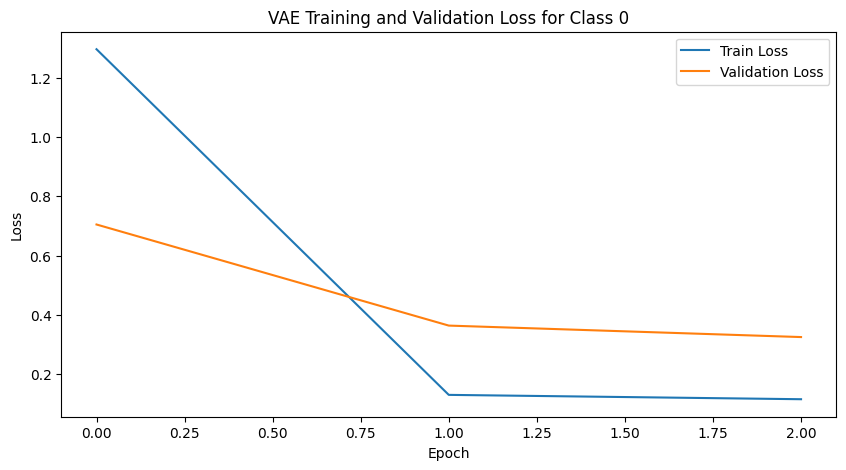

In [20]:
# Example: Plot losses for class 0
plot_vae_losses(all_train_losses[0], all_val_losses[0], class_index=0)

## Generative Adversarial Network (GAN)

## Citation

```bibtex
@techreport{krizhevsky2009learning,
  title = {Learning Multiple Layers of Features from Tiny Images},
  author = {Alex Krizhevsky},
  institution = {University of Toronto},
  year = {2009},
  url = {https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf}
}